# Analytics - Product Quality

#### Date: 2023/11

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: CAPJU

##### Semester: 2023/02
##### Professor: Hilmer Neri

##### Members:






### LIBRARIES

In [1]:

# !pip install -r requirements.txt

import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-2-Capju-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'Processmanagement': 'js',
    'User': 'js',
    'Role': 'js',
    'Unit': 'js',
    'Note': 'js',
    'Front': 'tsx',
}

### SonarCloud
##### Path to the folder with all your jsons

In [5]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/*.json')
sonar_files

['../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-16-2023-20-34-12-fix_syntax_error_release_ci.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-16-2023-20-41-13-fix_syntax_error_release_ci.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-17-2023-09-13-07-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-17-2023-09-18-39-main.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-17-2023-19-07-04-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-18-2023-14-05-14-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-19-2023-22-29-23-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-20-2023-19-42-44-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-20-2023-21-33-37-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Front-11-20-2023-21-46-12-develop.json',
 '../analytics-raw-data\\fga-eps-mds-2023-2-Capju-Fro

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df

def fix_repository_name(repository_name):
    return repository_name.split("-Service")[0]


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0].apply(fix_repository_name)
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023-2-Capju-Front', 'fga-eps-mds-2023-2-Capju-Note',
       'fga-eps-mds-2023-2-Capju-Processmanagement',
       'fga-eps-mds-2023-2-Capju-Role', 'fga-eps-mds-2023-2-Capju-Unit',
       'fga-eps-mds-2023-2-Capju-User'], dtype=object)

### Create dataframe per repository

In [13]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
#             print(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])


## Data visualization

In this area you will need to plot the metrics of each repository.

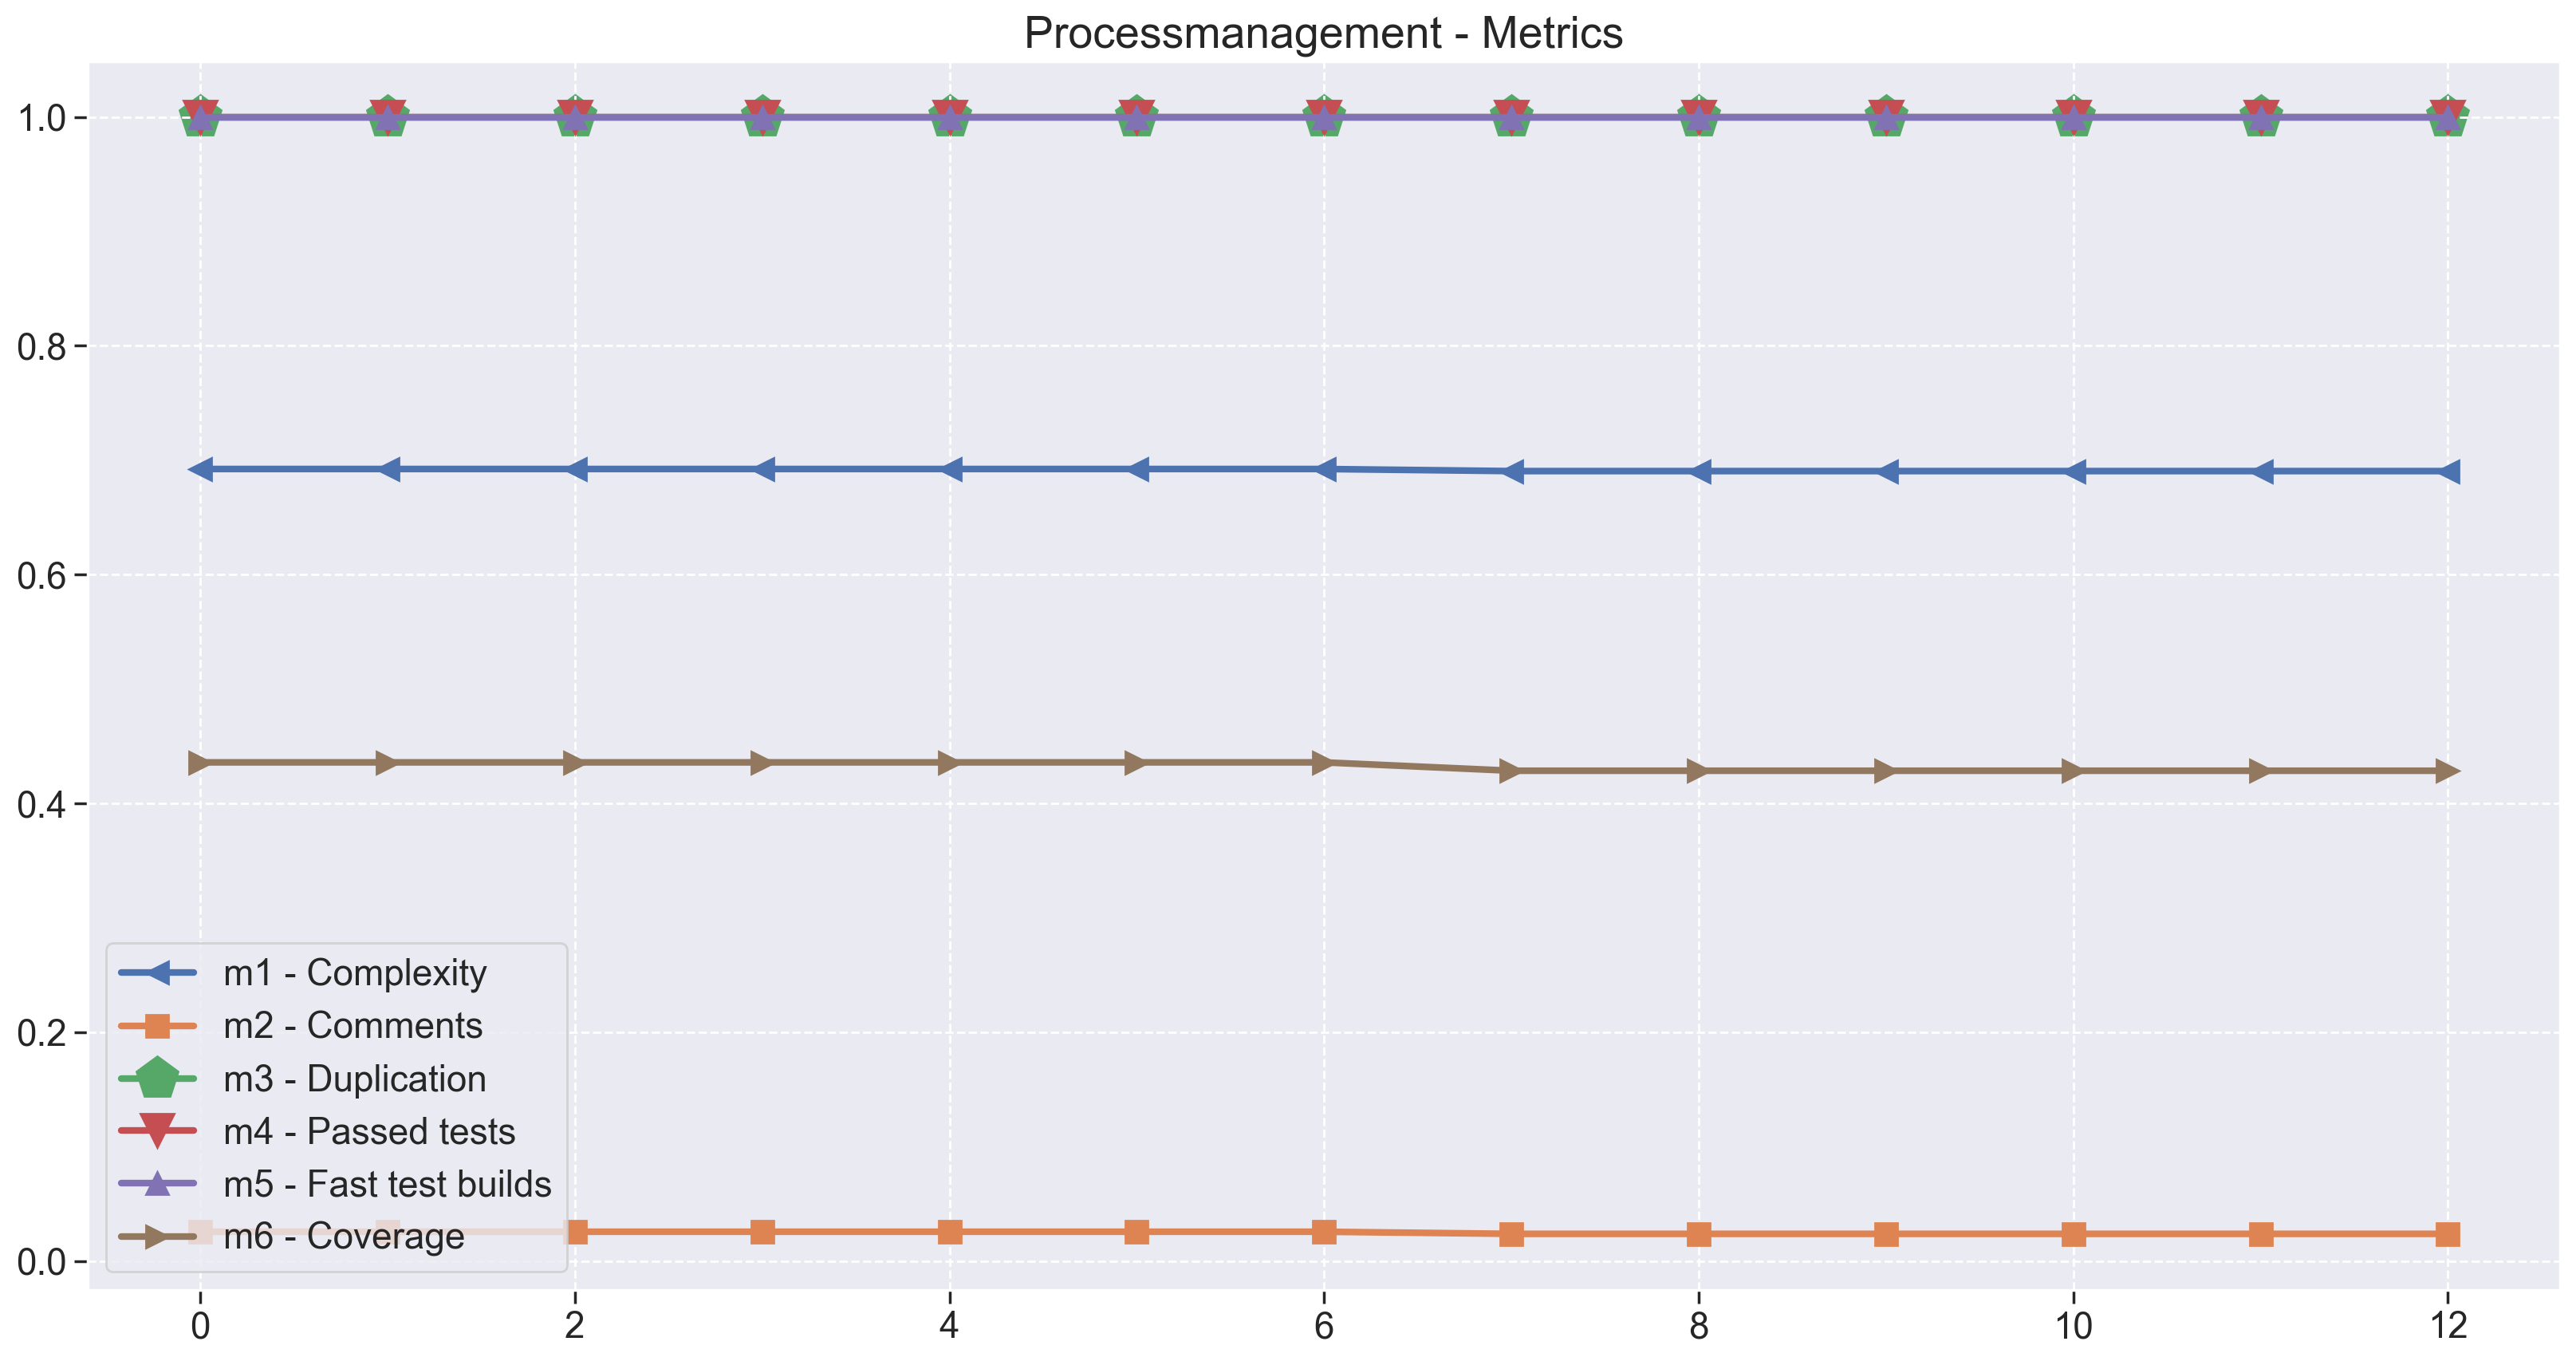

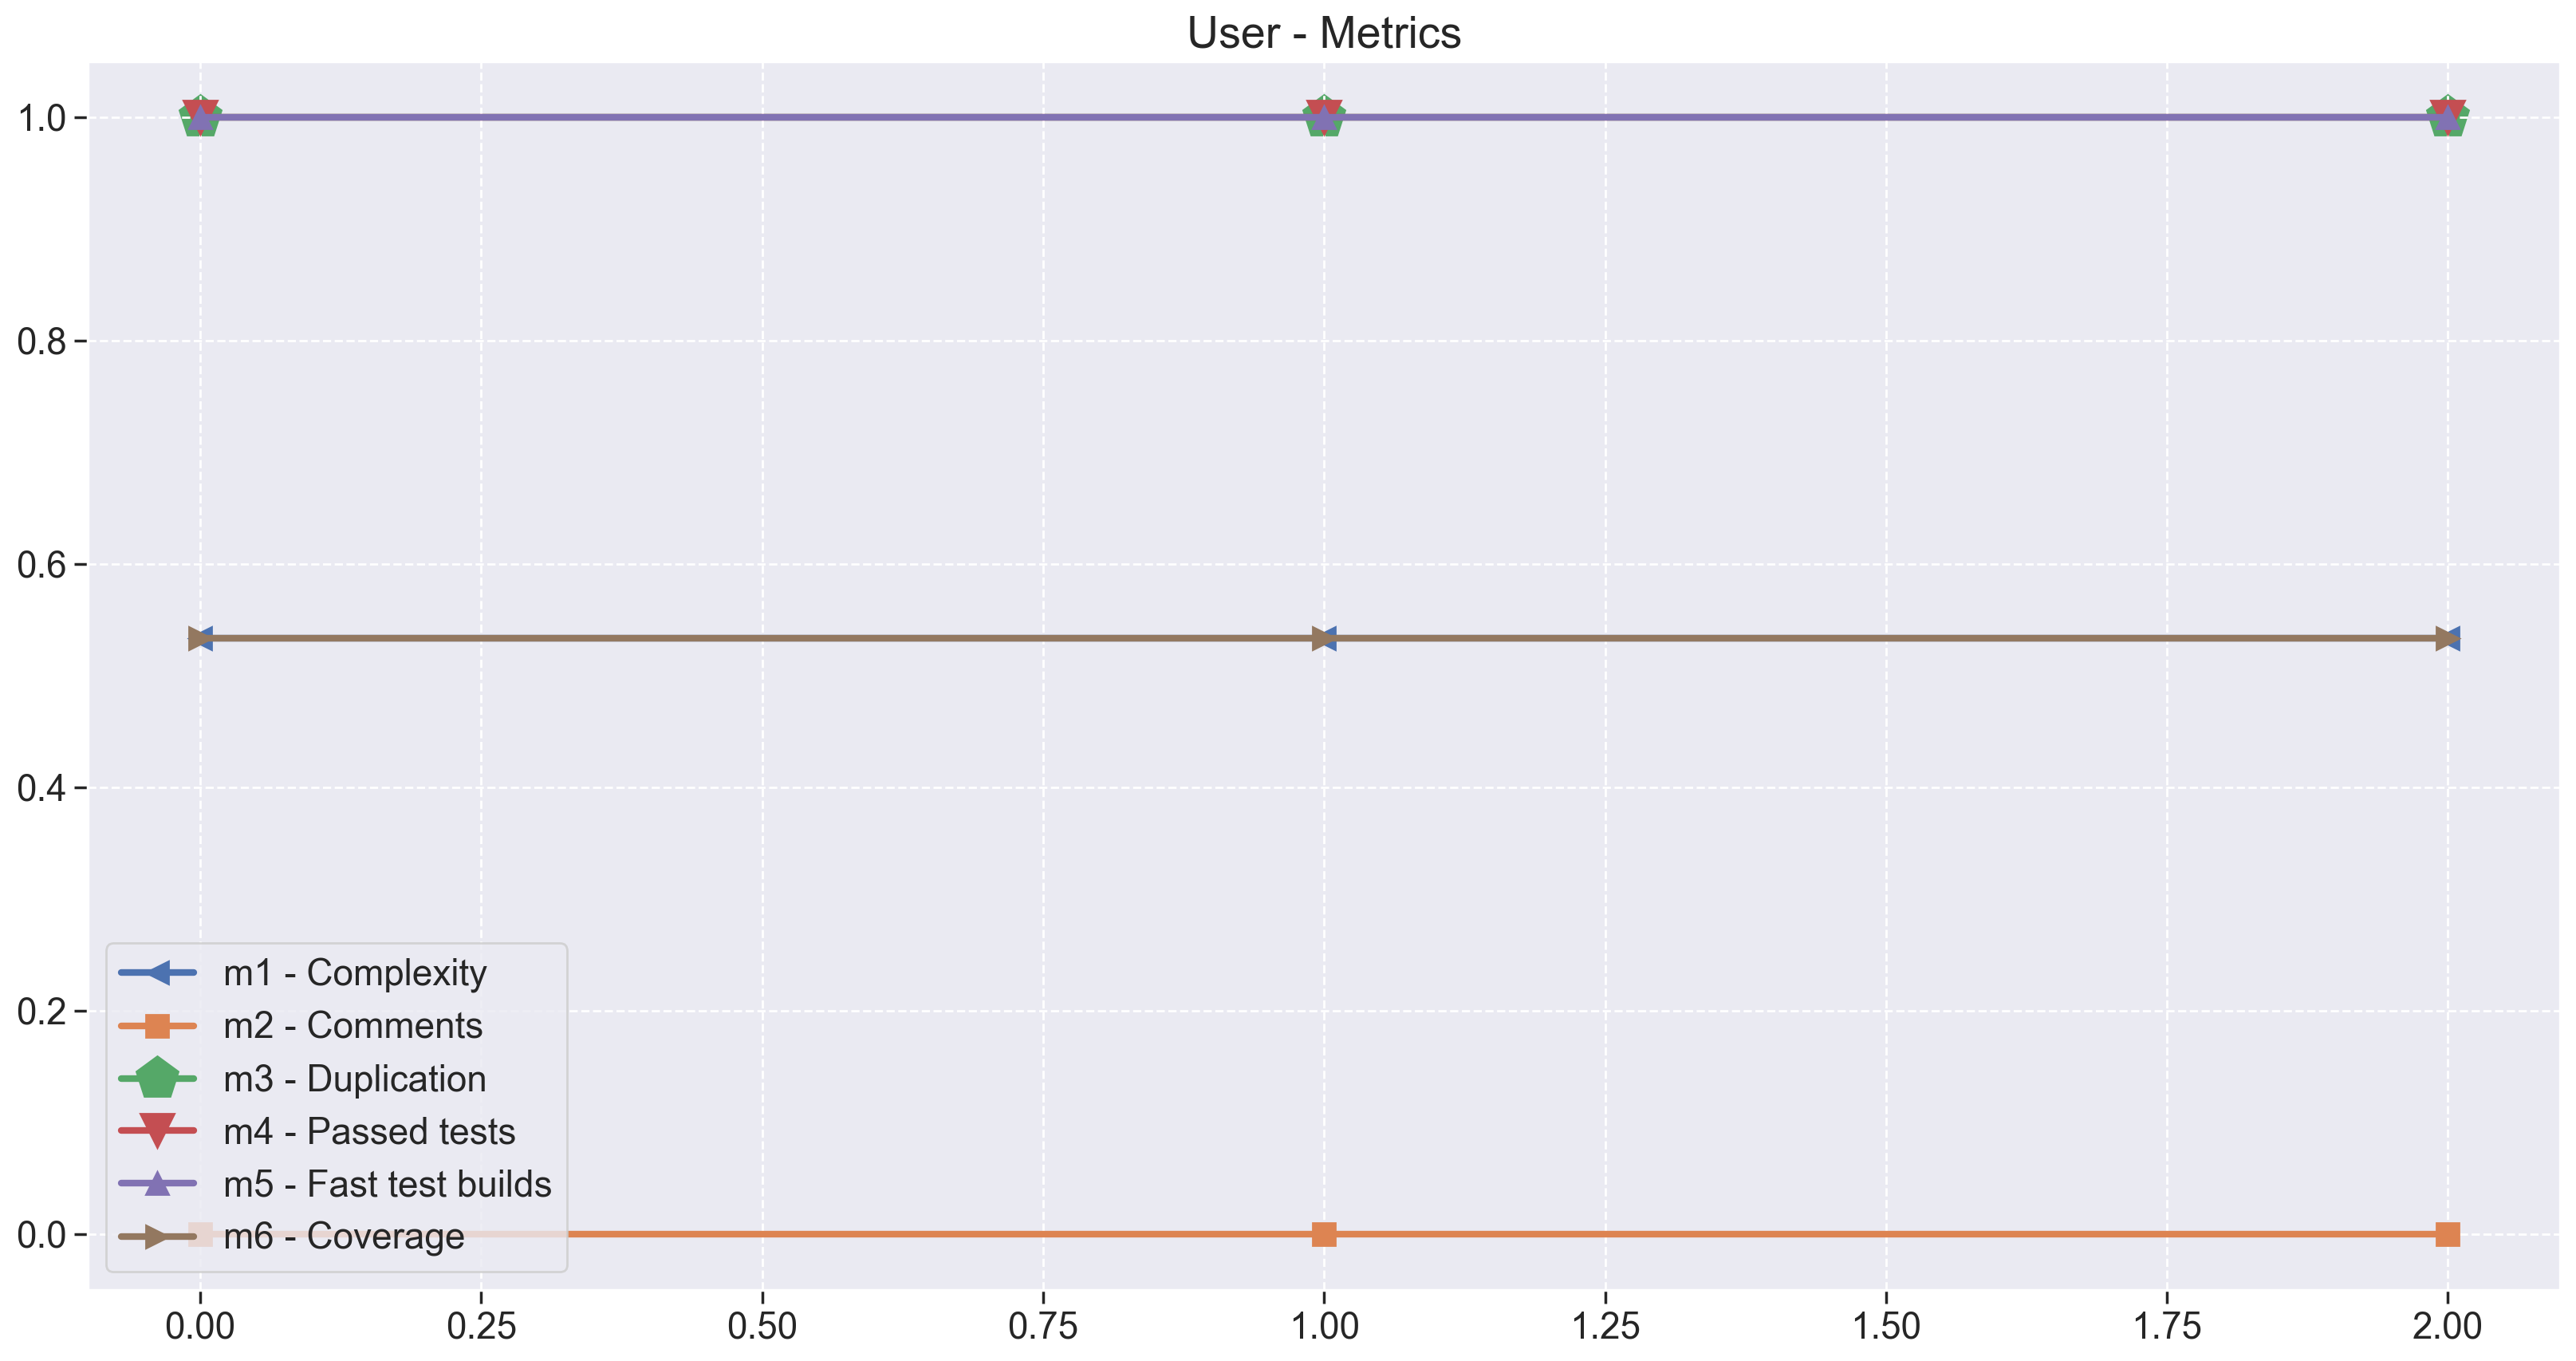

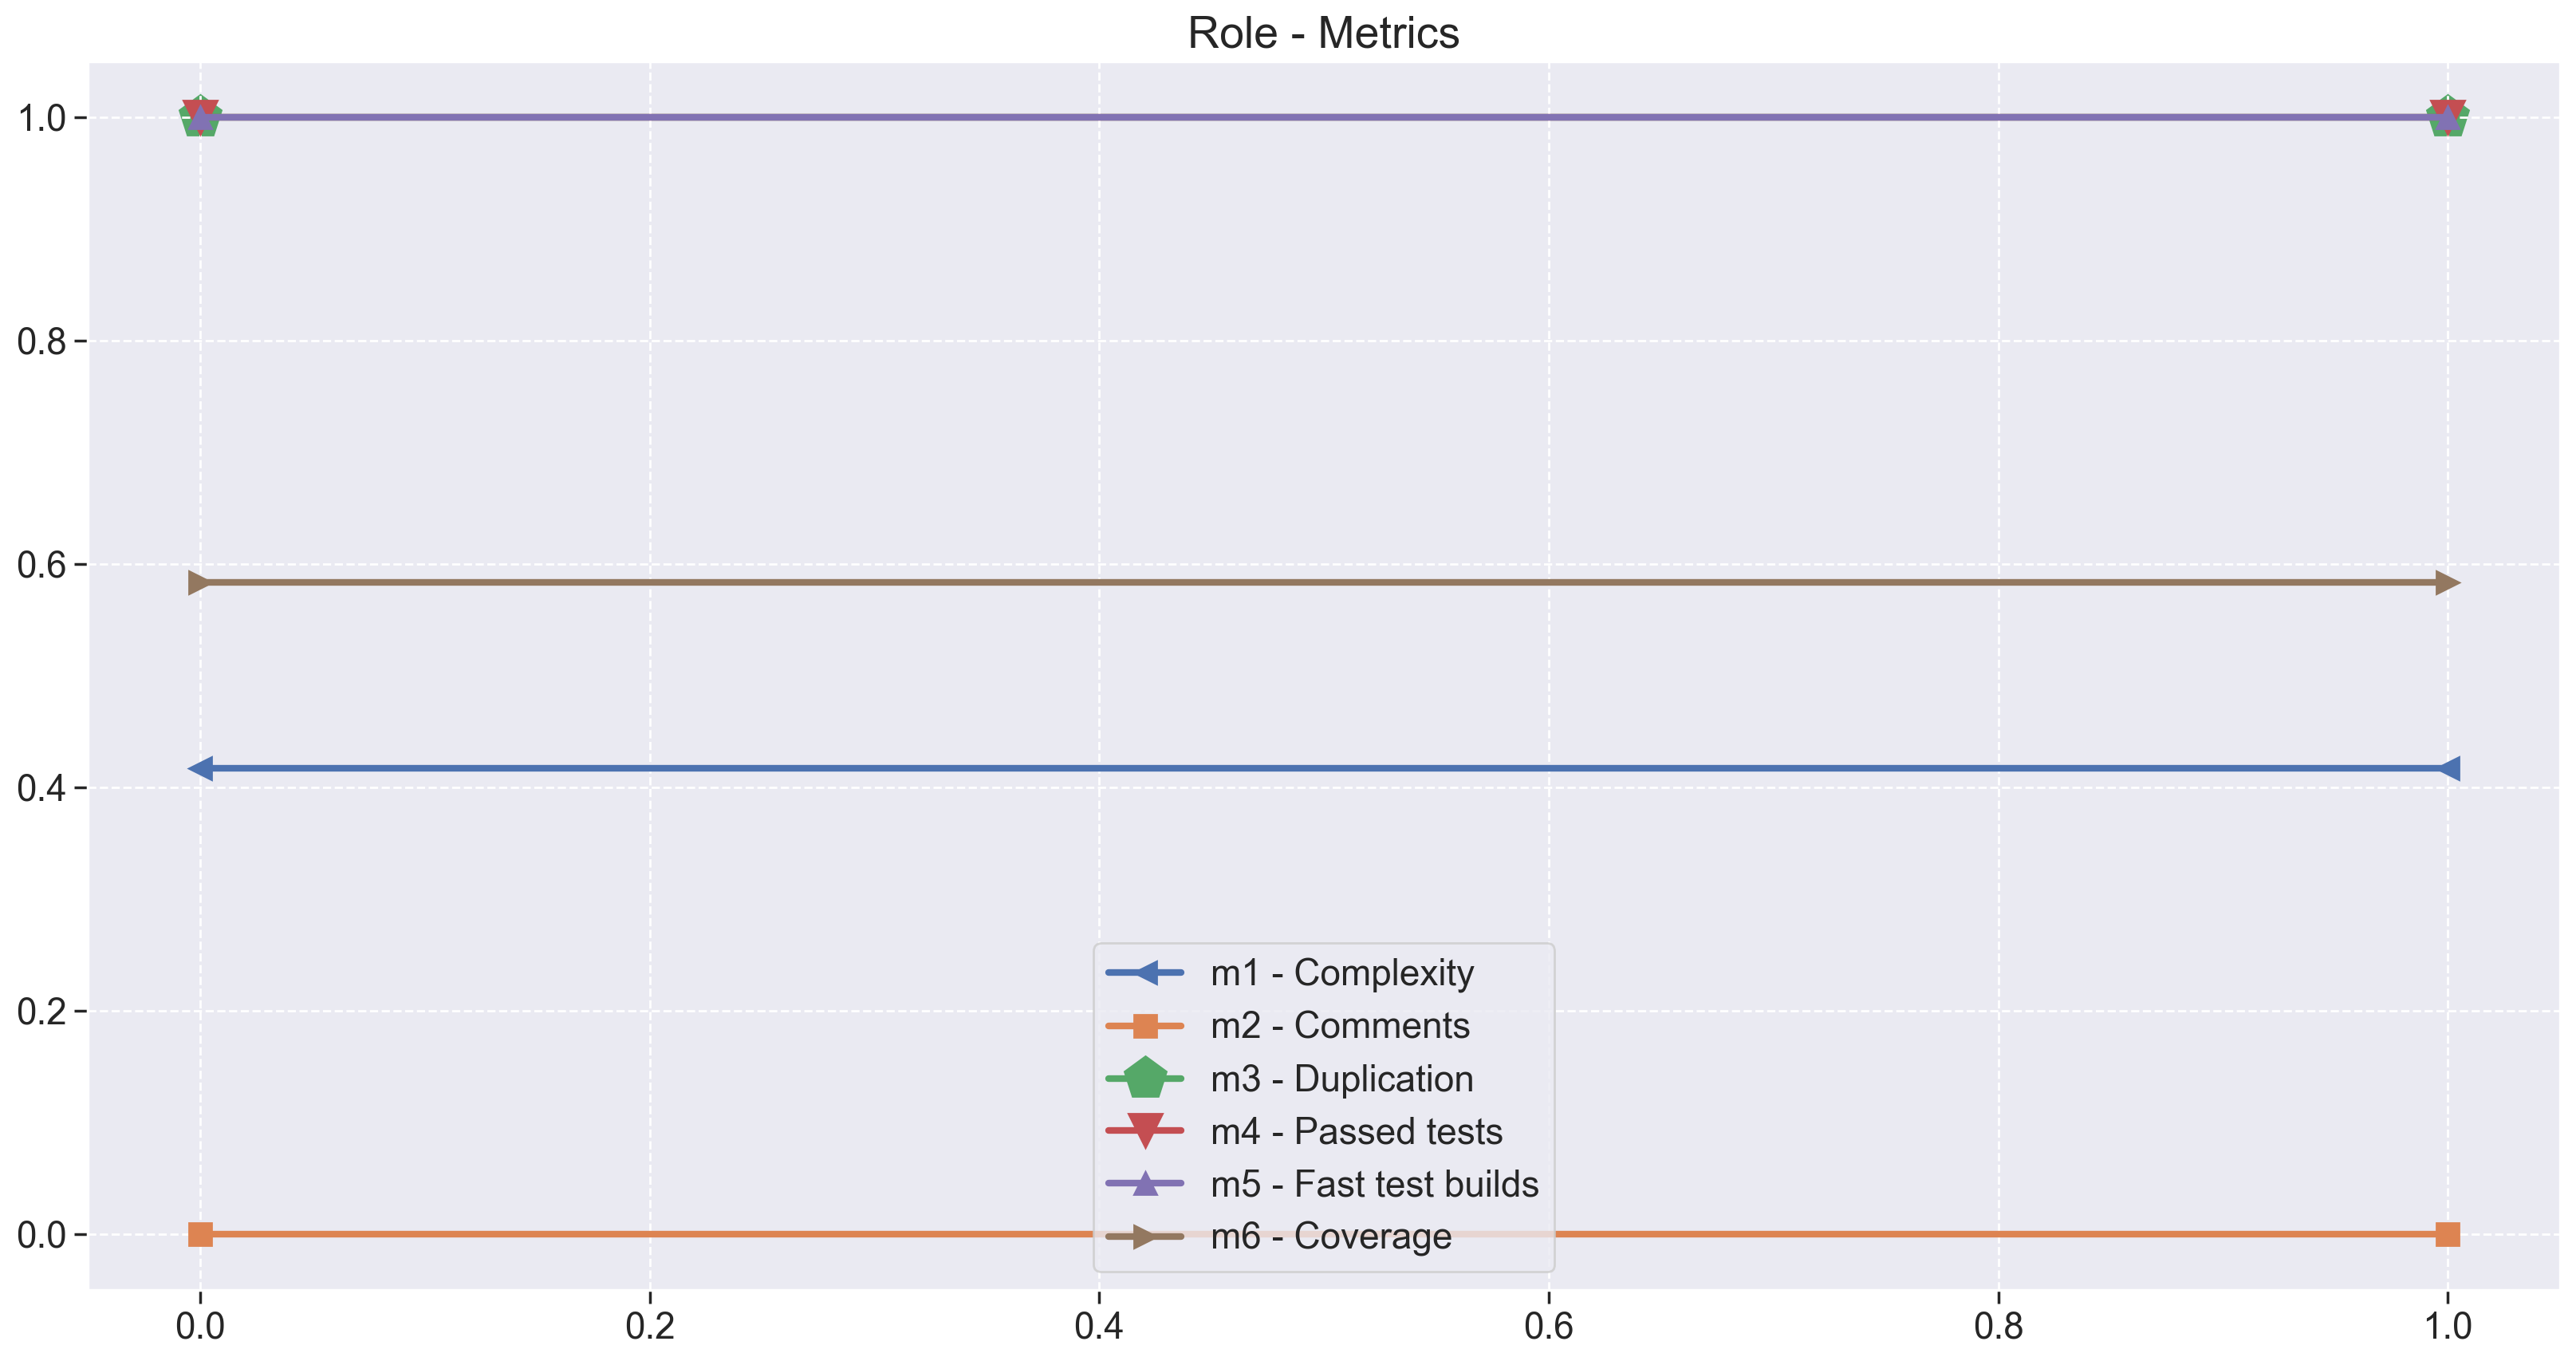

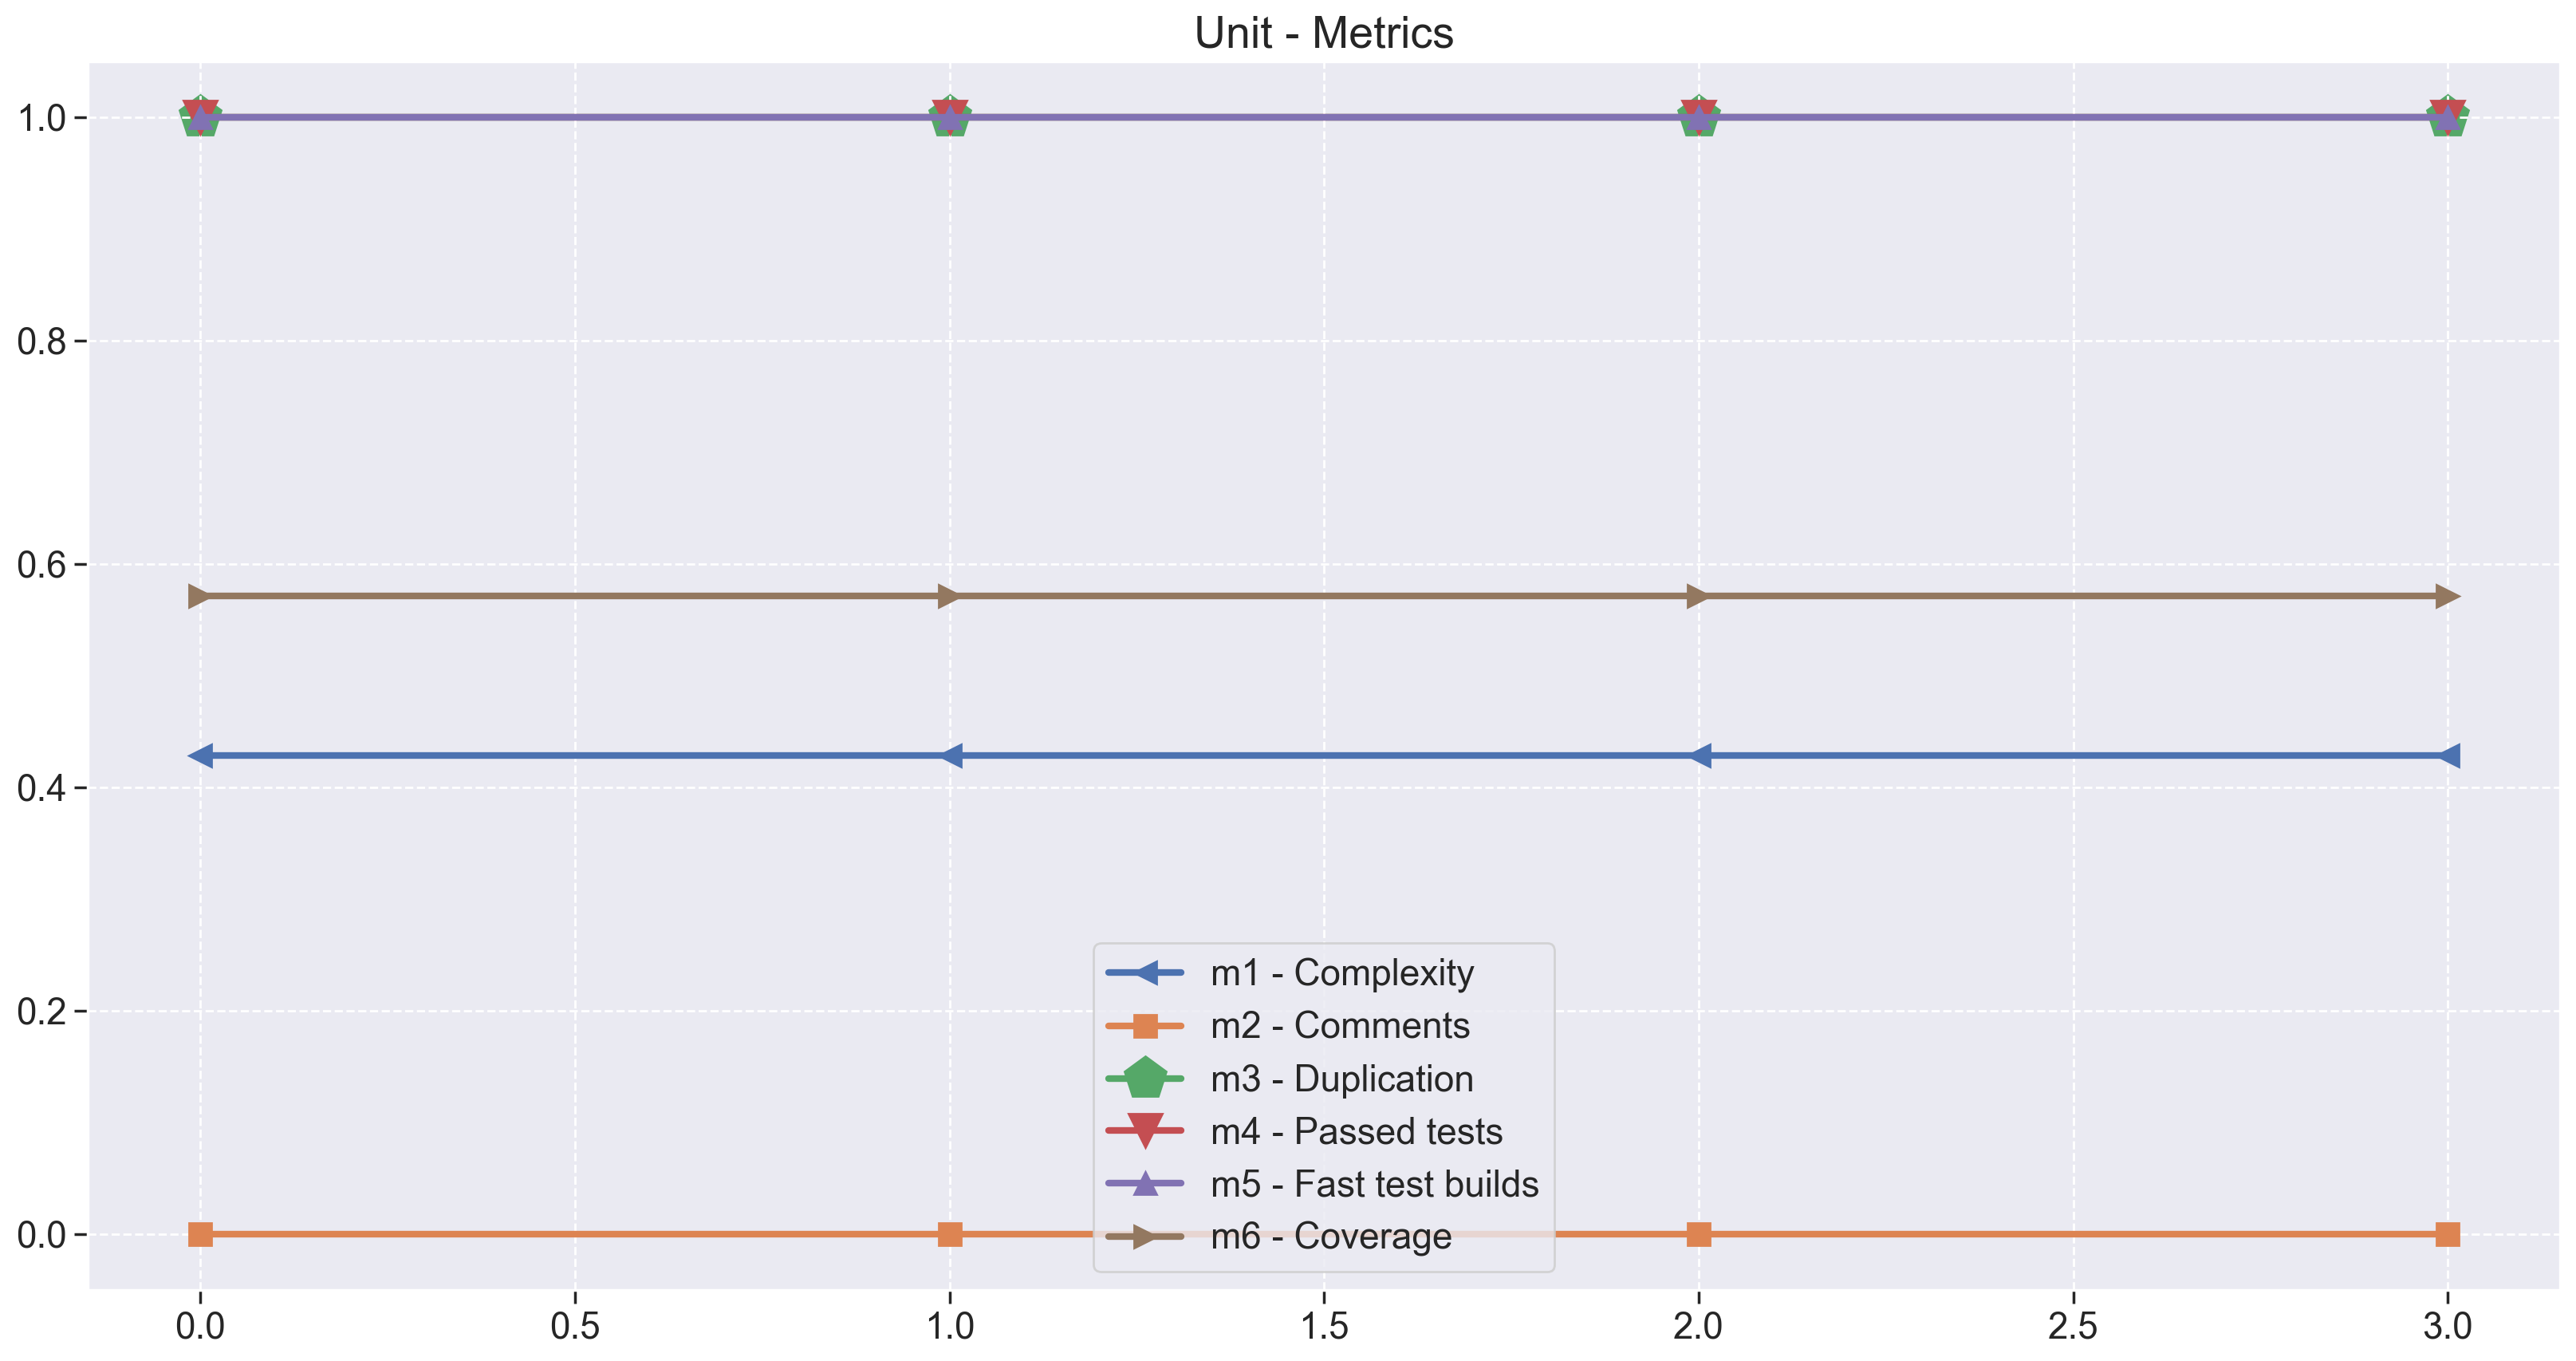

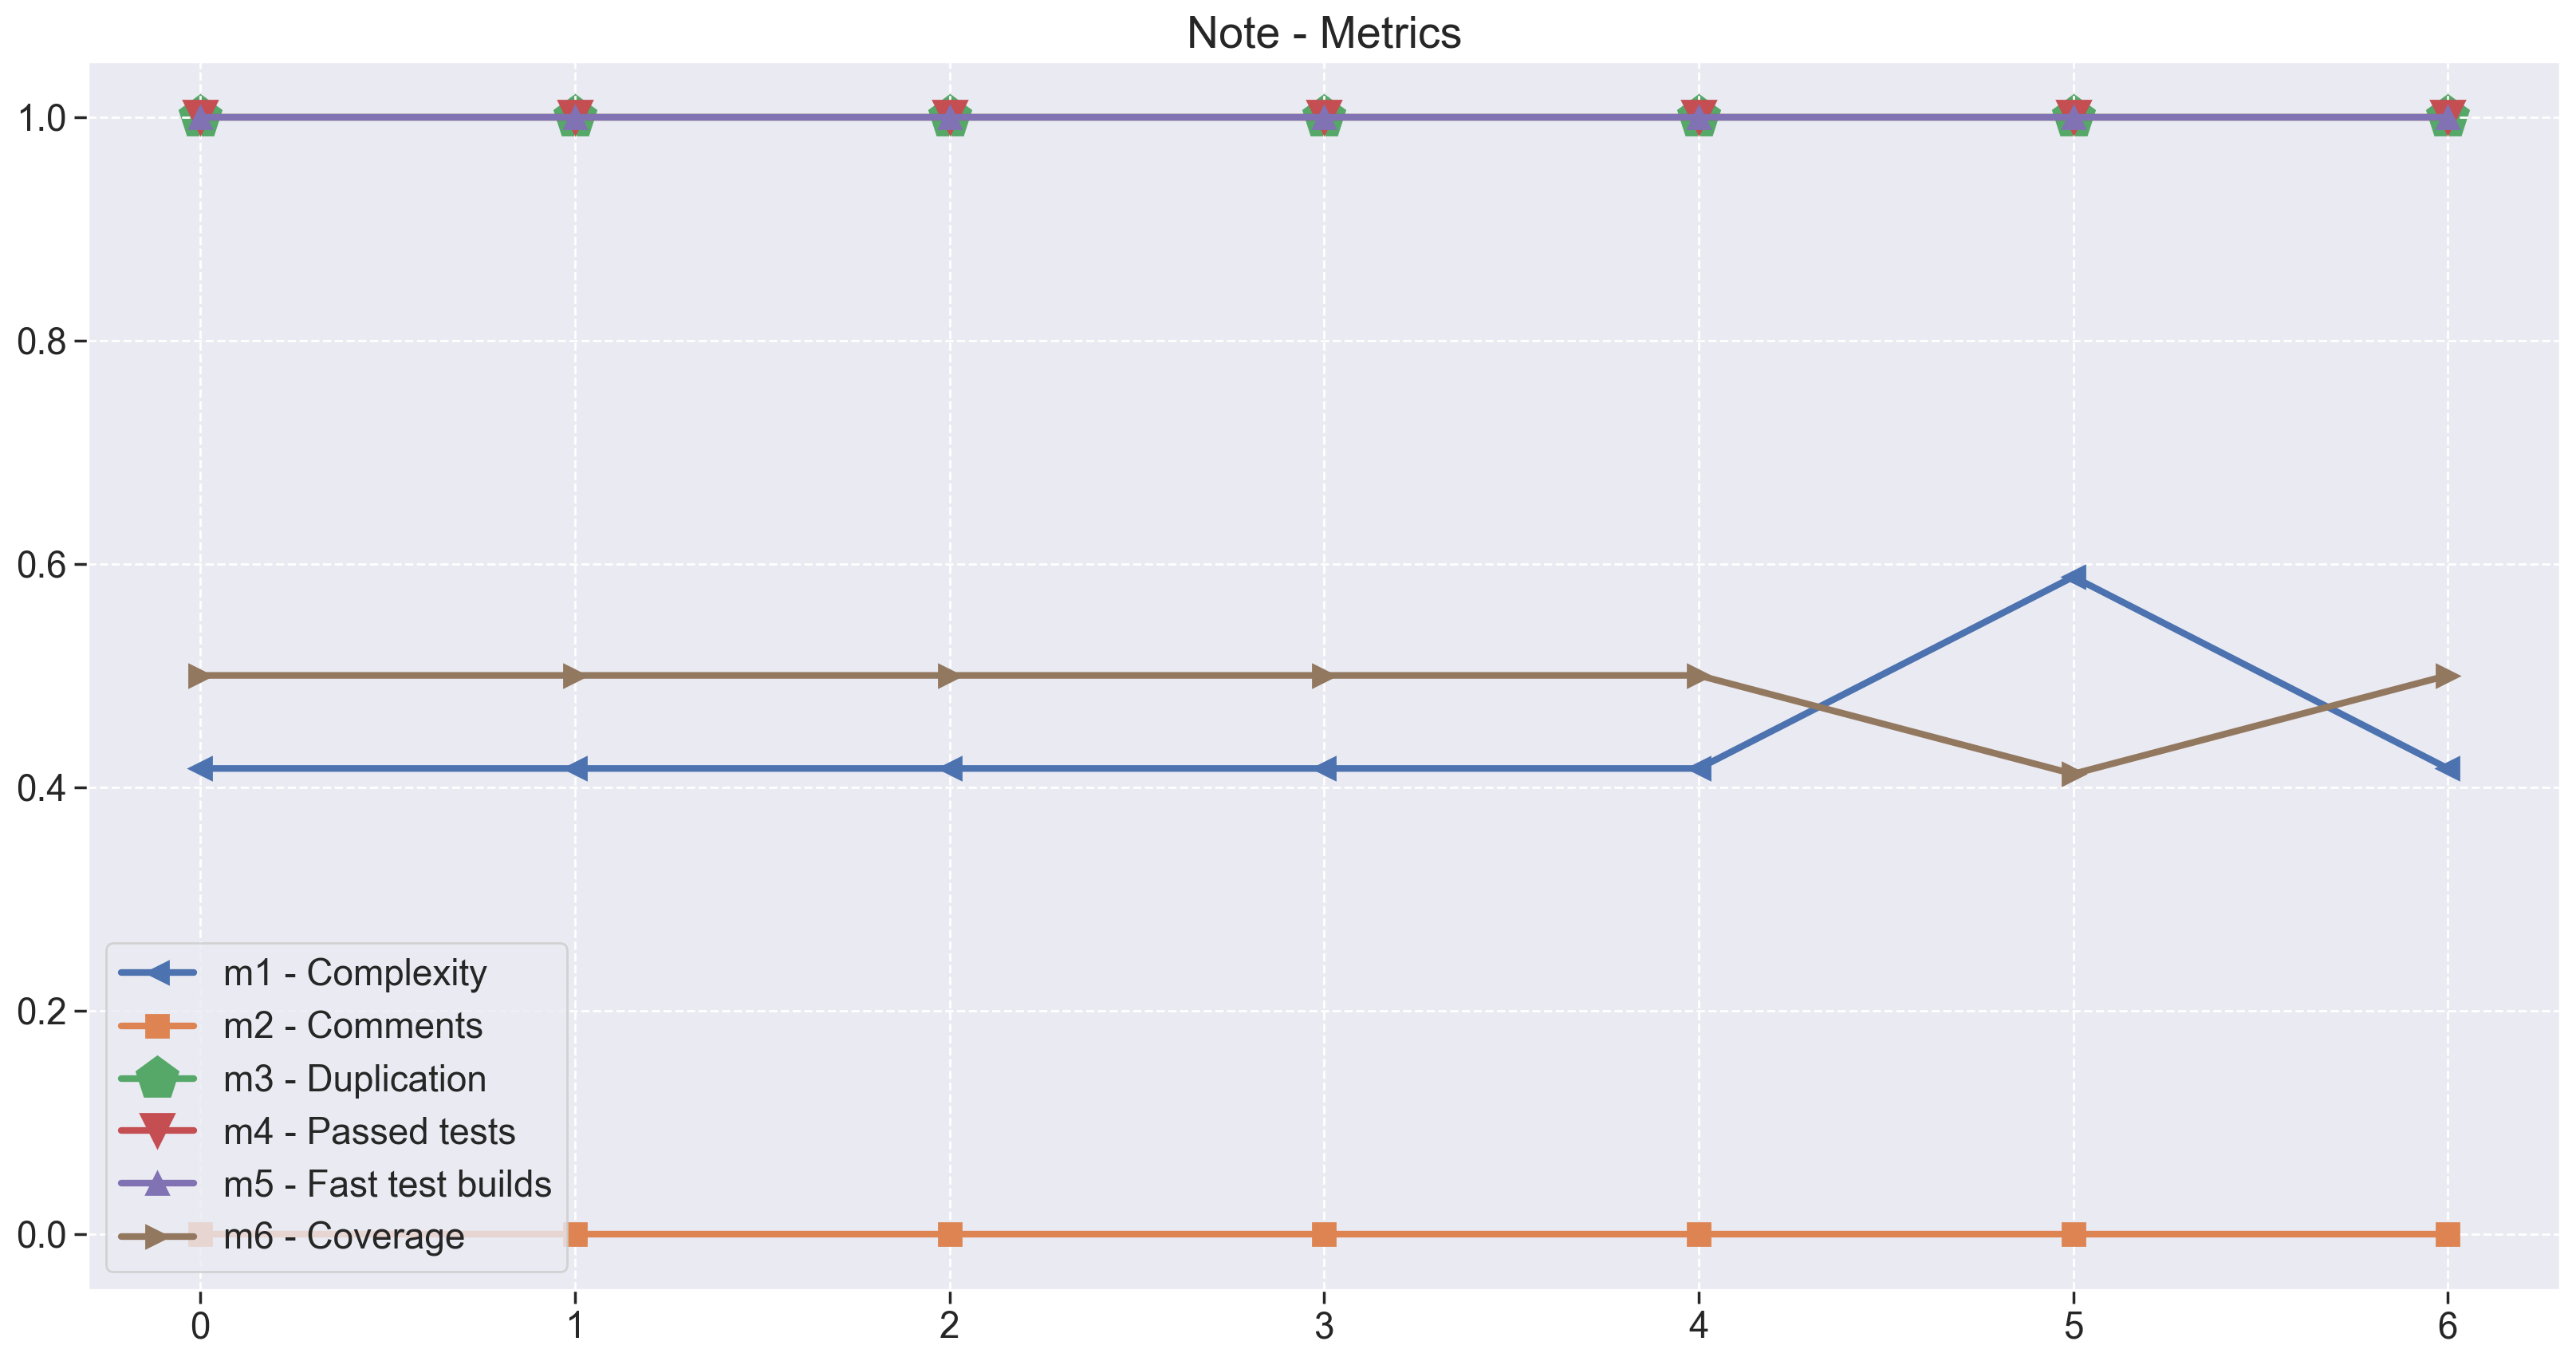

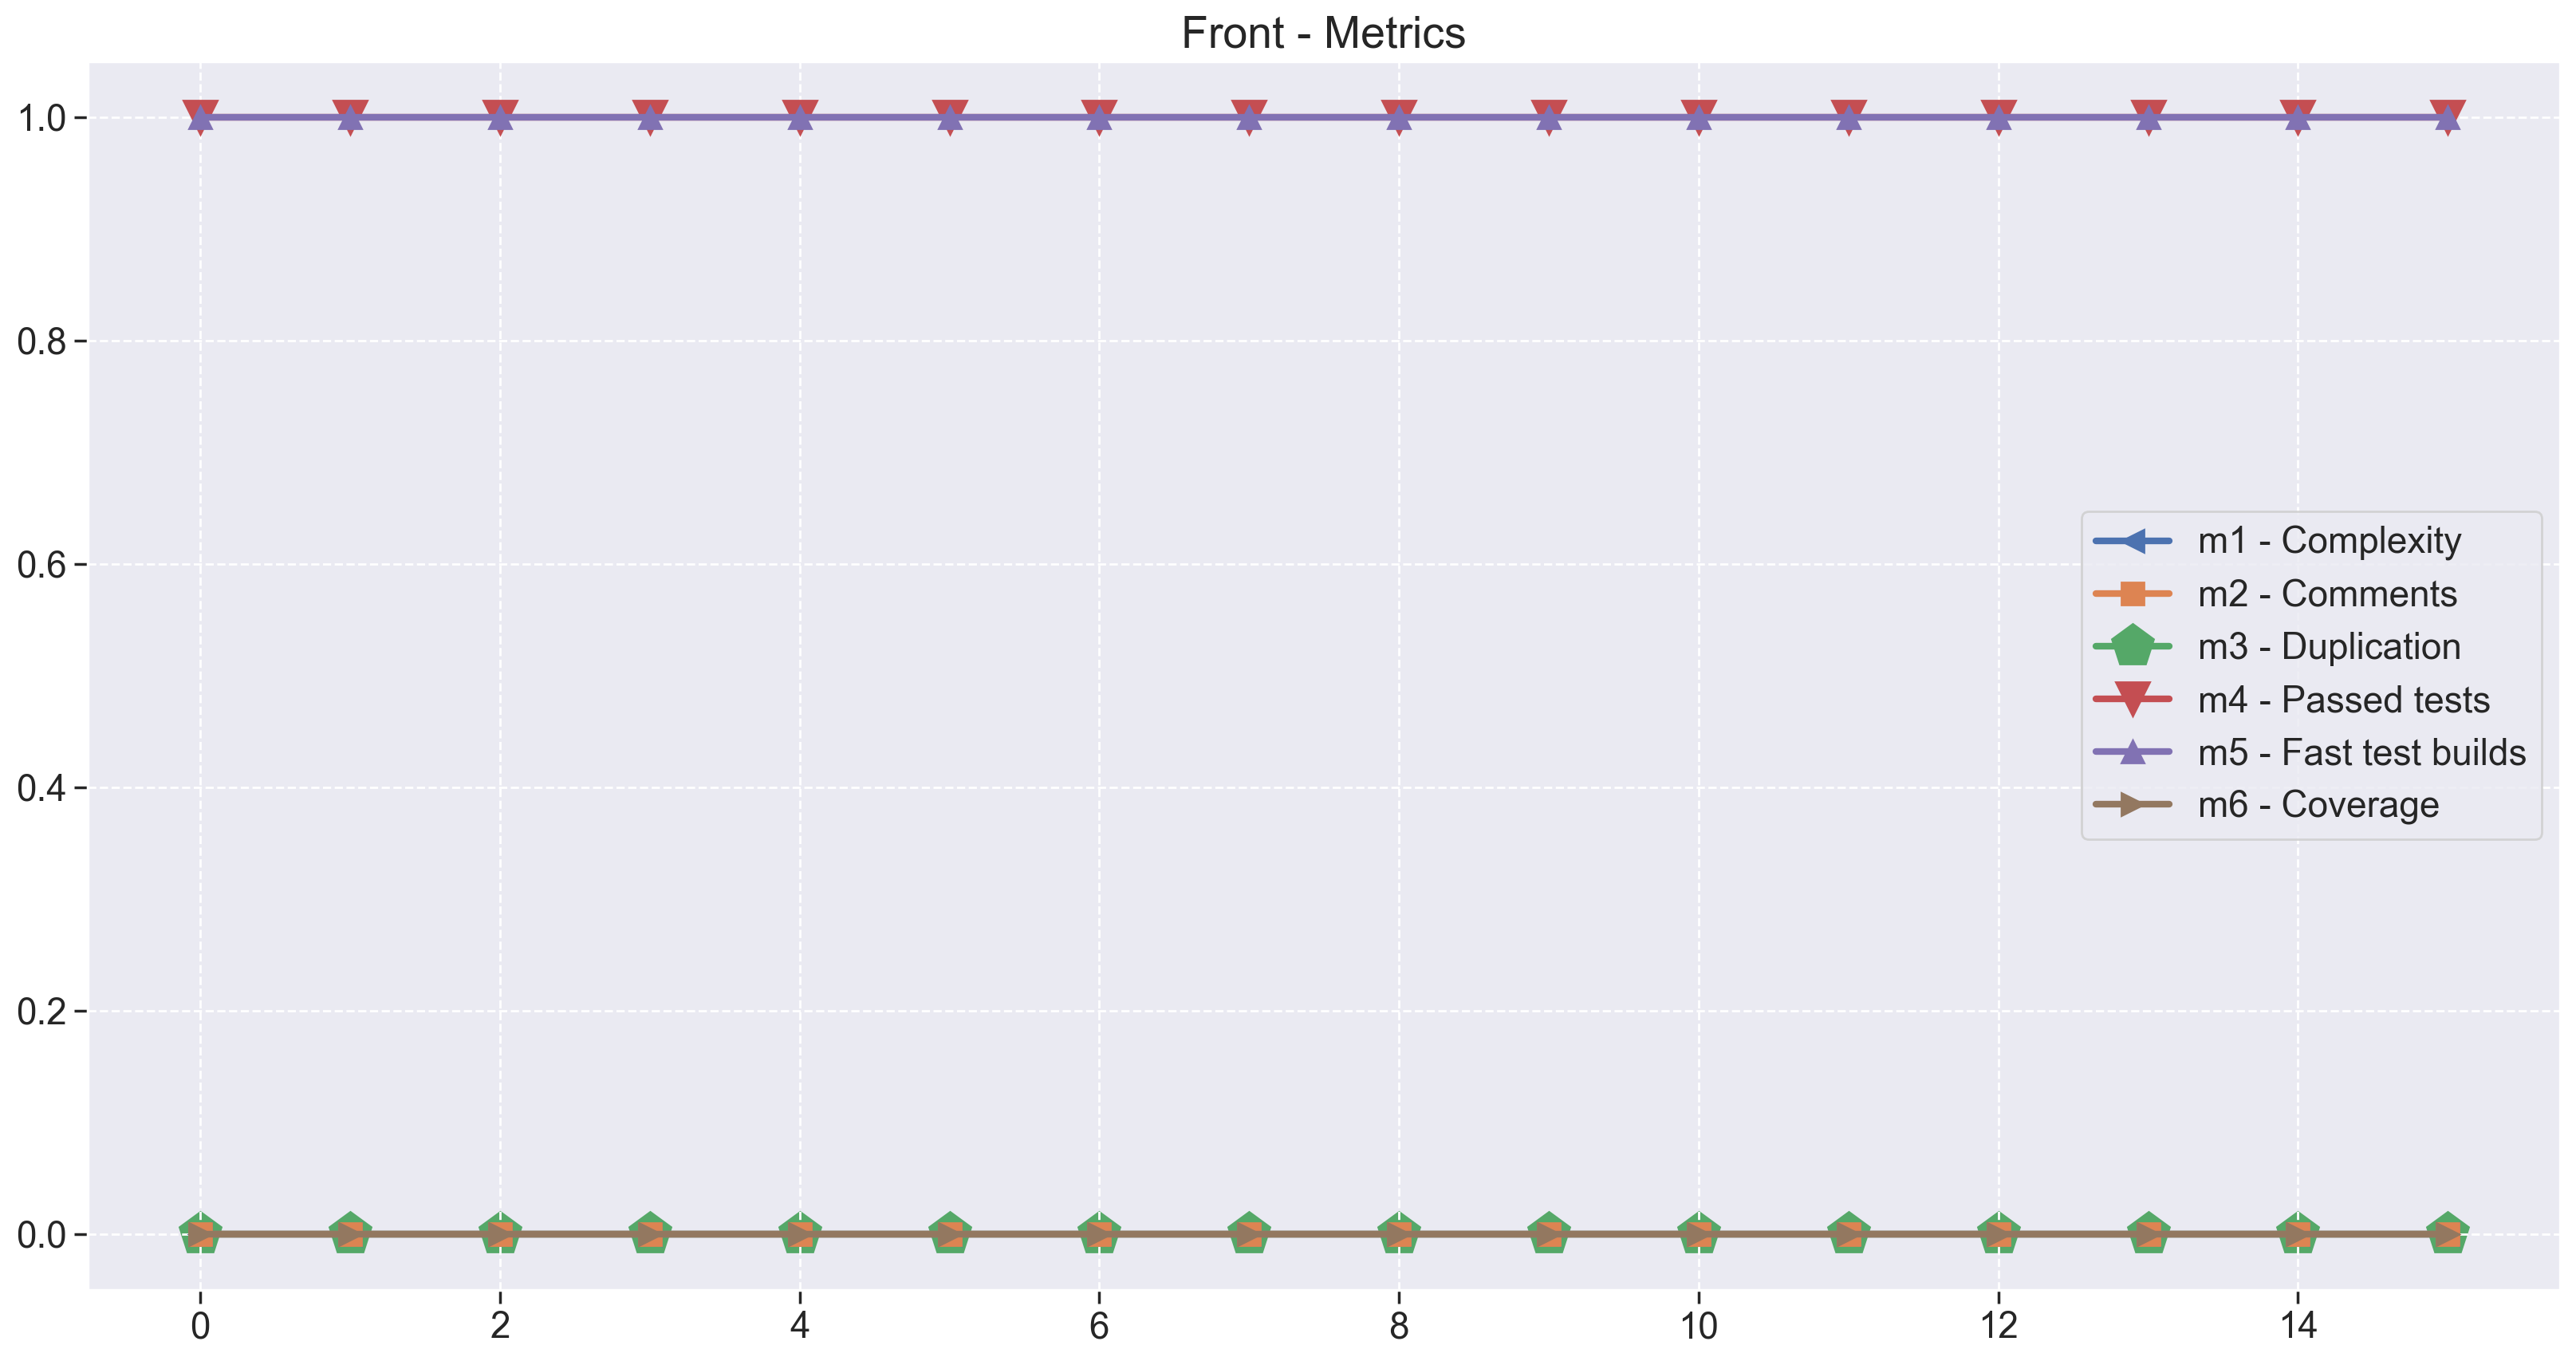

In [23]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=20, zorder=0, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=15, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

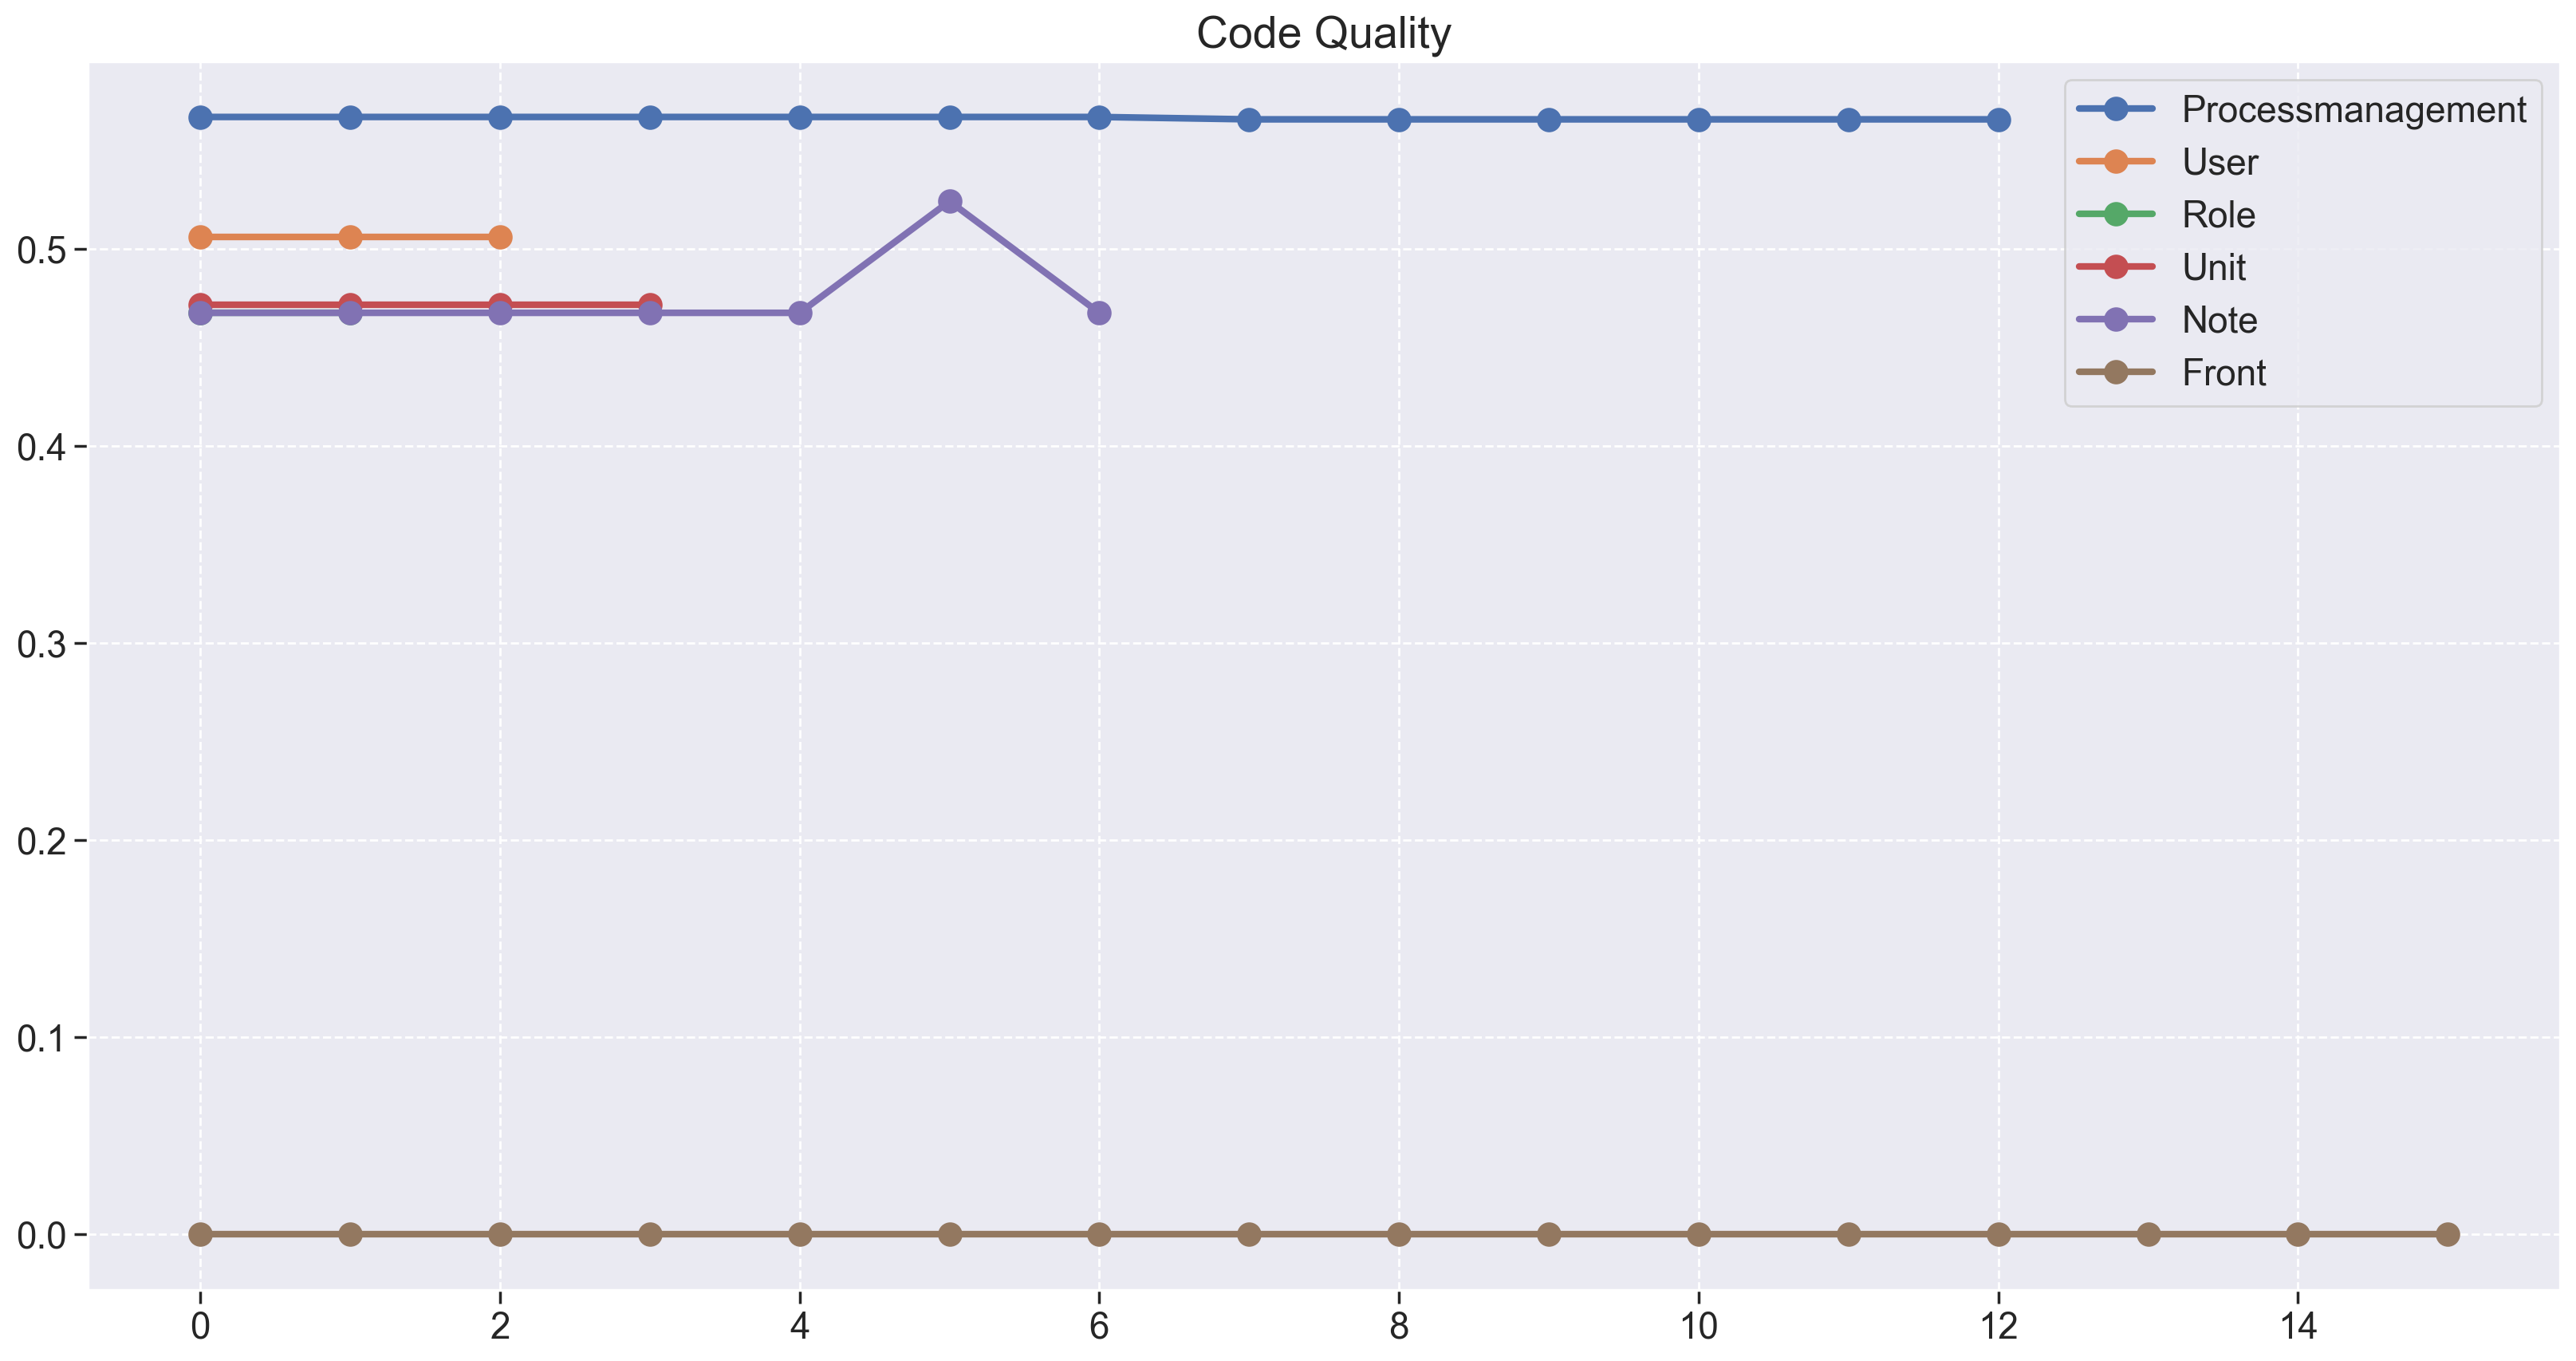

In [25]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

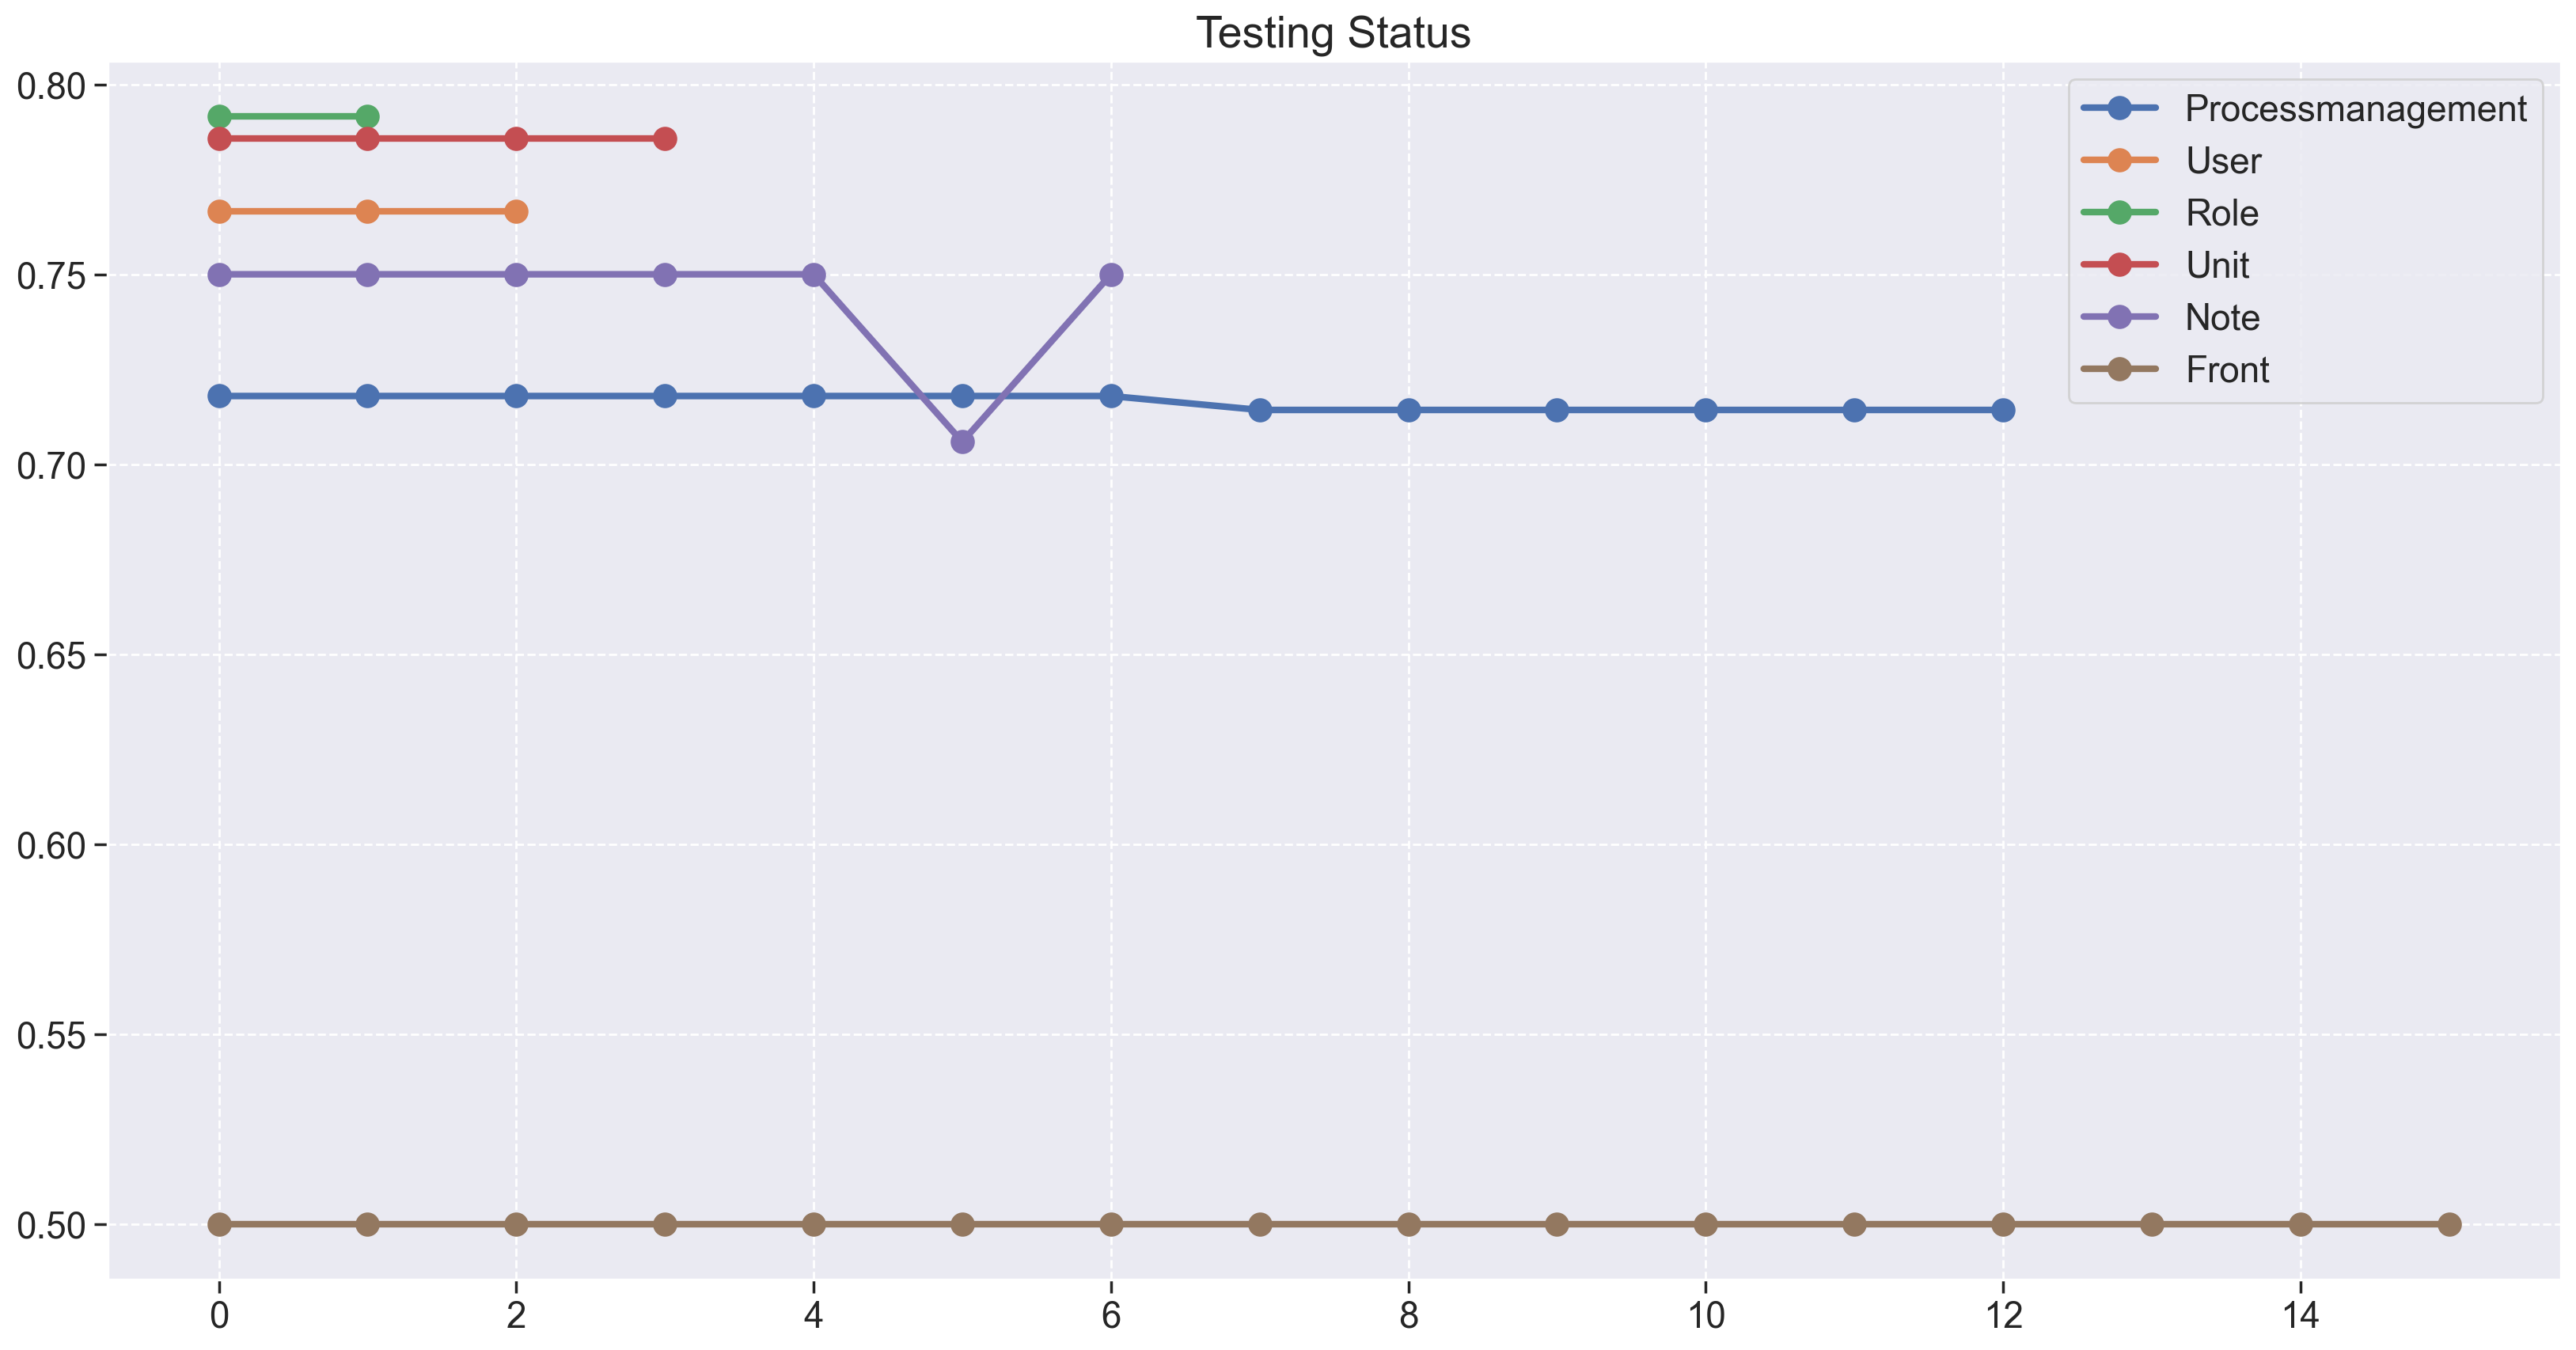

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [27]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [28]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [29]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

Processmanagement
Maintainability Stats
    mean     mode   median      std          var      min      max
0.283183 0.283462 0.283462 0.000314 9.834840e-08 0.282857 0.283462
Reliability Stats
    mean     mode   median     std          var      min      max
0.358129 0.358974 0.358974 0.00095 9.031074e-07 0.357143 0.358974


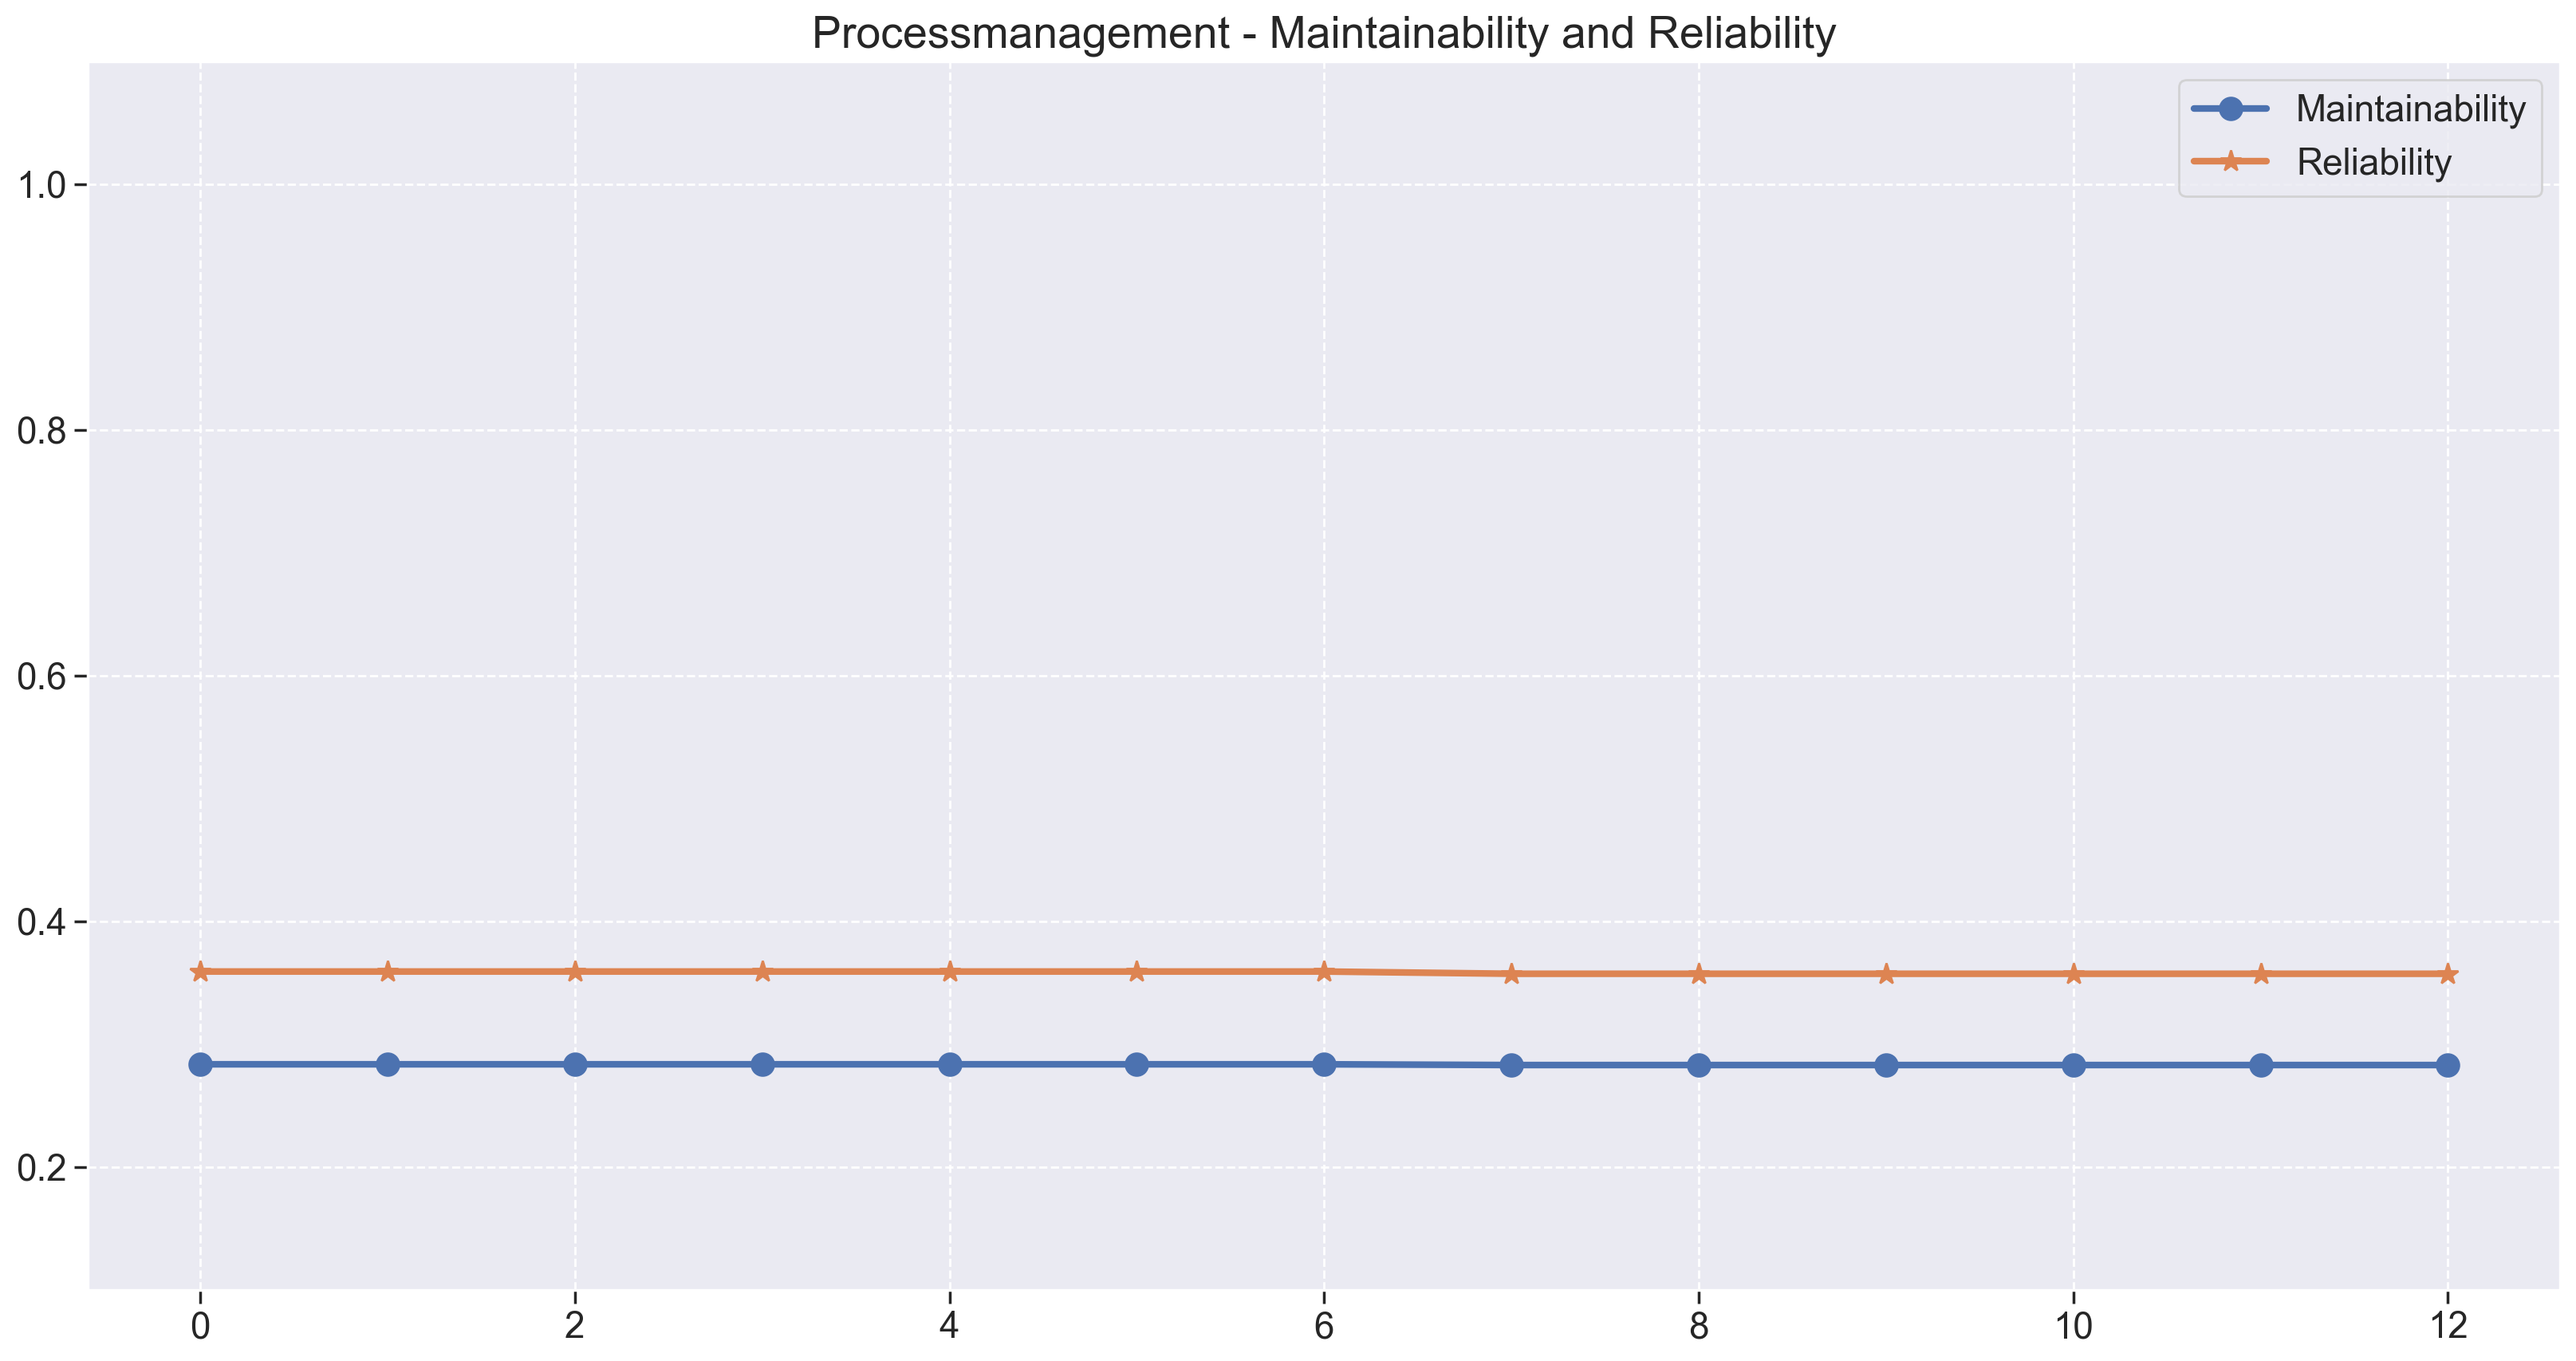

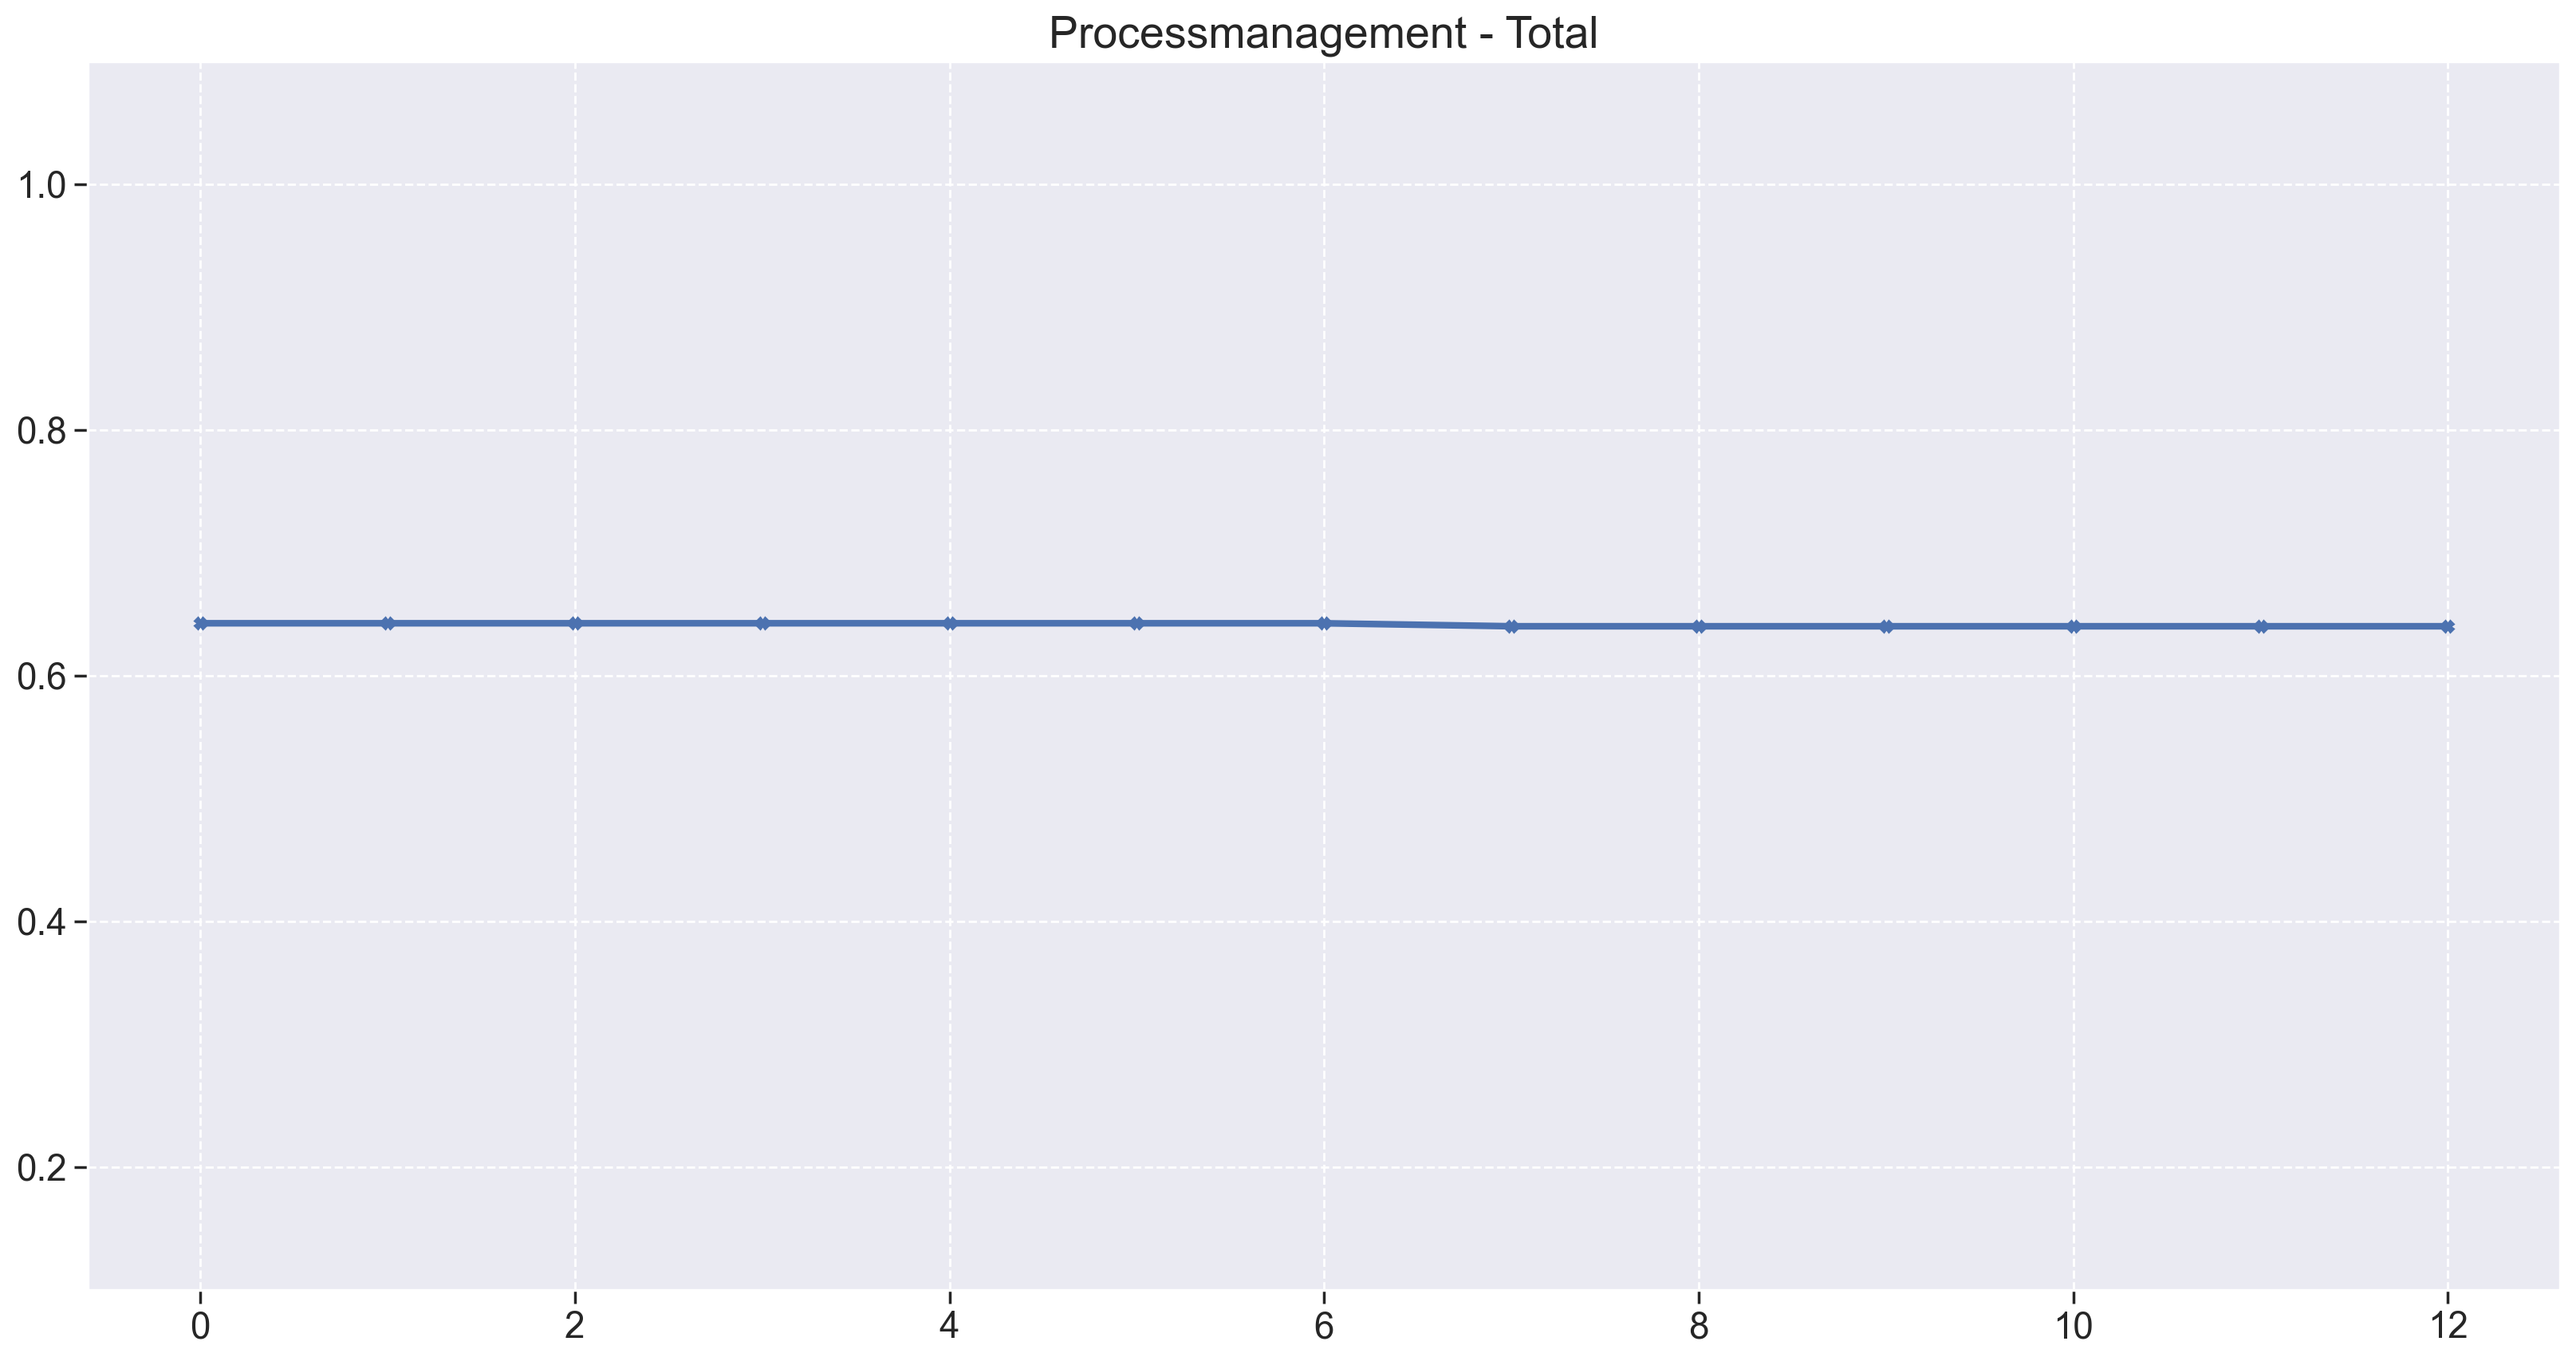

User
Maintainability Stats
 mean  mode  median  std  var   min   max
0.253 0.253   0.253  0.0  0.0 0.253 0.253
Reliability Stats
    mean     mode   median  std  var      min      max
0.383333 0.383333 0.383333  0.0  0.0 0.383333 0.383333


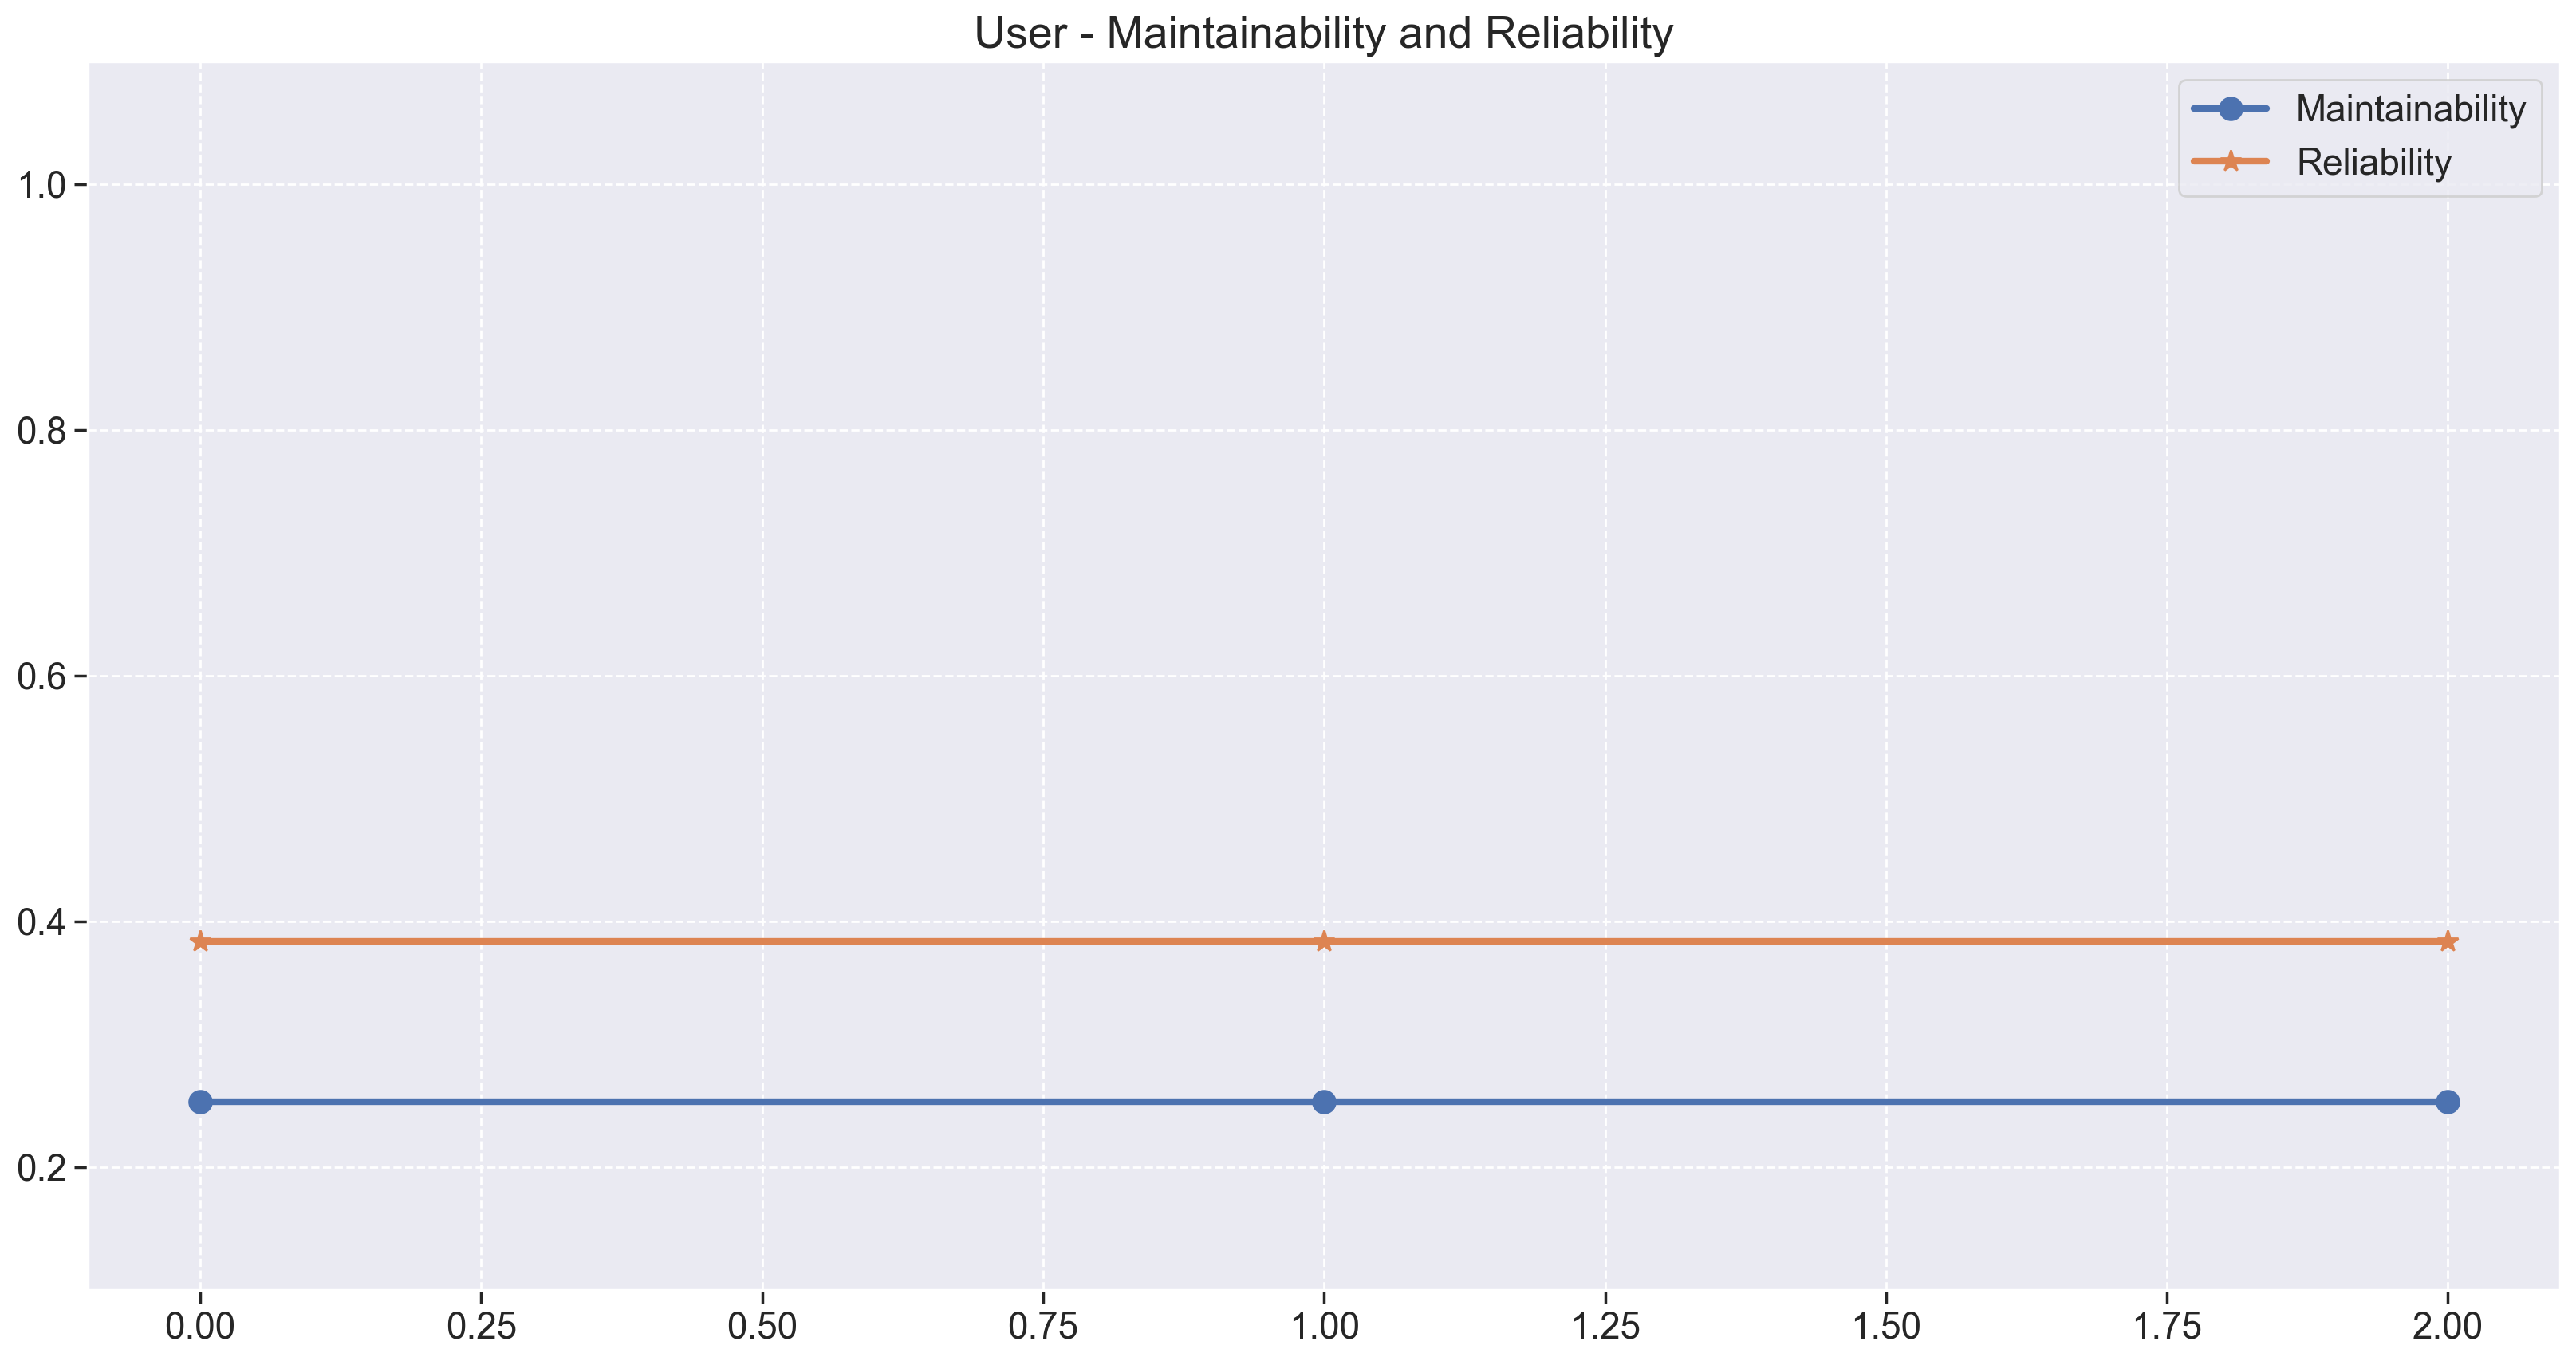

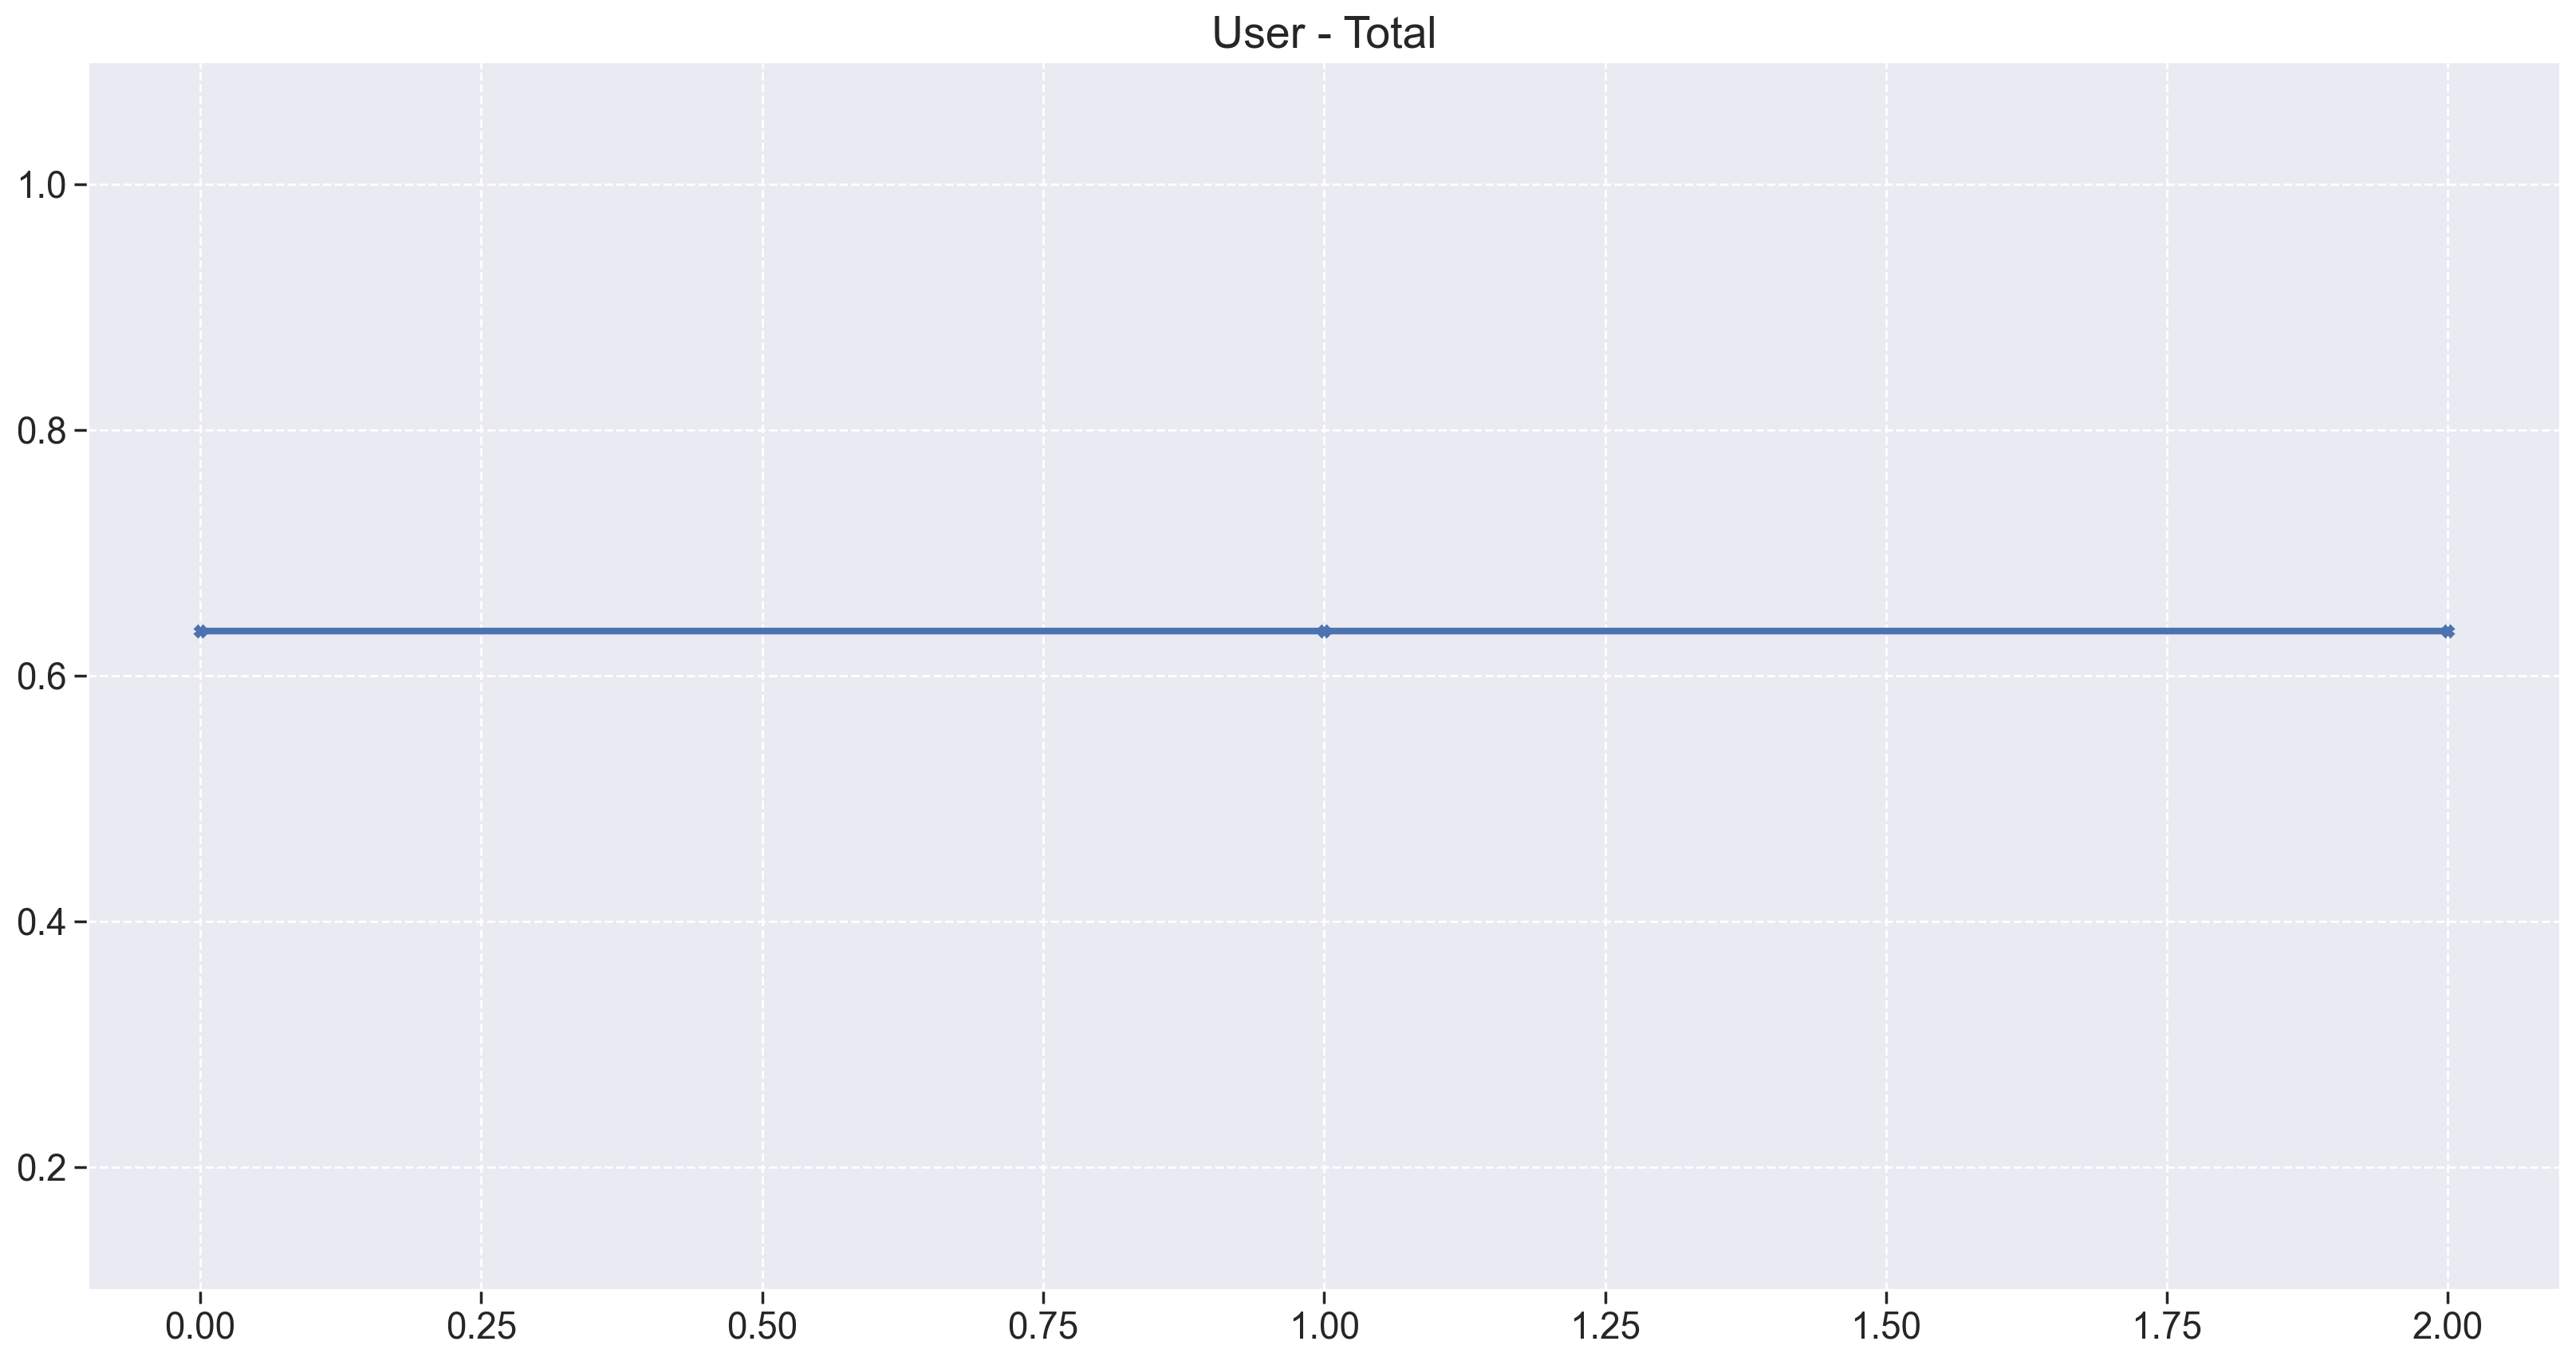

Role
Maintainability Stats
   mean    mode  median  std  var     min     max
0.23375 0.23375 0.23375  0.0  0.0 0.23375 0.23375
Reliability Stats
    mean     mode   median  std  var      min      max
0.395833 0.395833 0.395833  0.0  0.0 0.395833 0.395833


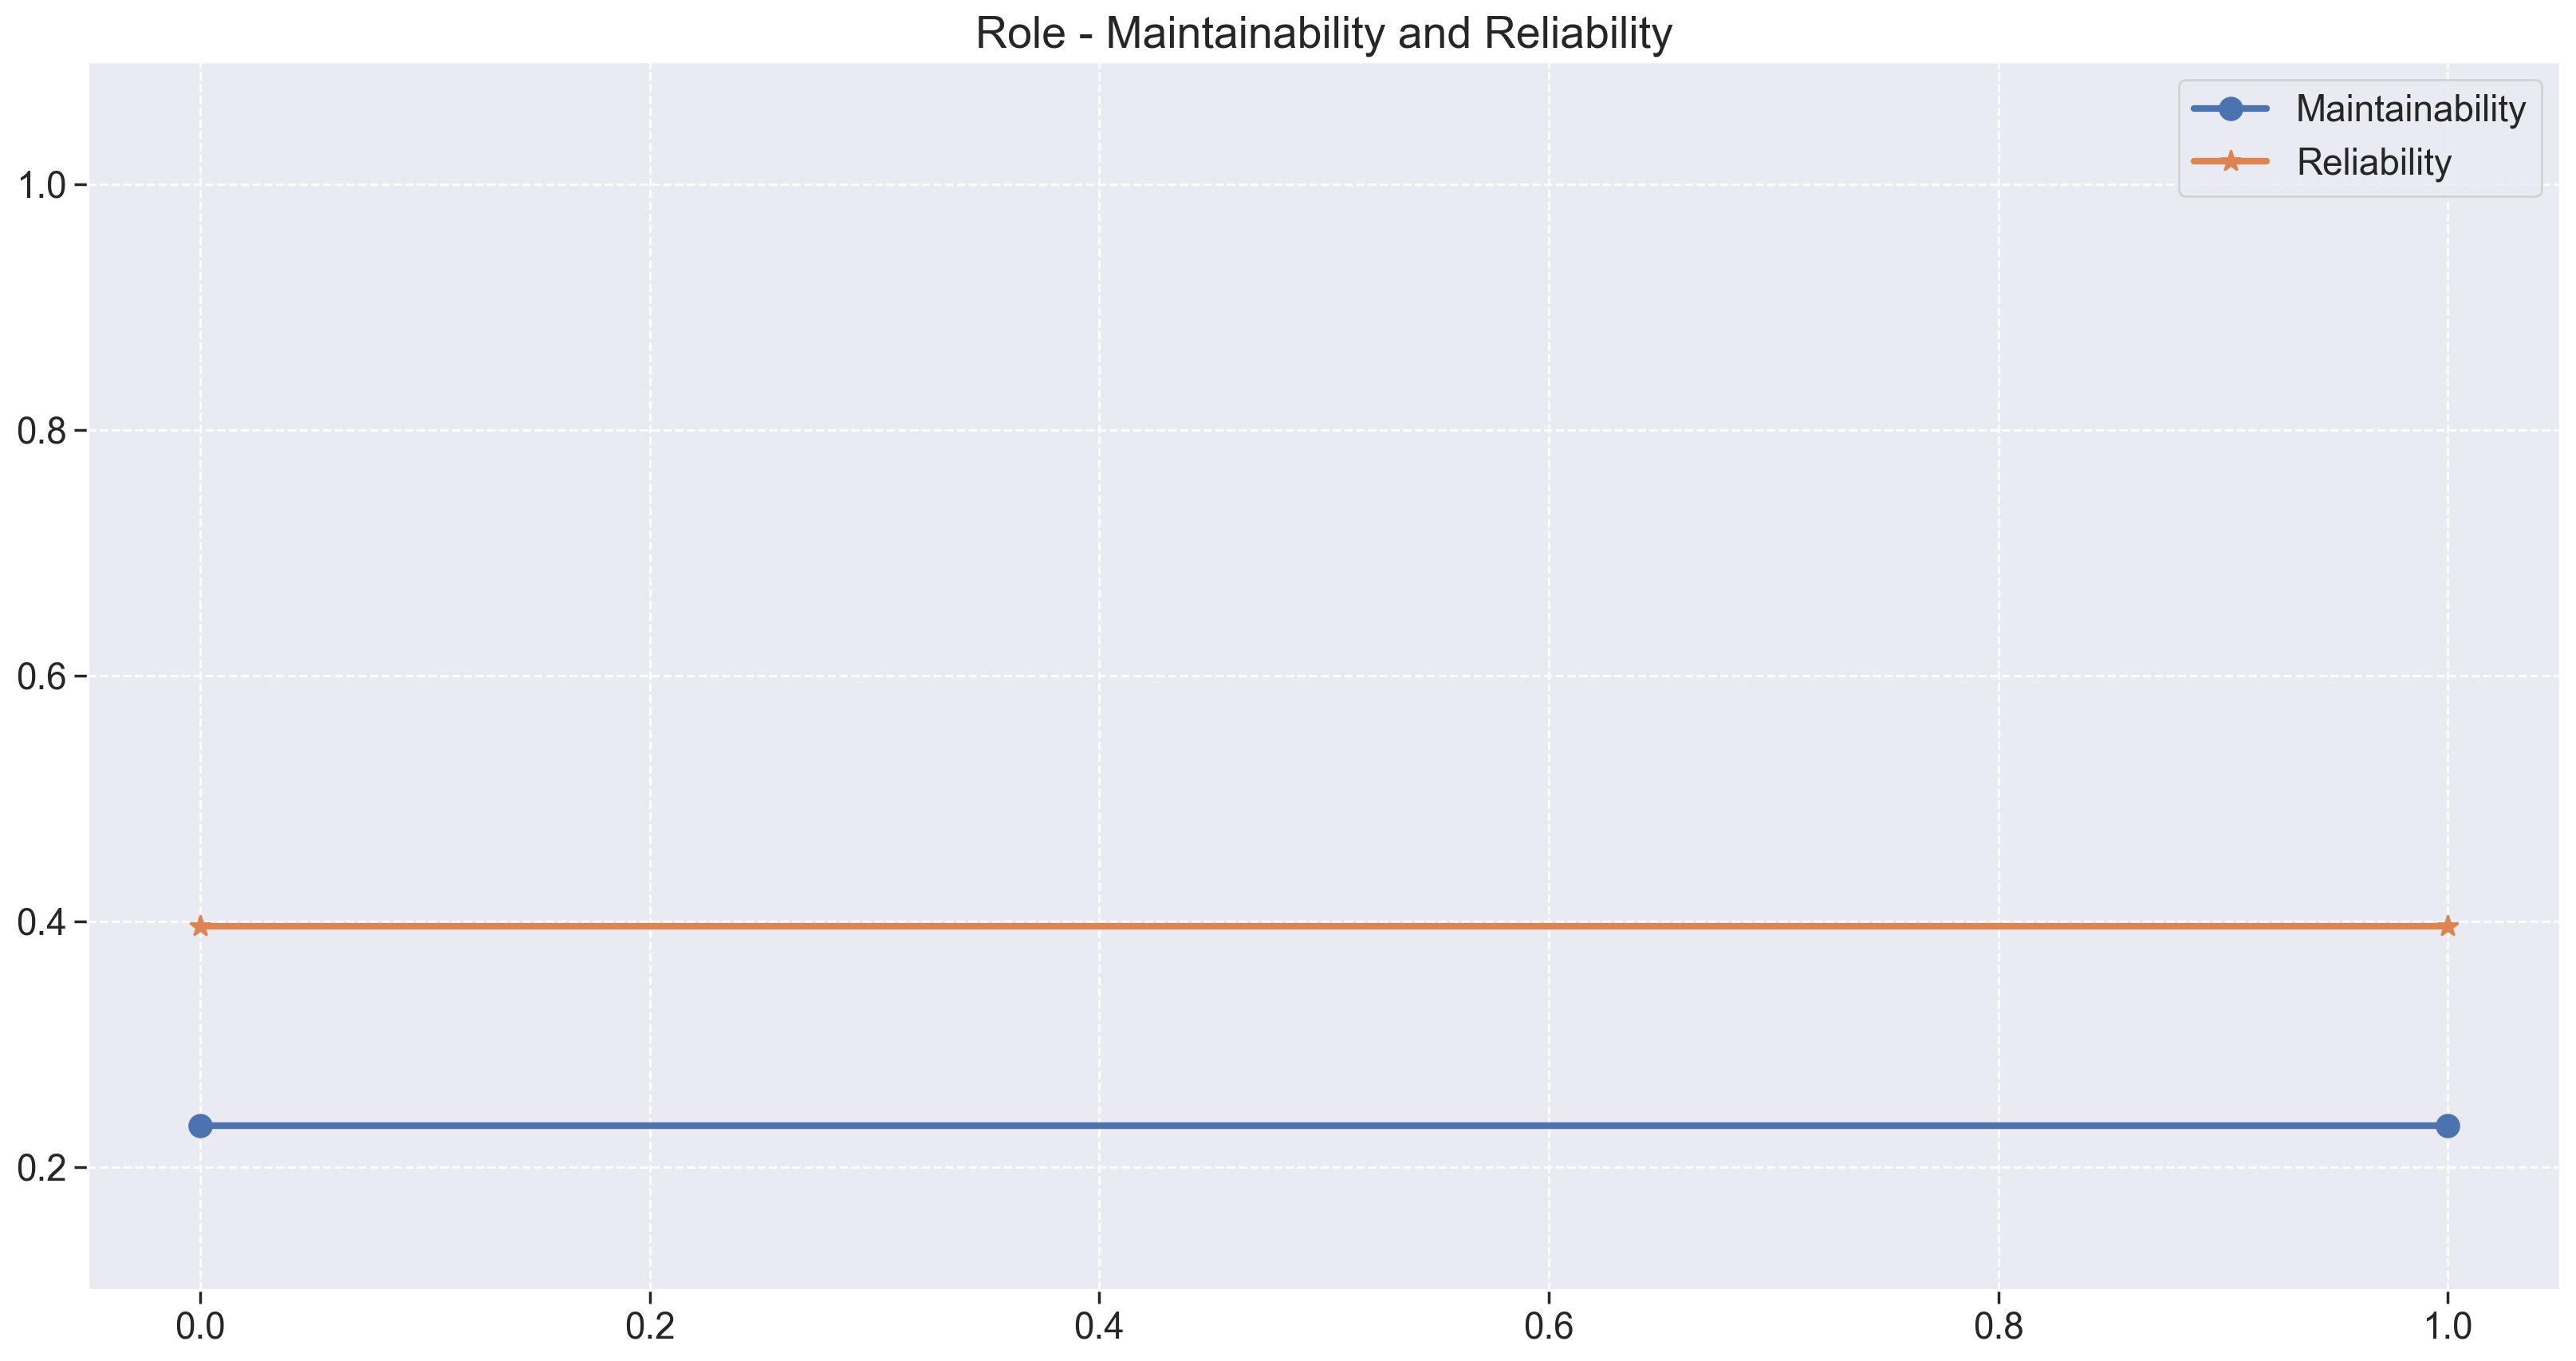

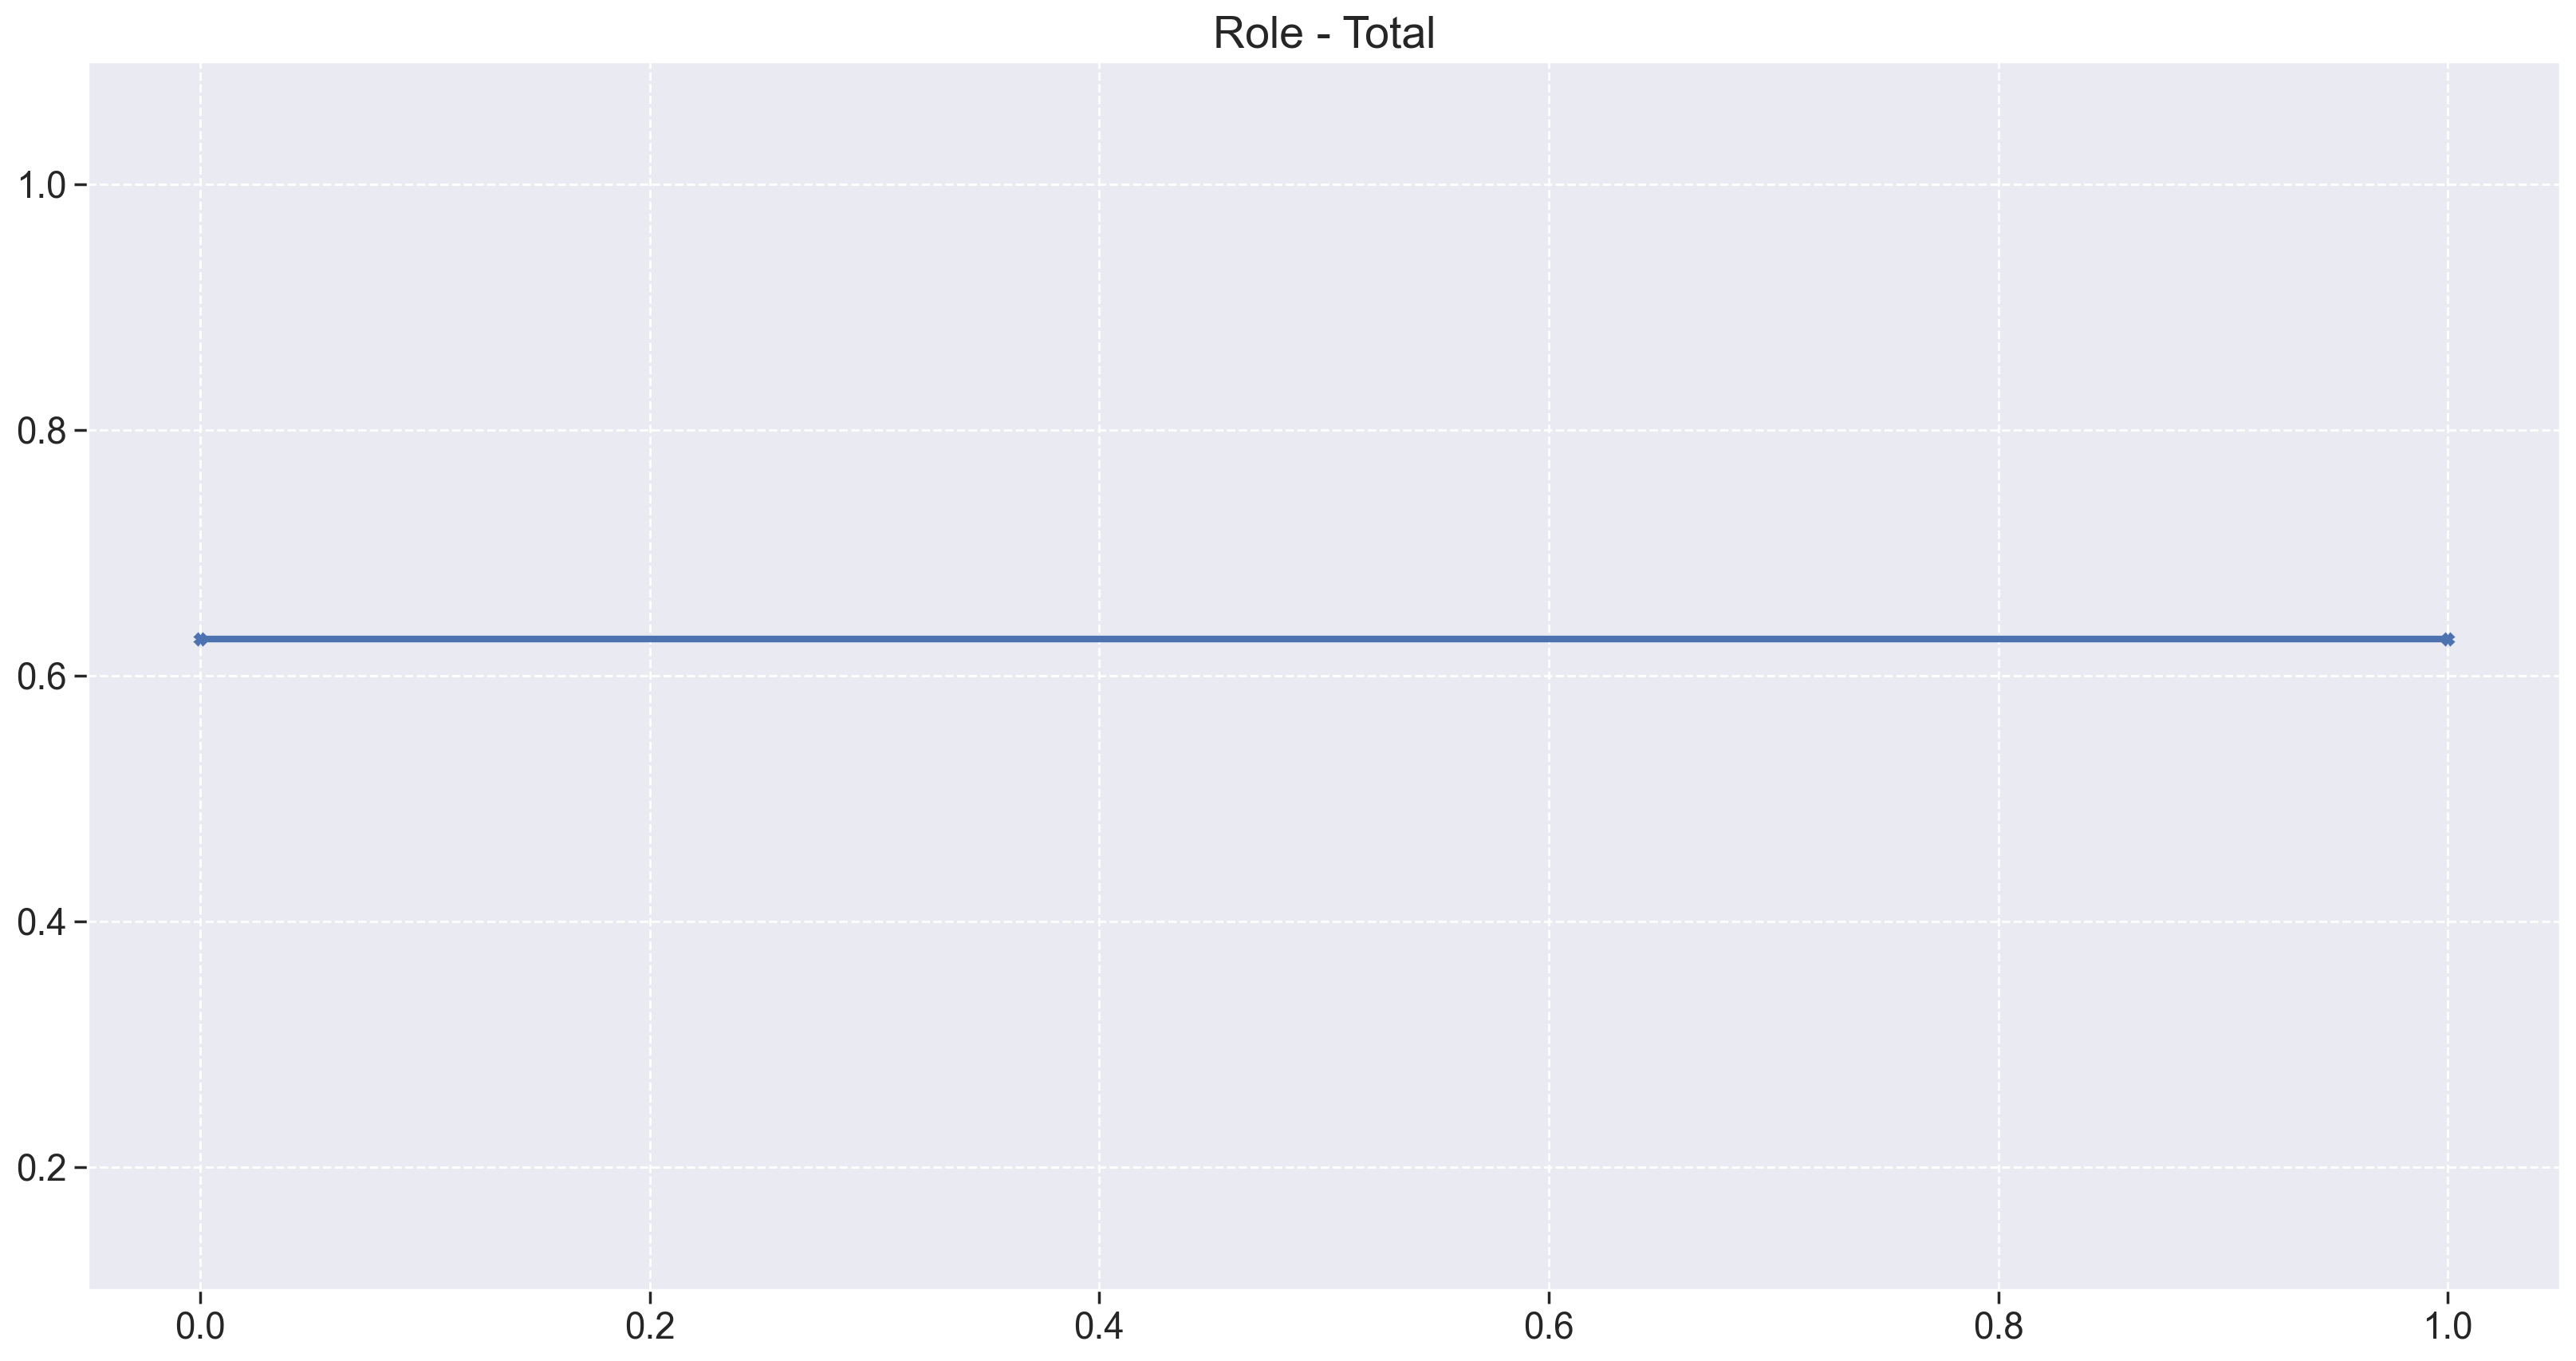

Unit
Maintainability Stats
    mean     mode   median  std  var      min      max
0.235714 0.235714 0.235714  0.0  0.0 0.235714 0.235714
Reliability Stats
    mean     mode   median  std  var      min      max
0.392857 0.392857 0.392857  0.0  0.0 0.392857 0.392857


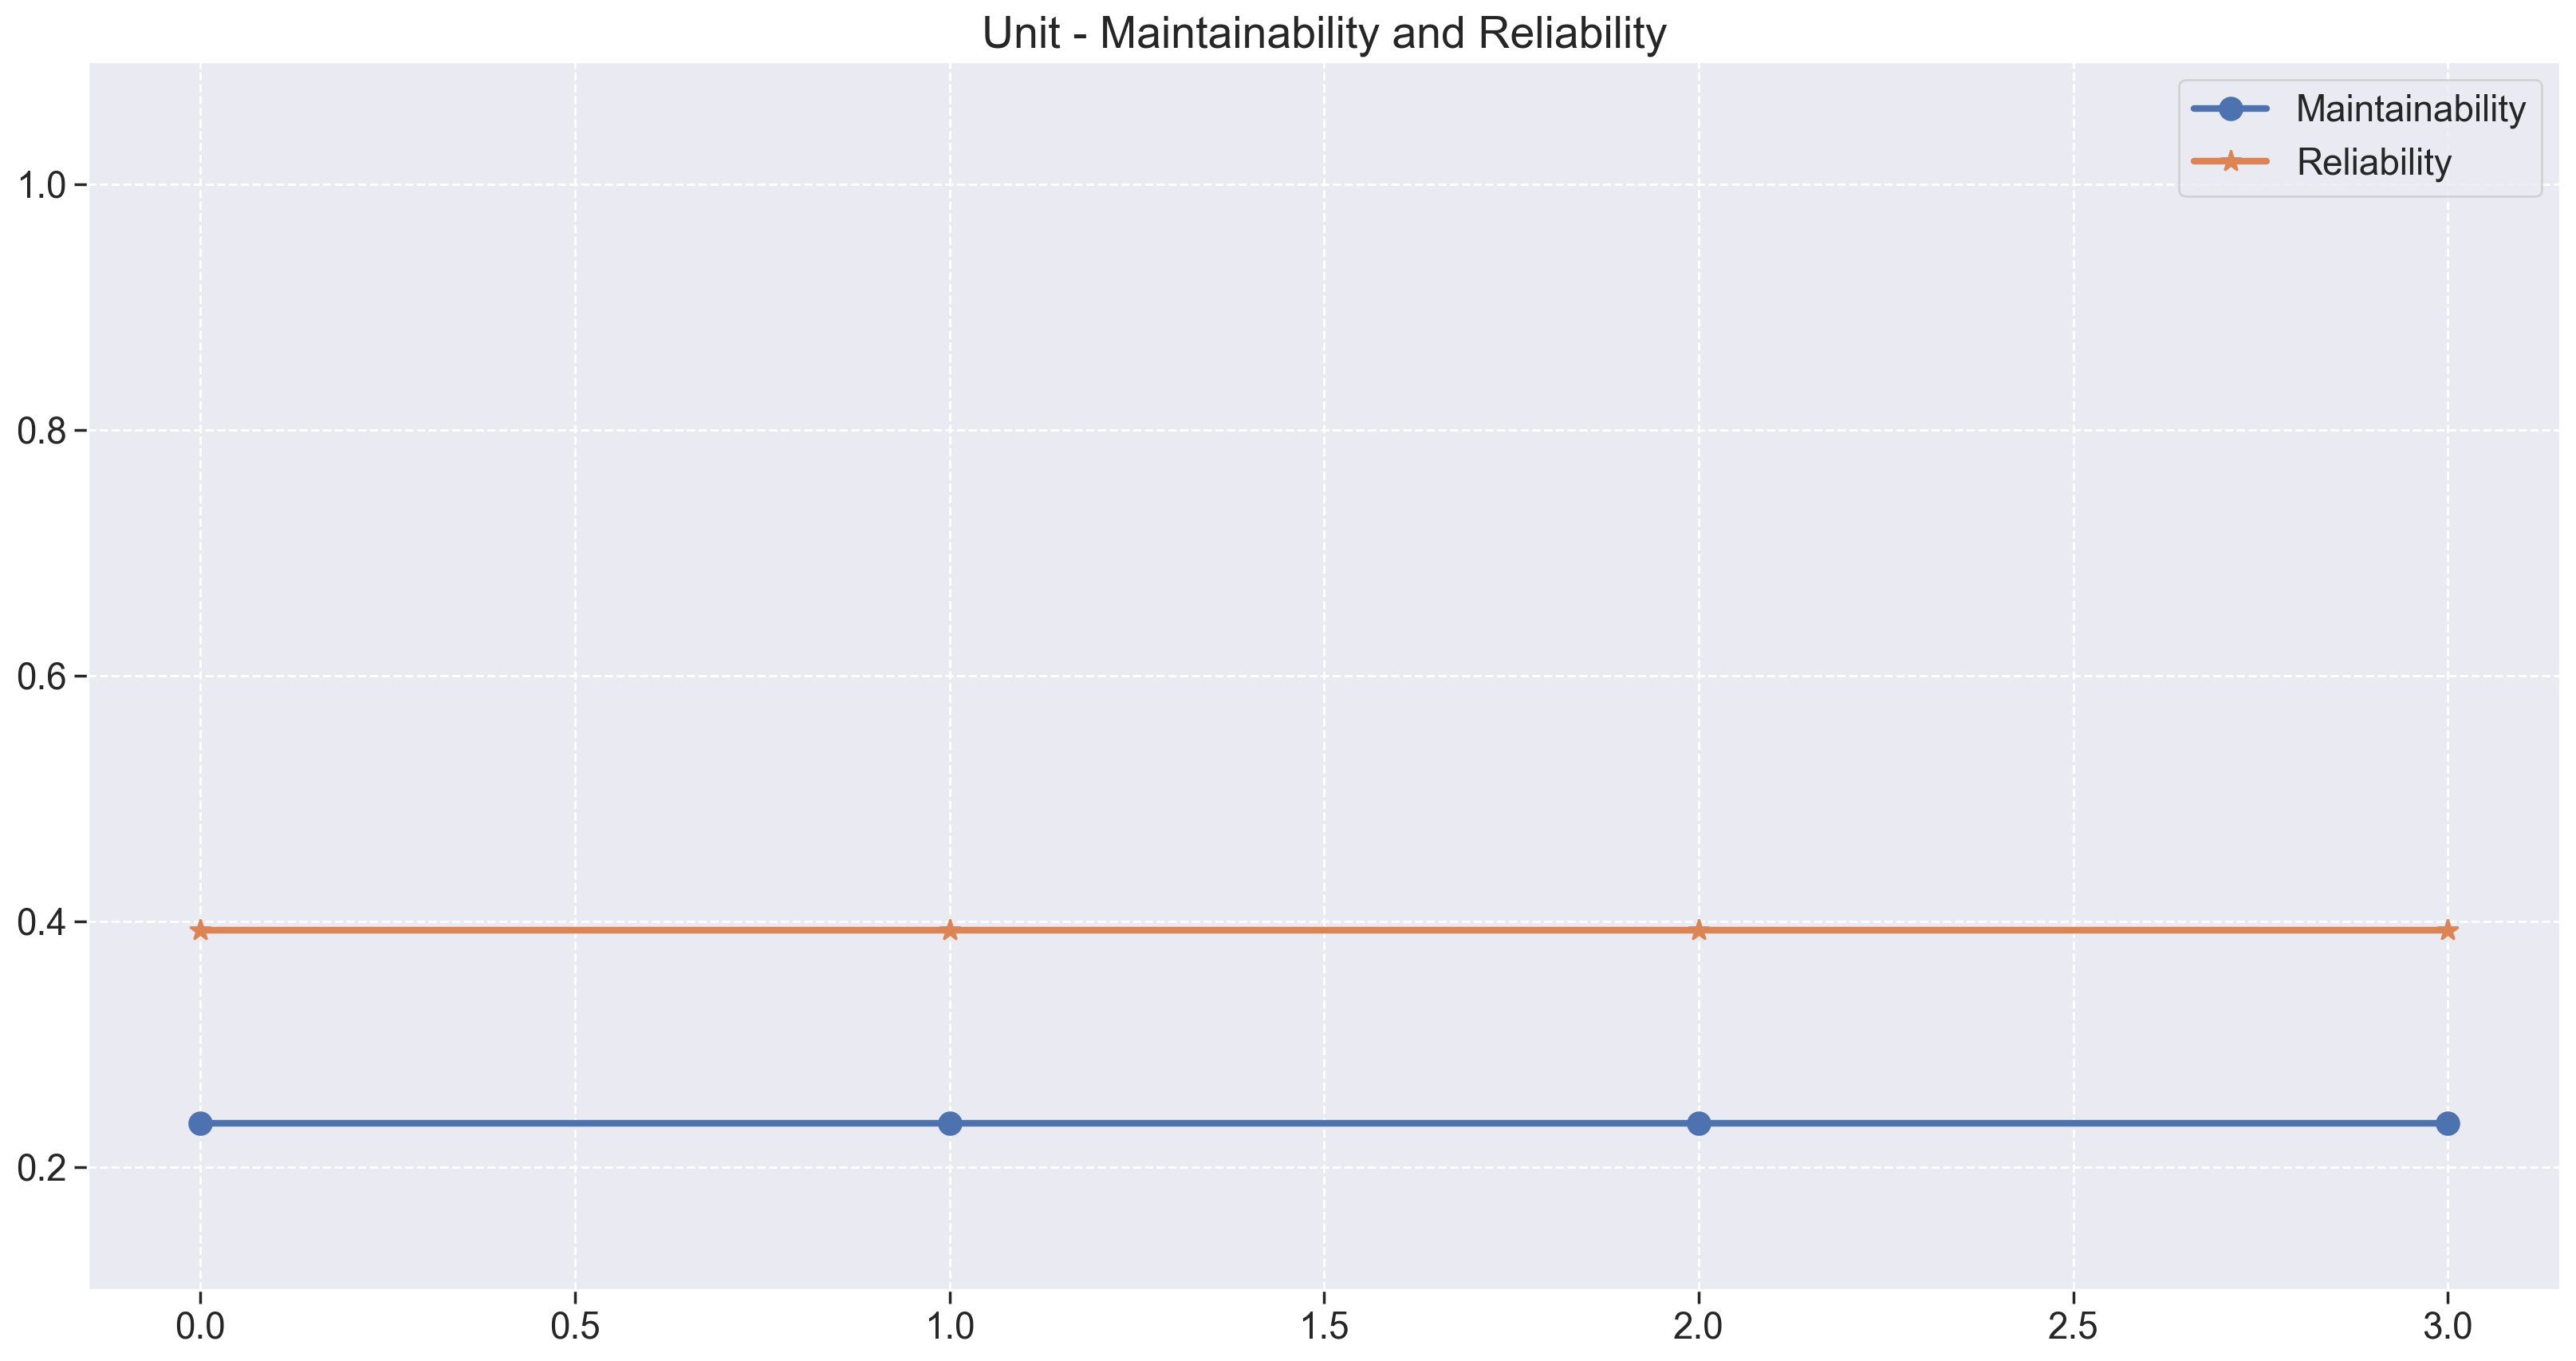

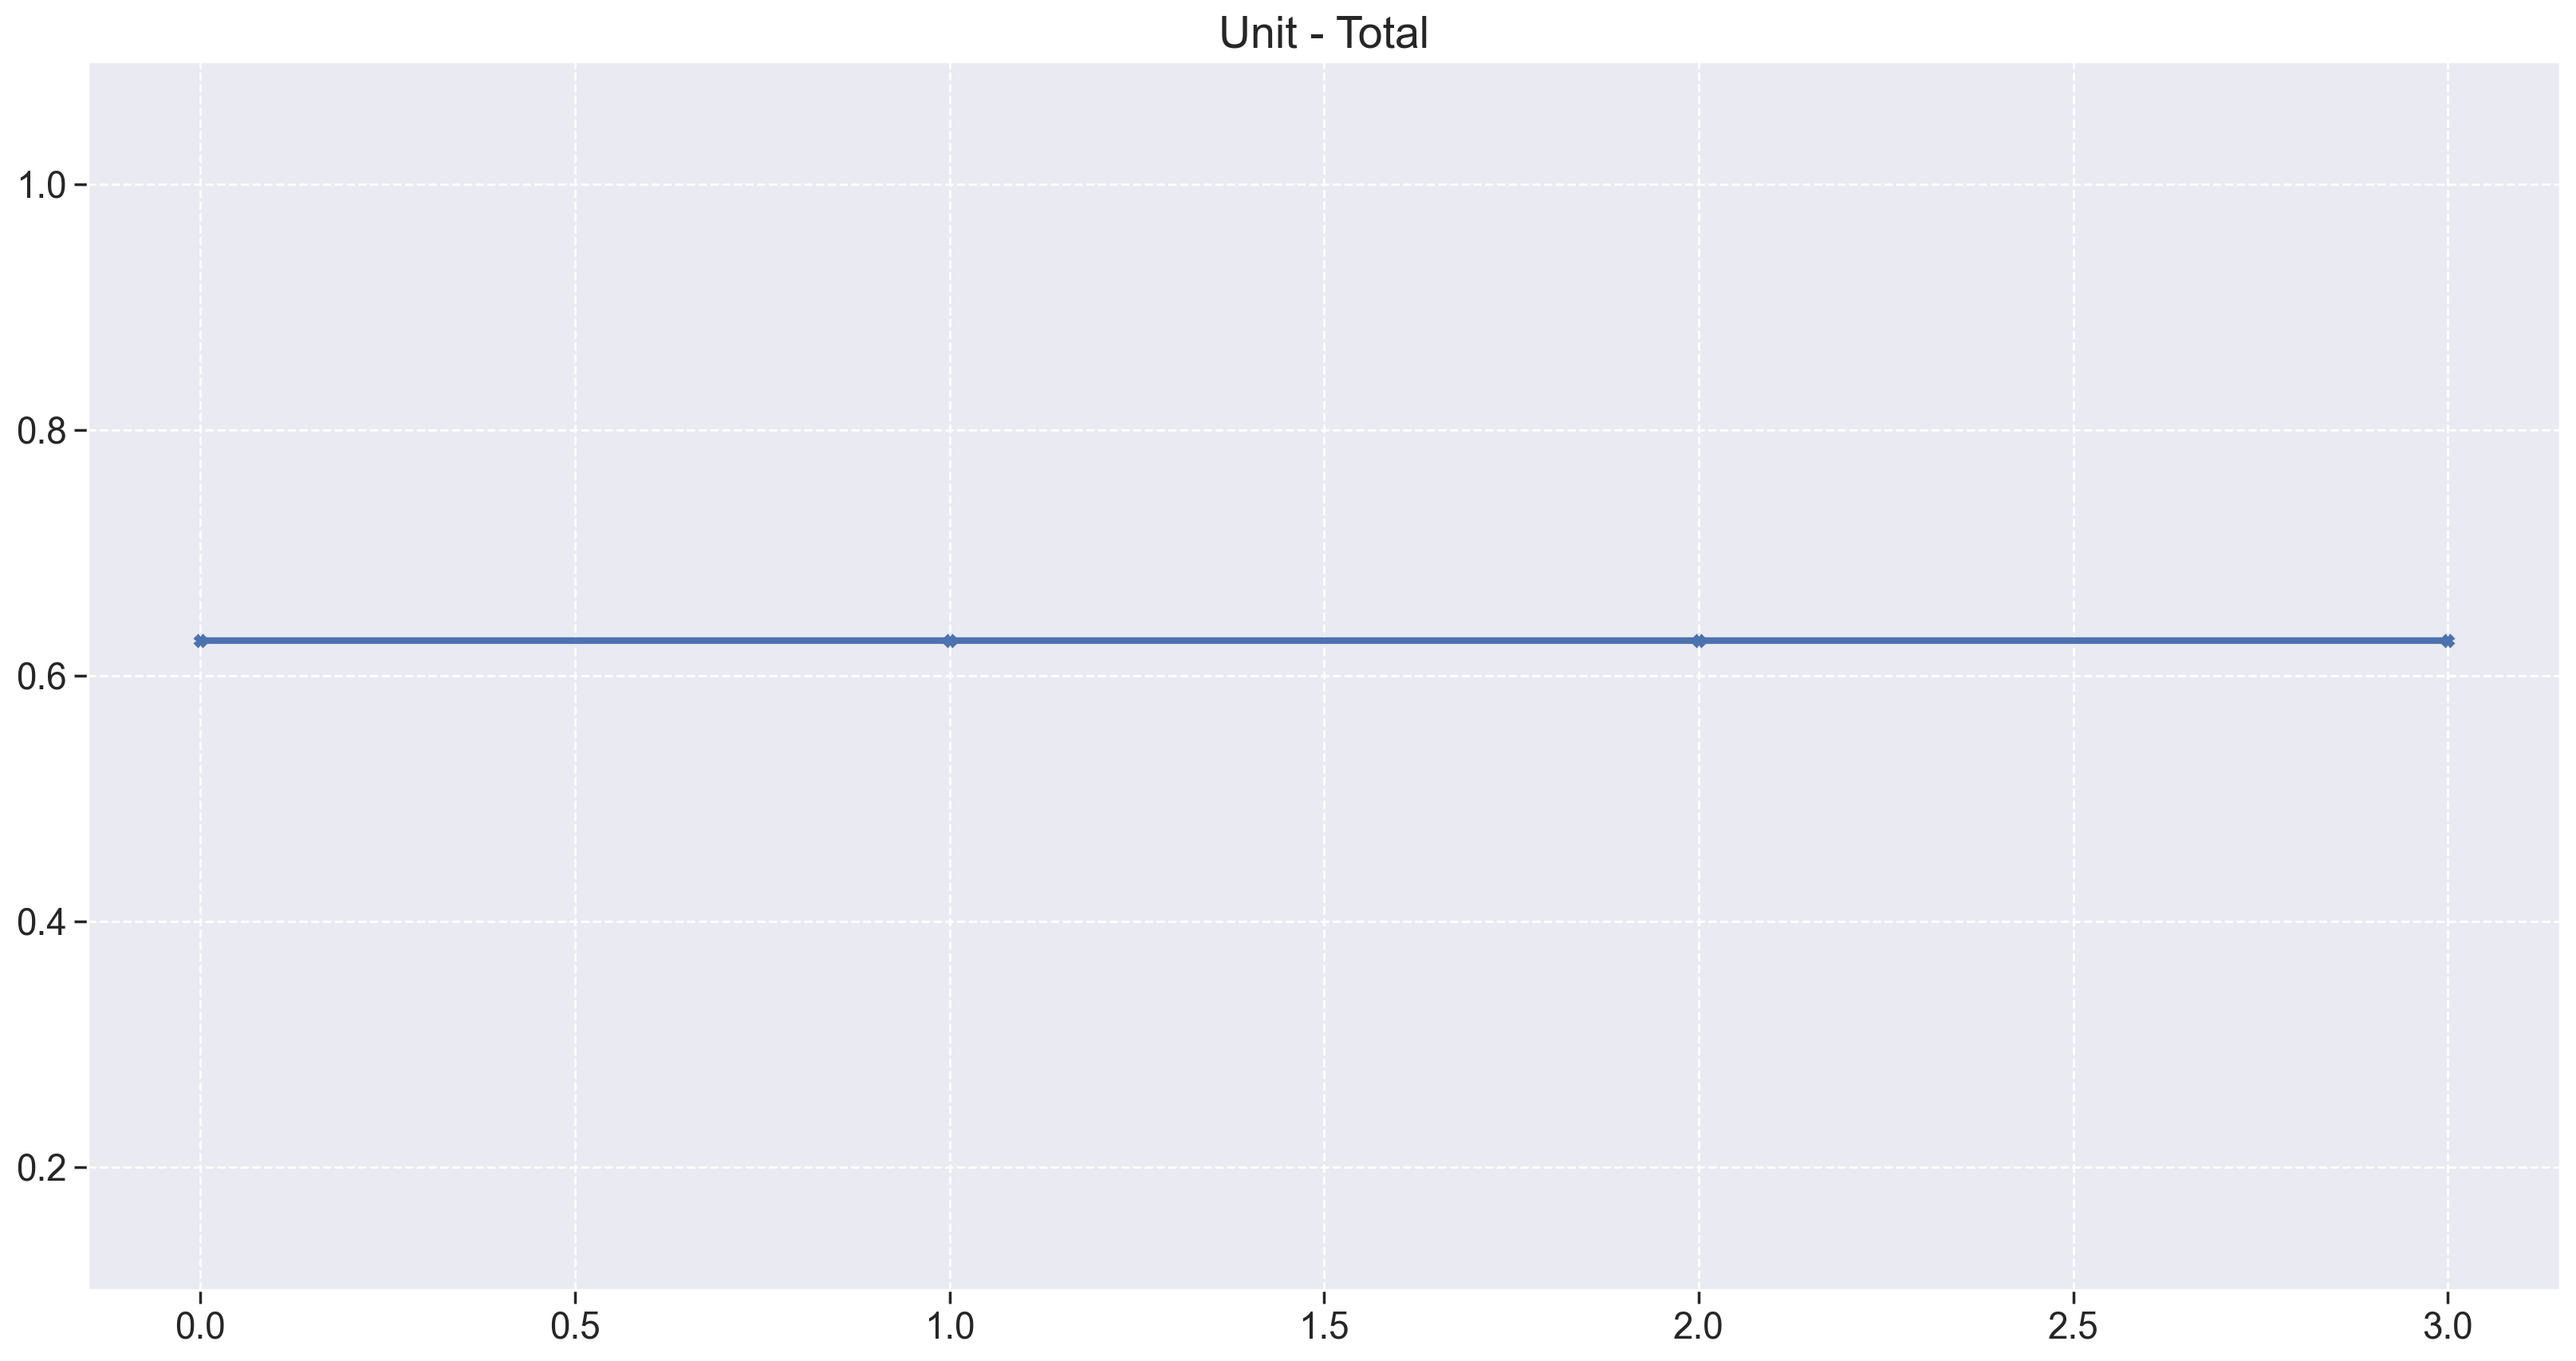

Note
Maintainability Stats
    mean    mode  median    std      var     min      max
0.237794 0.23375 0.23375 0.0107 0.000114 0.23375 0.262059
Reliability Stats
    mean  mode  median      std     var      min   max
0.371849 0.375   0.375 0.008337 0.00007 0.352941 0.375


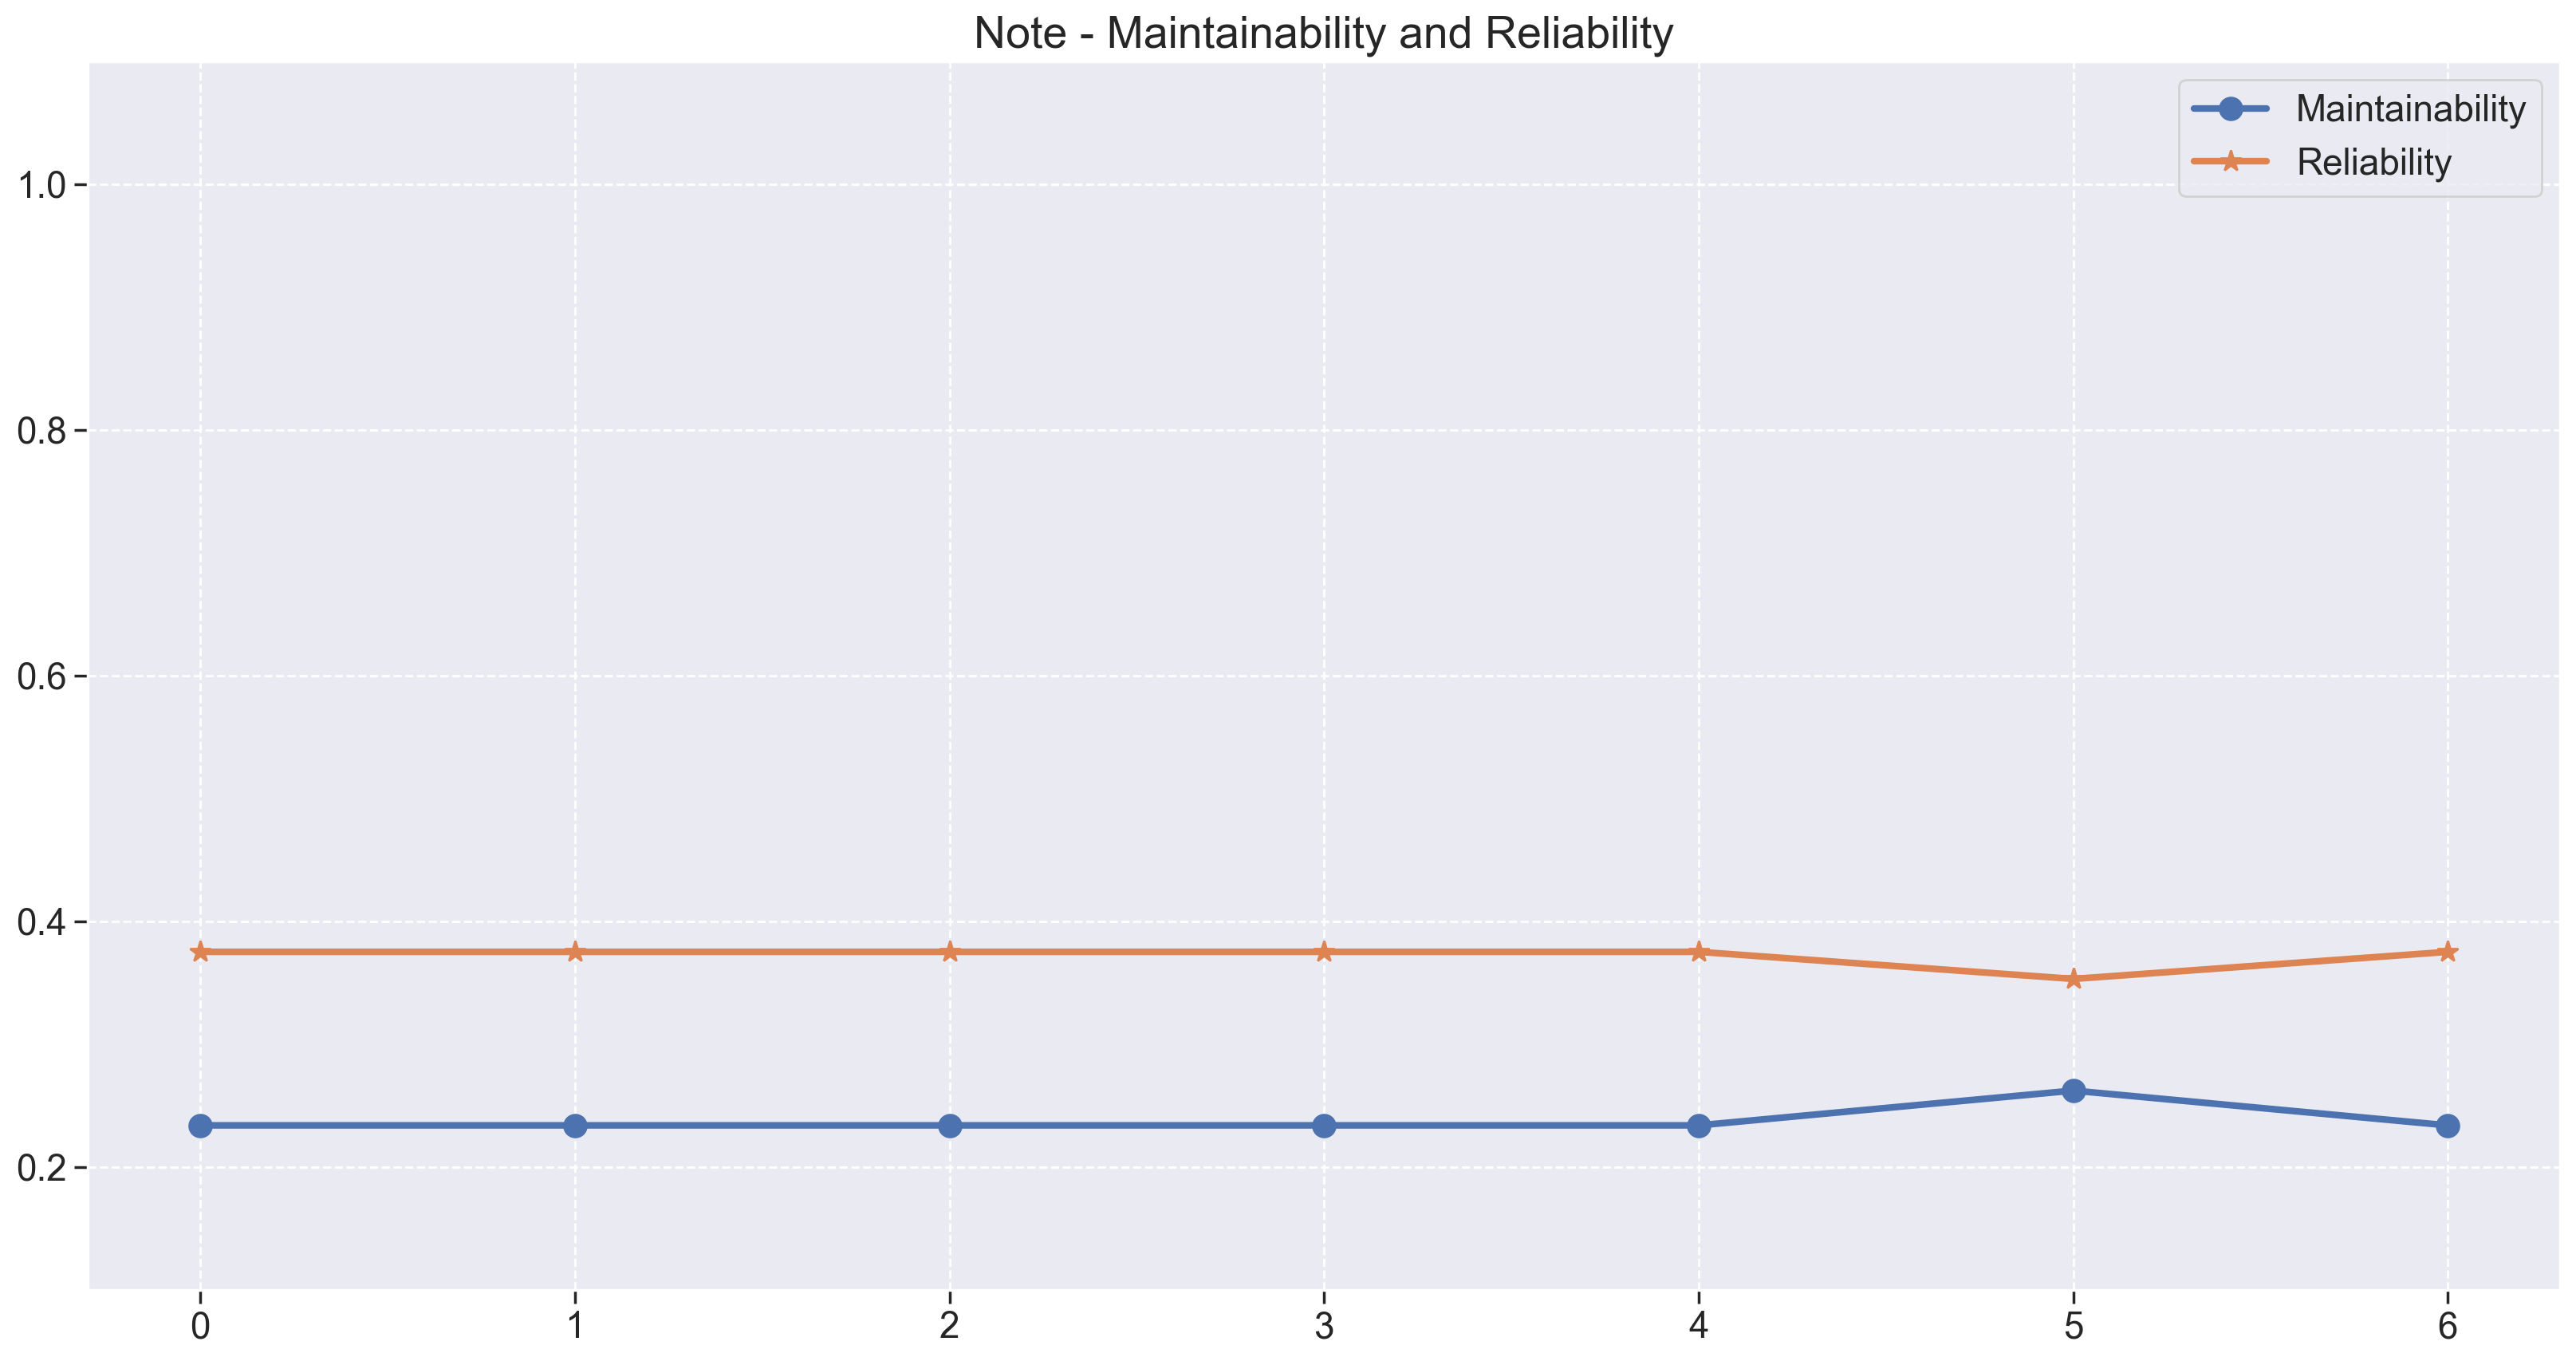

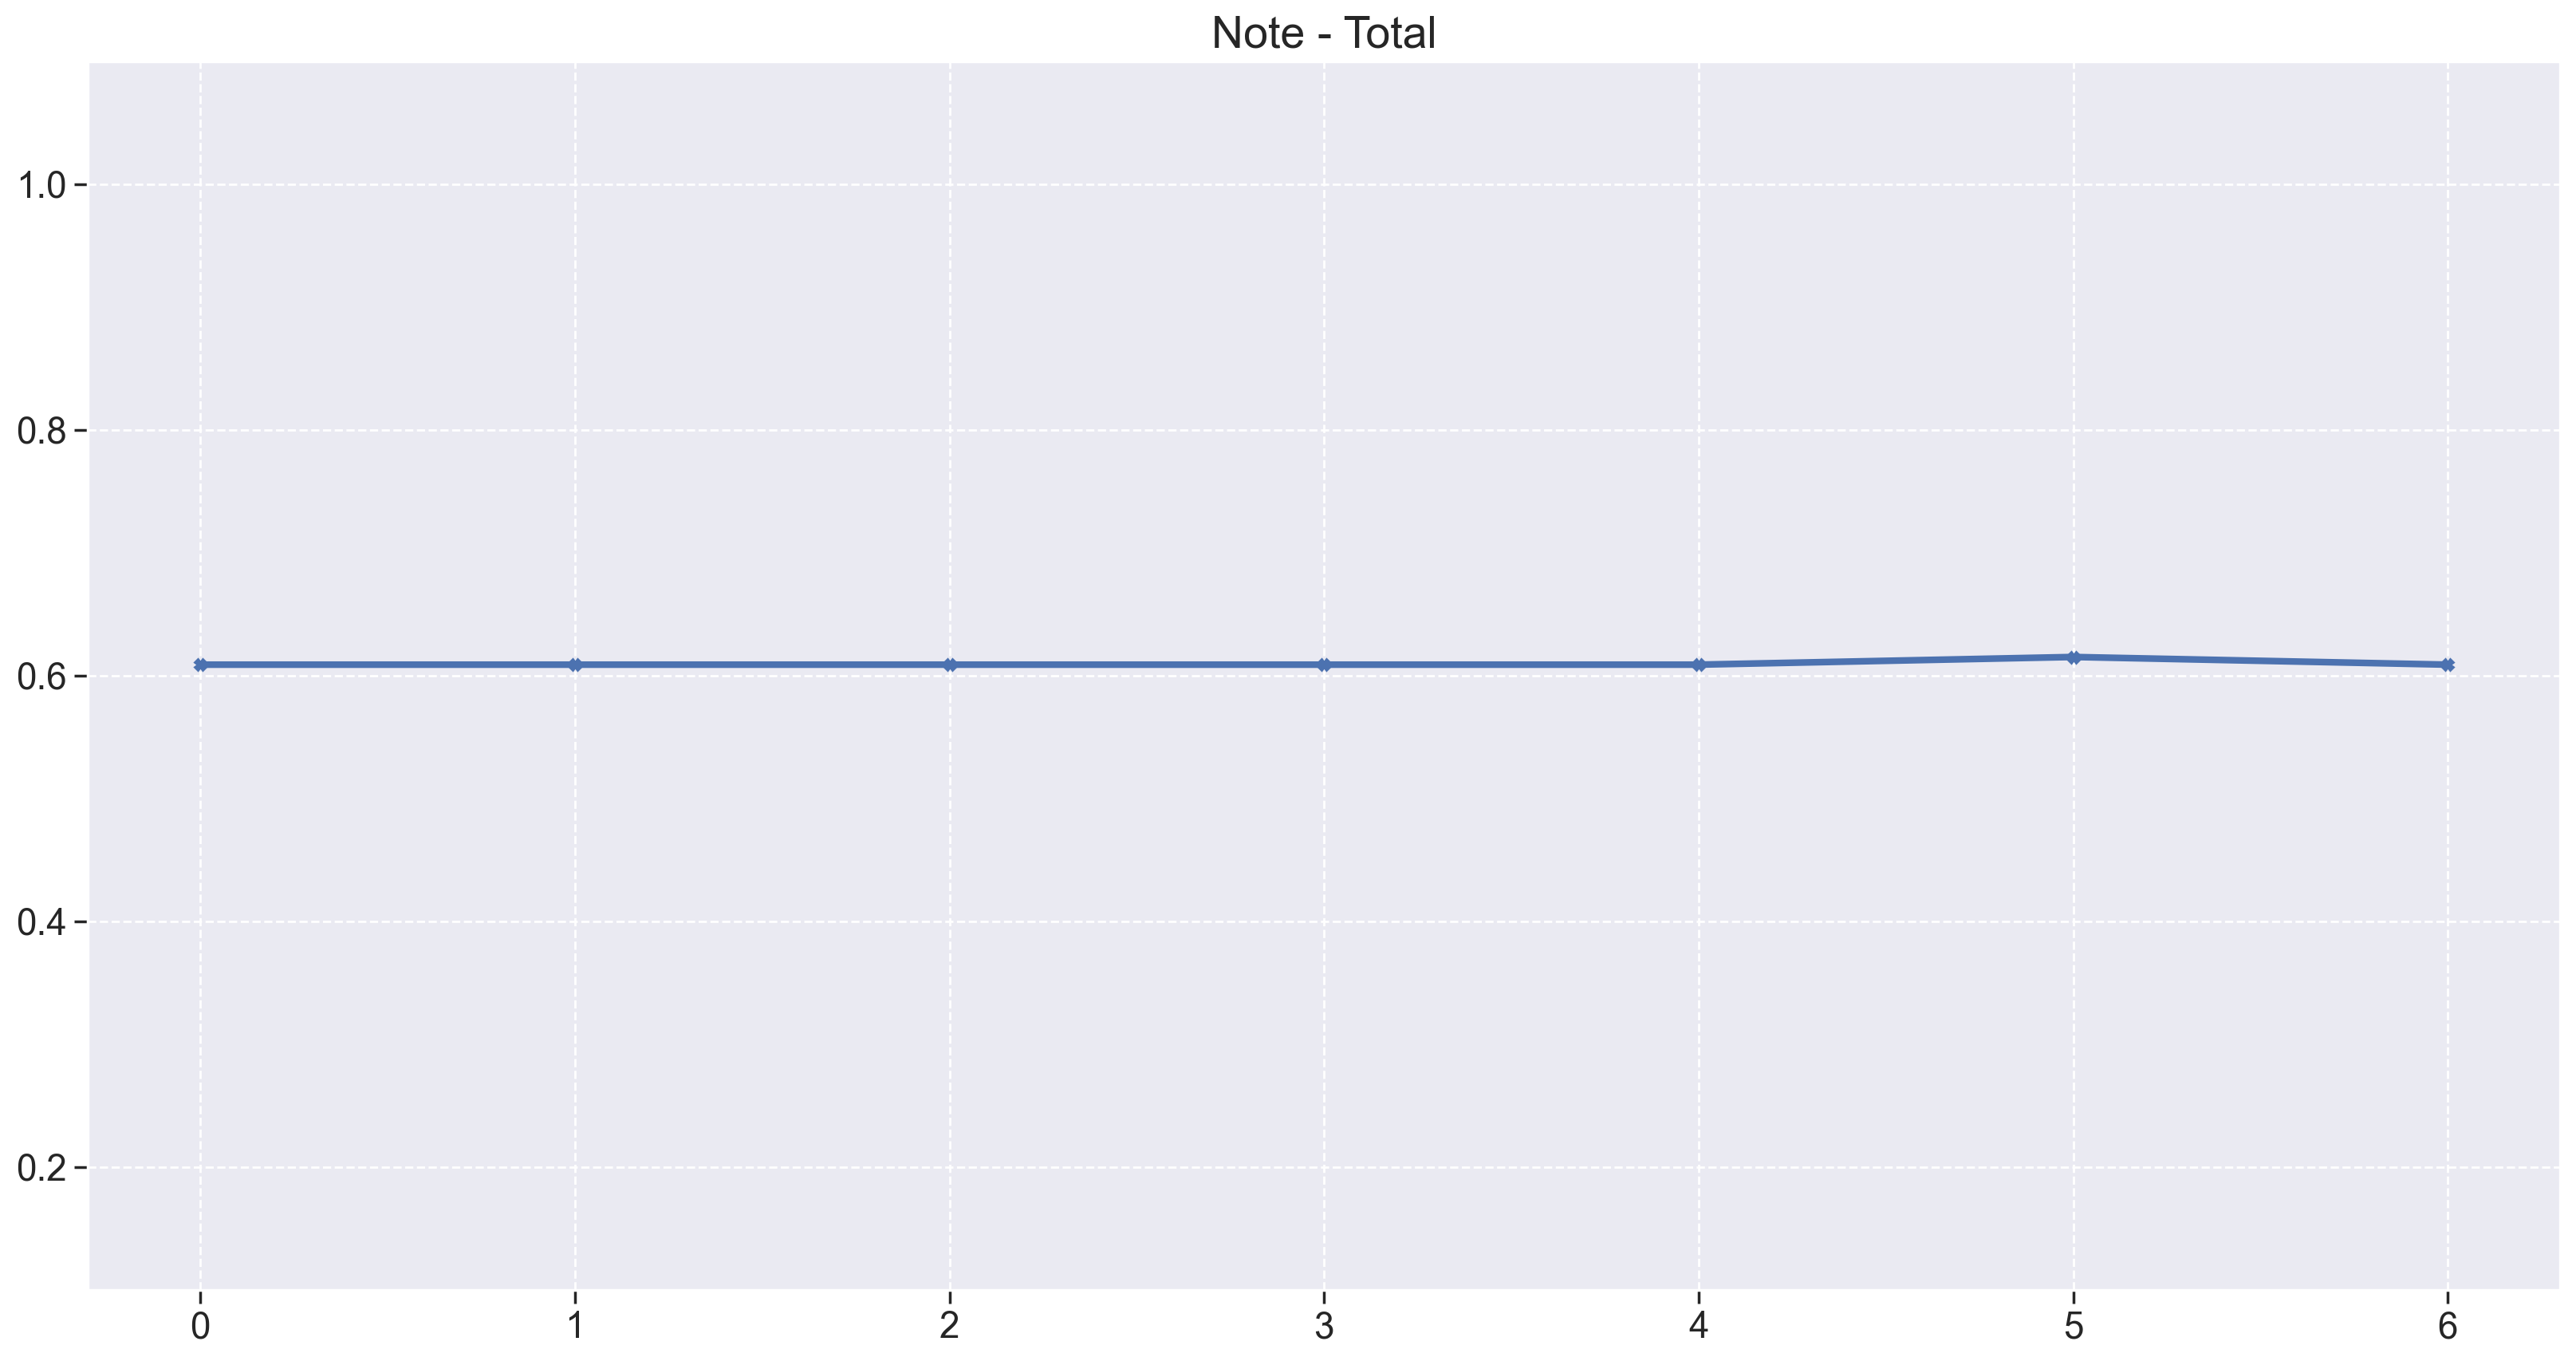

Front
Maintainability Stats
 mean  mode  median  std  var  min  max
  0.0   0.0     0.0  0.0  0.0  0.0  0.0
Reliability Stats
 mean  mode  median  std  var  min  max
 0.25  0.25    0.25  0.0  0.0 0.25 0.25


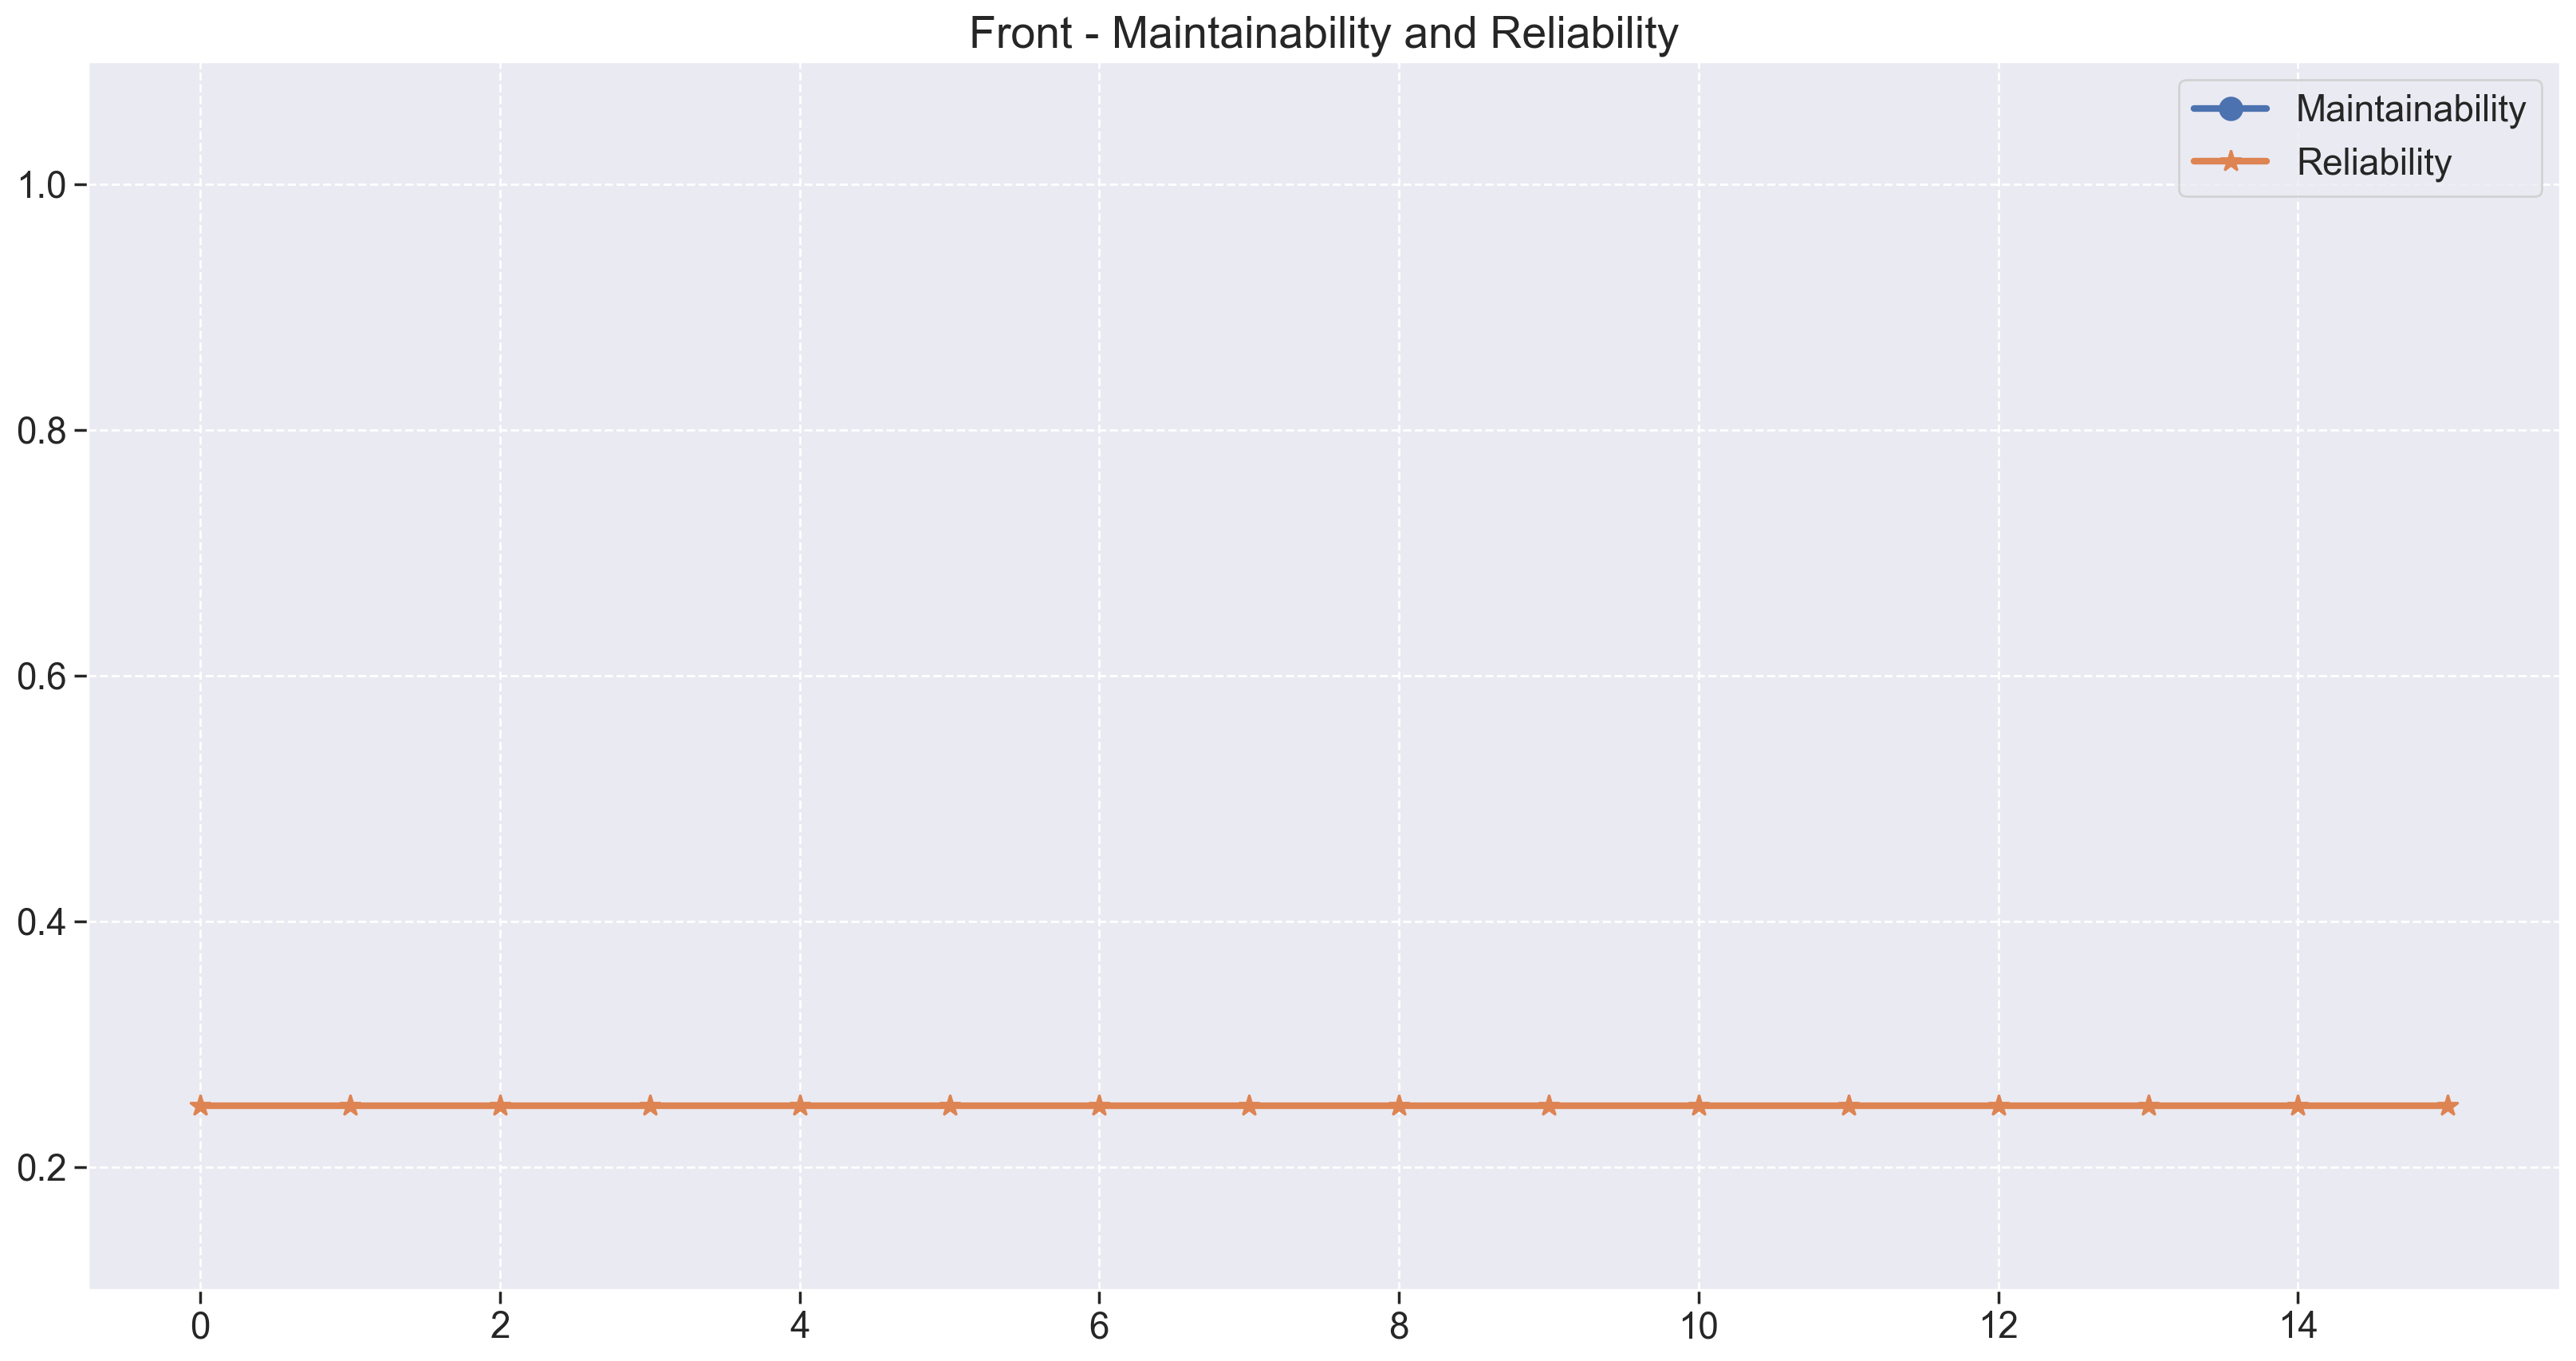

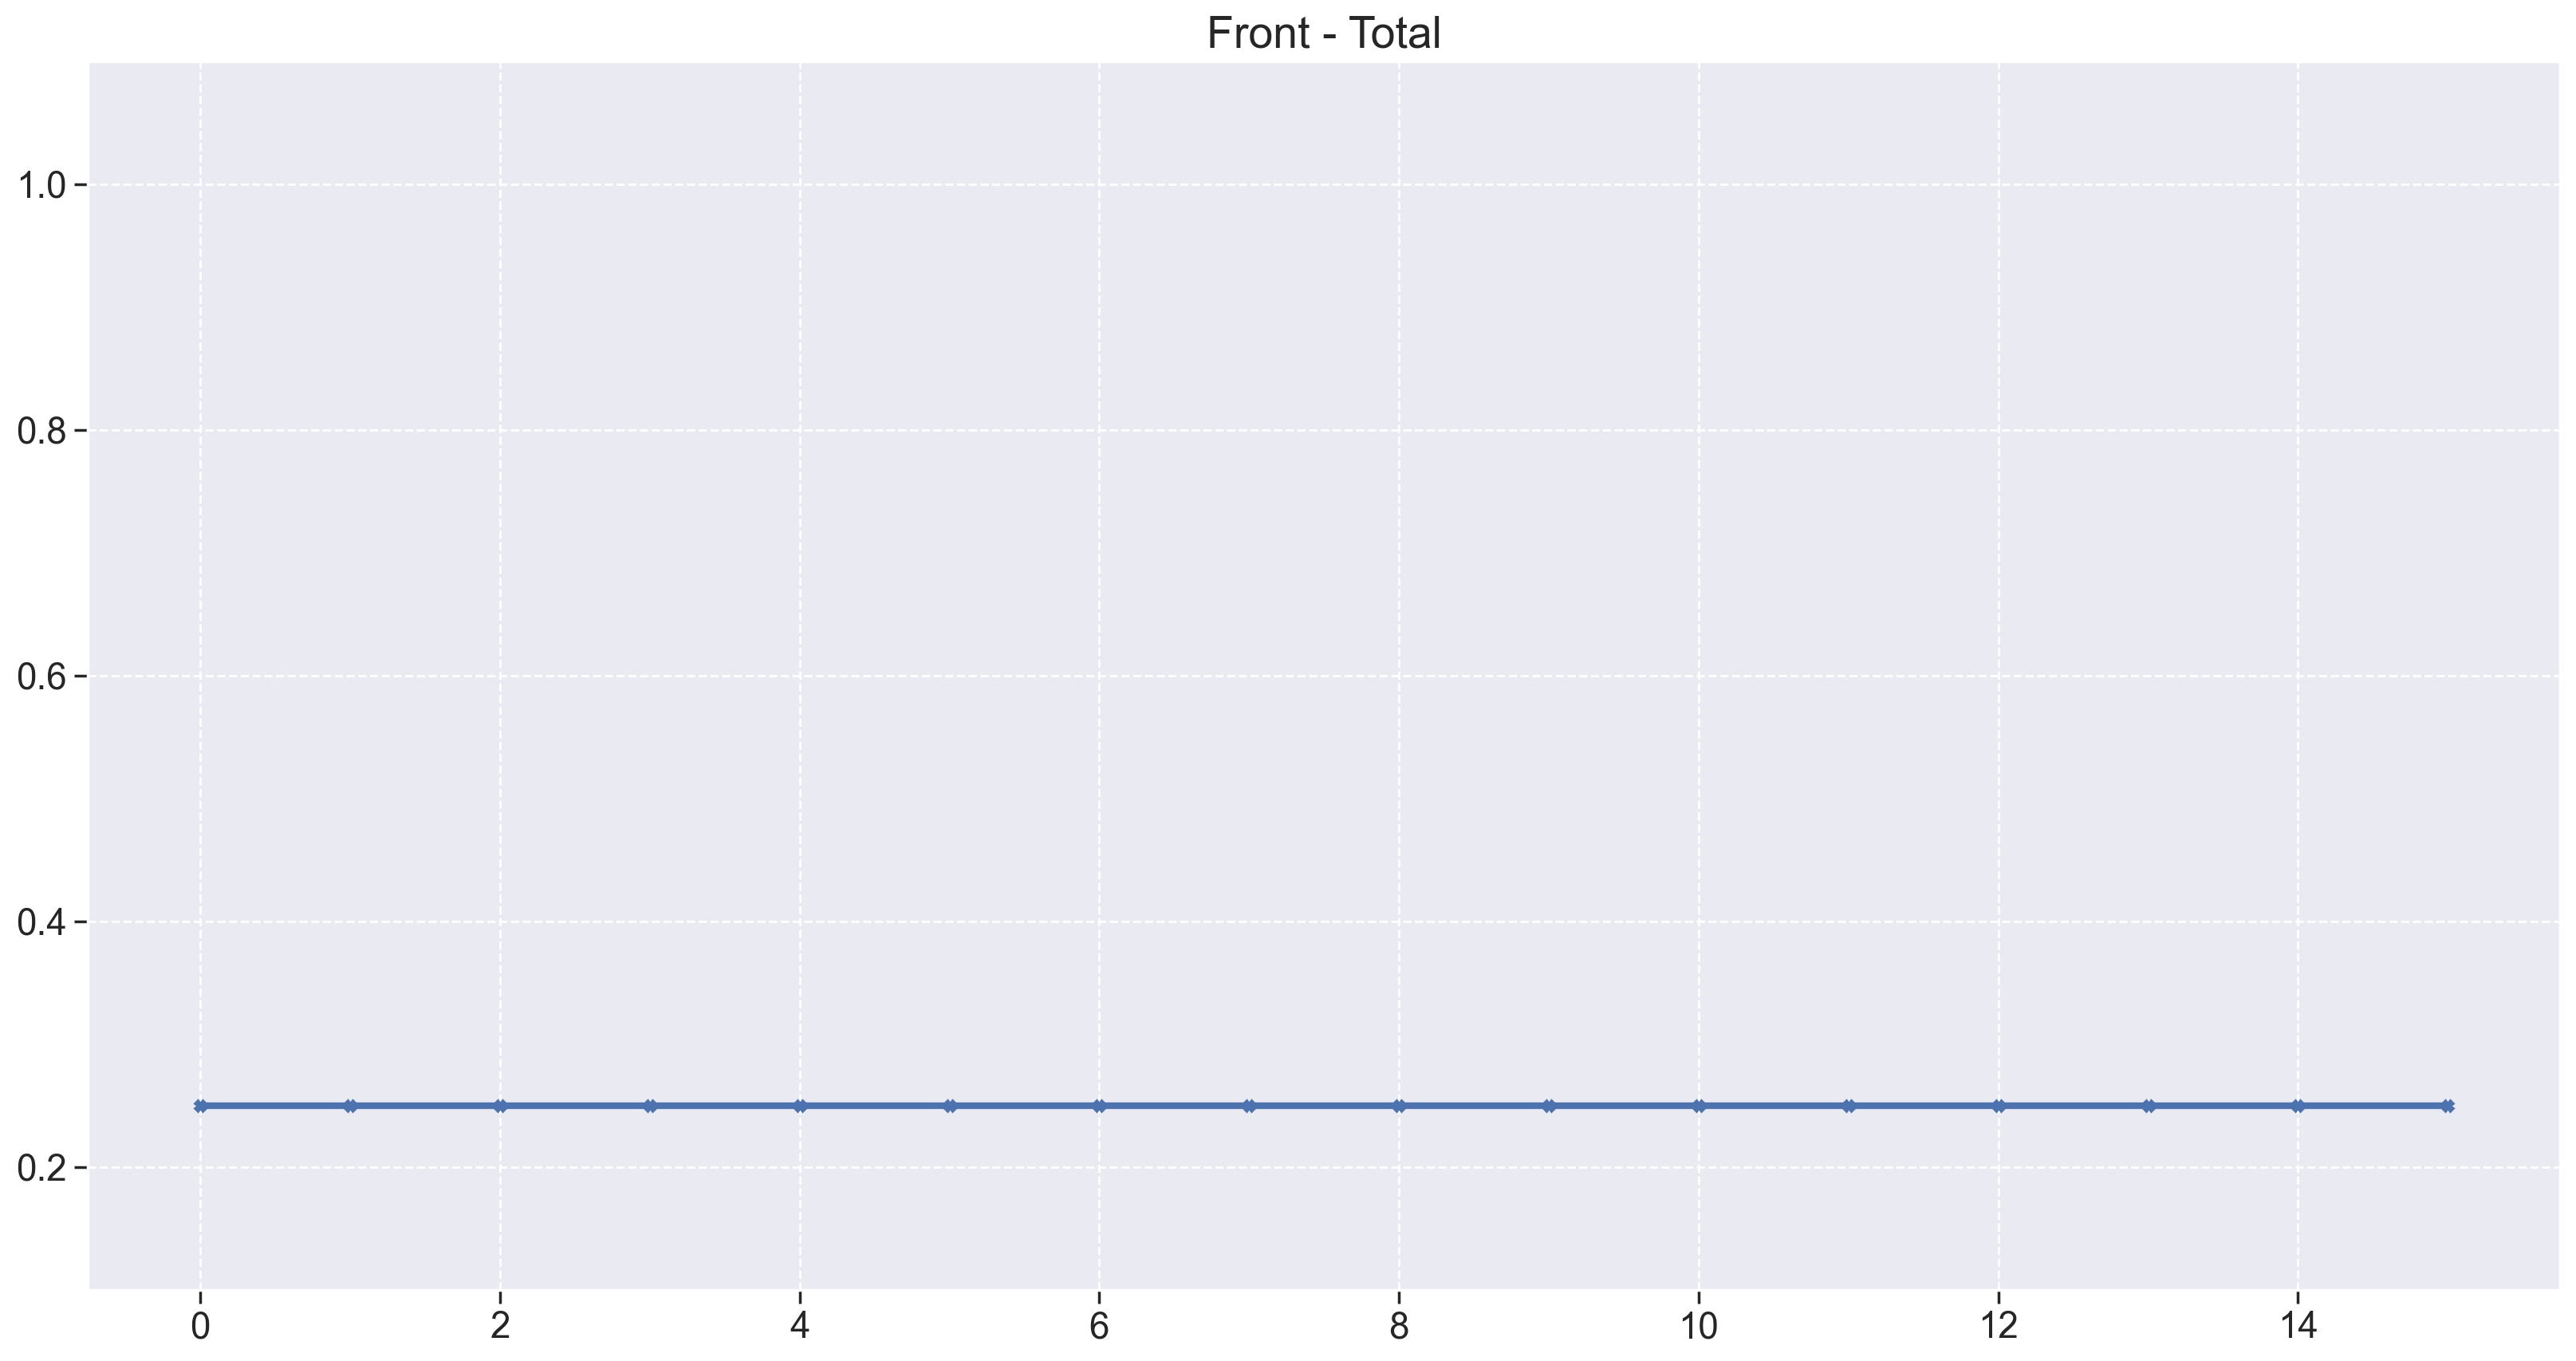

In [30]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

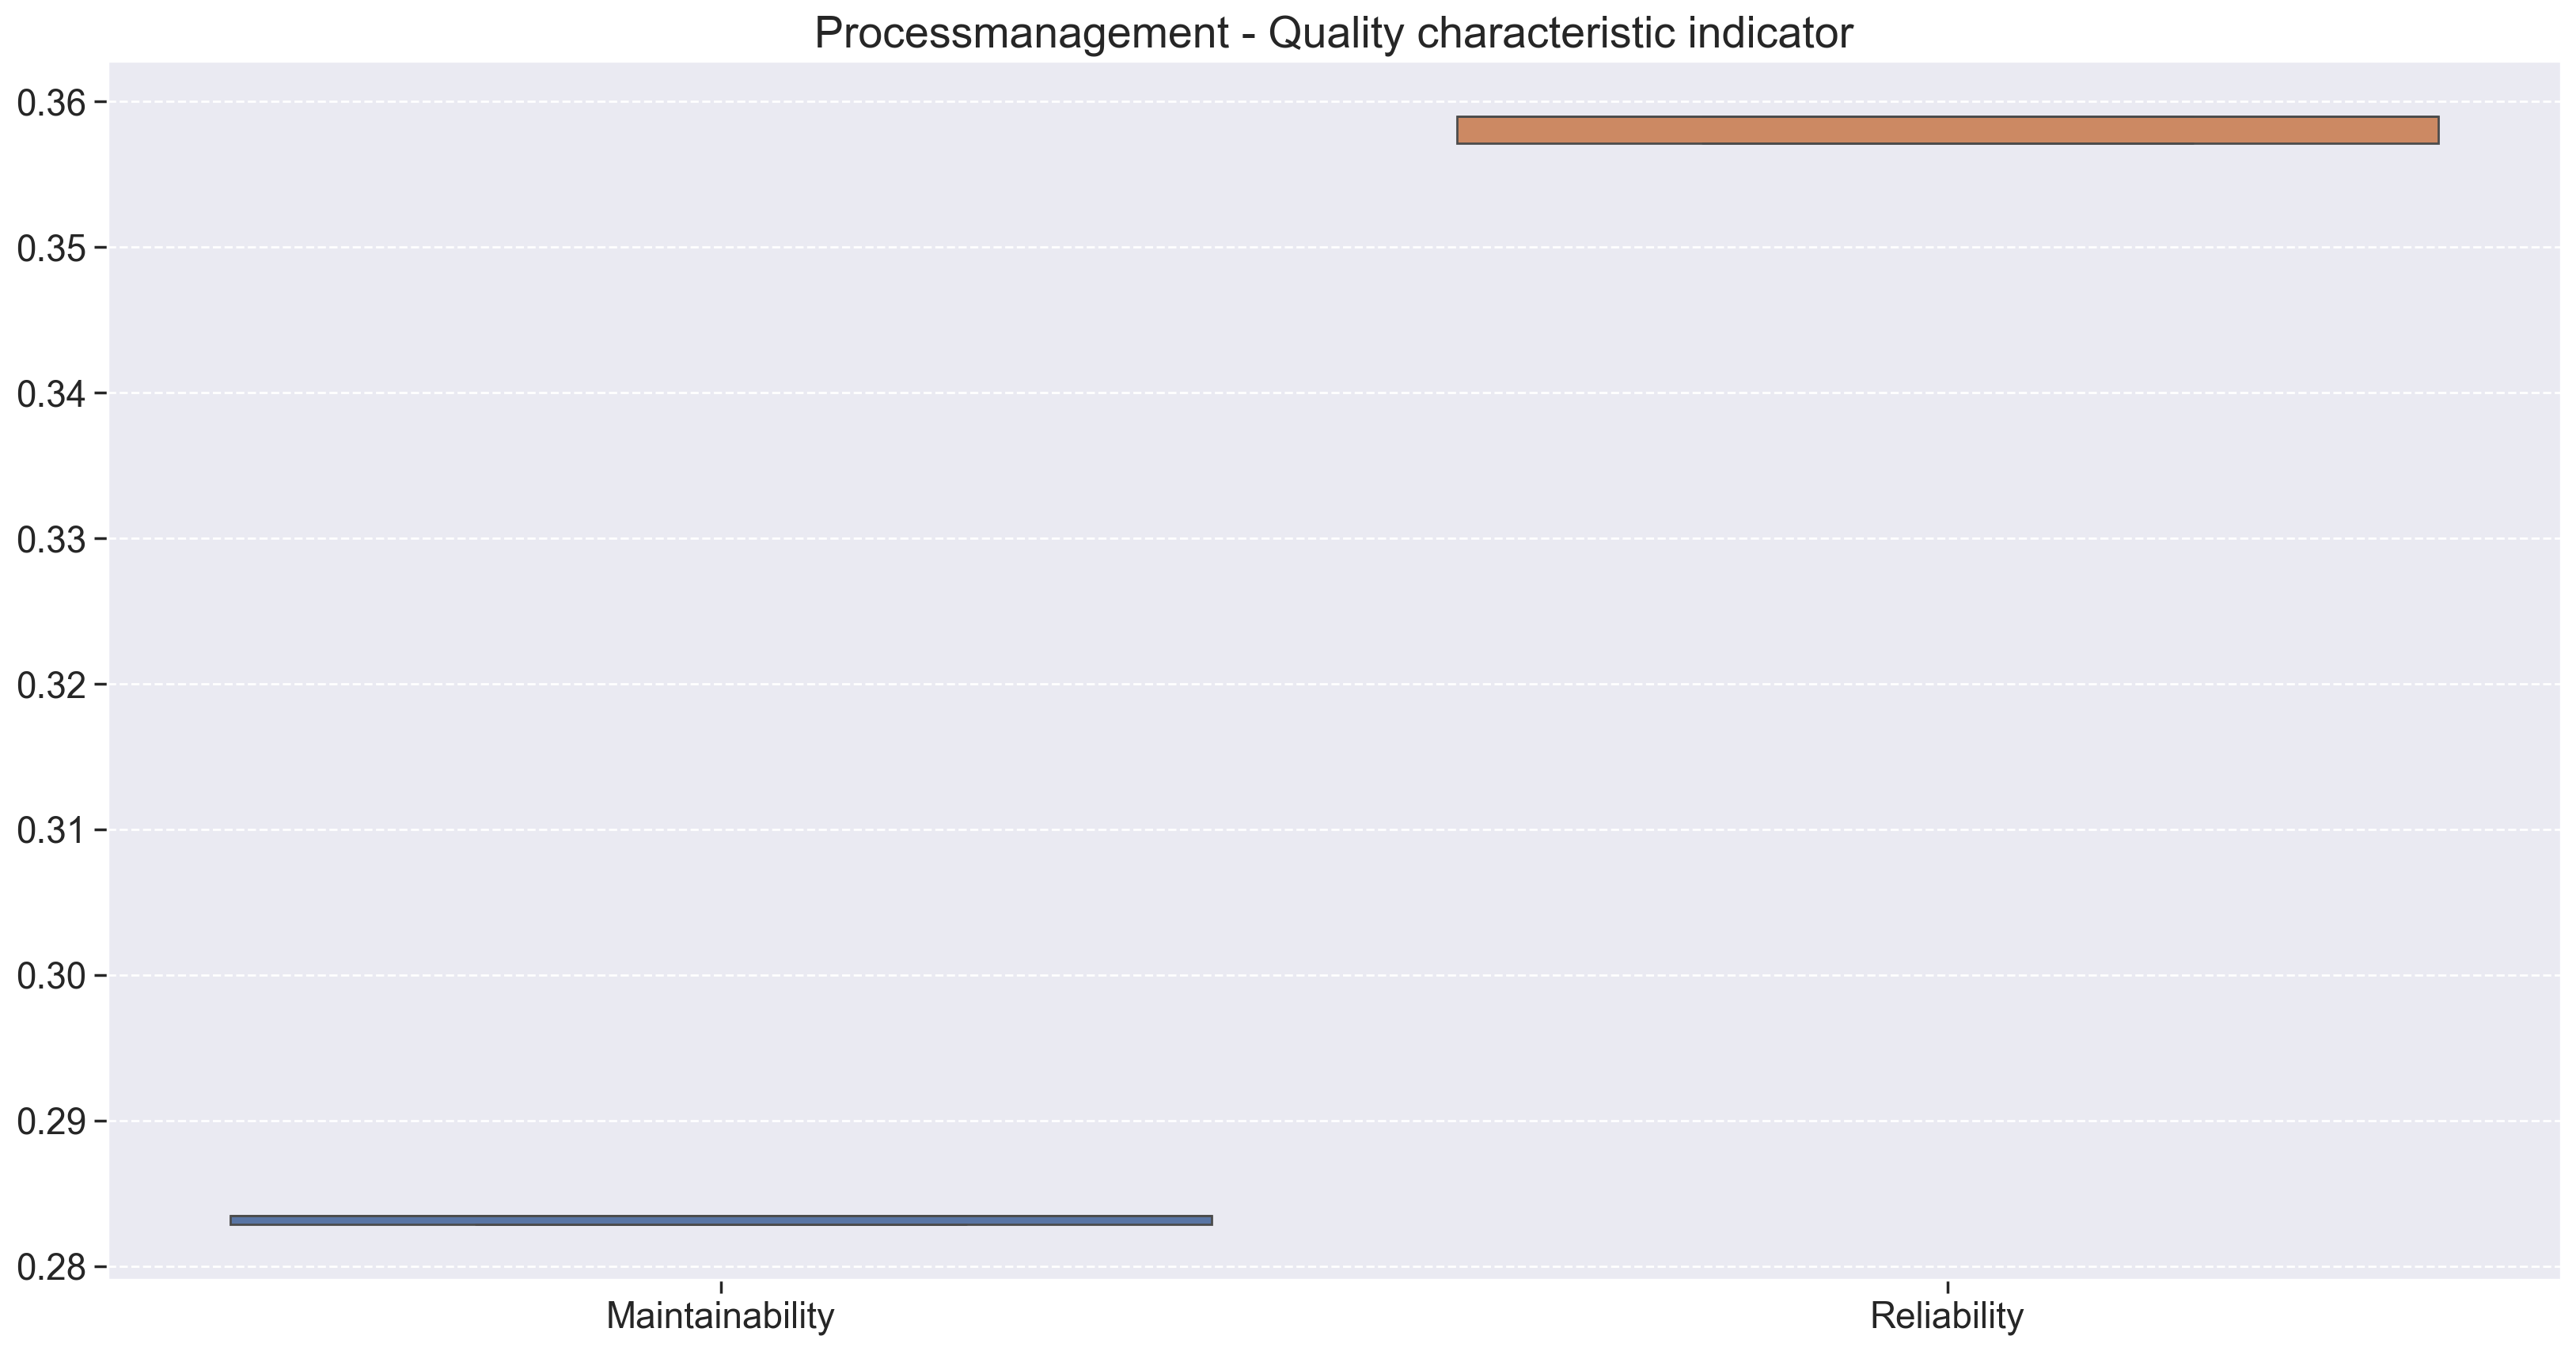

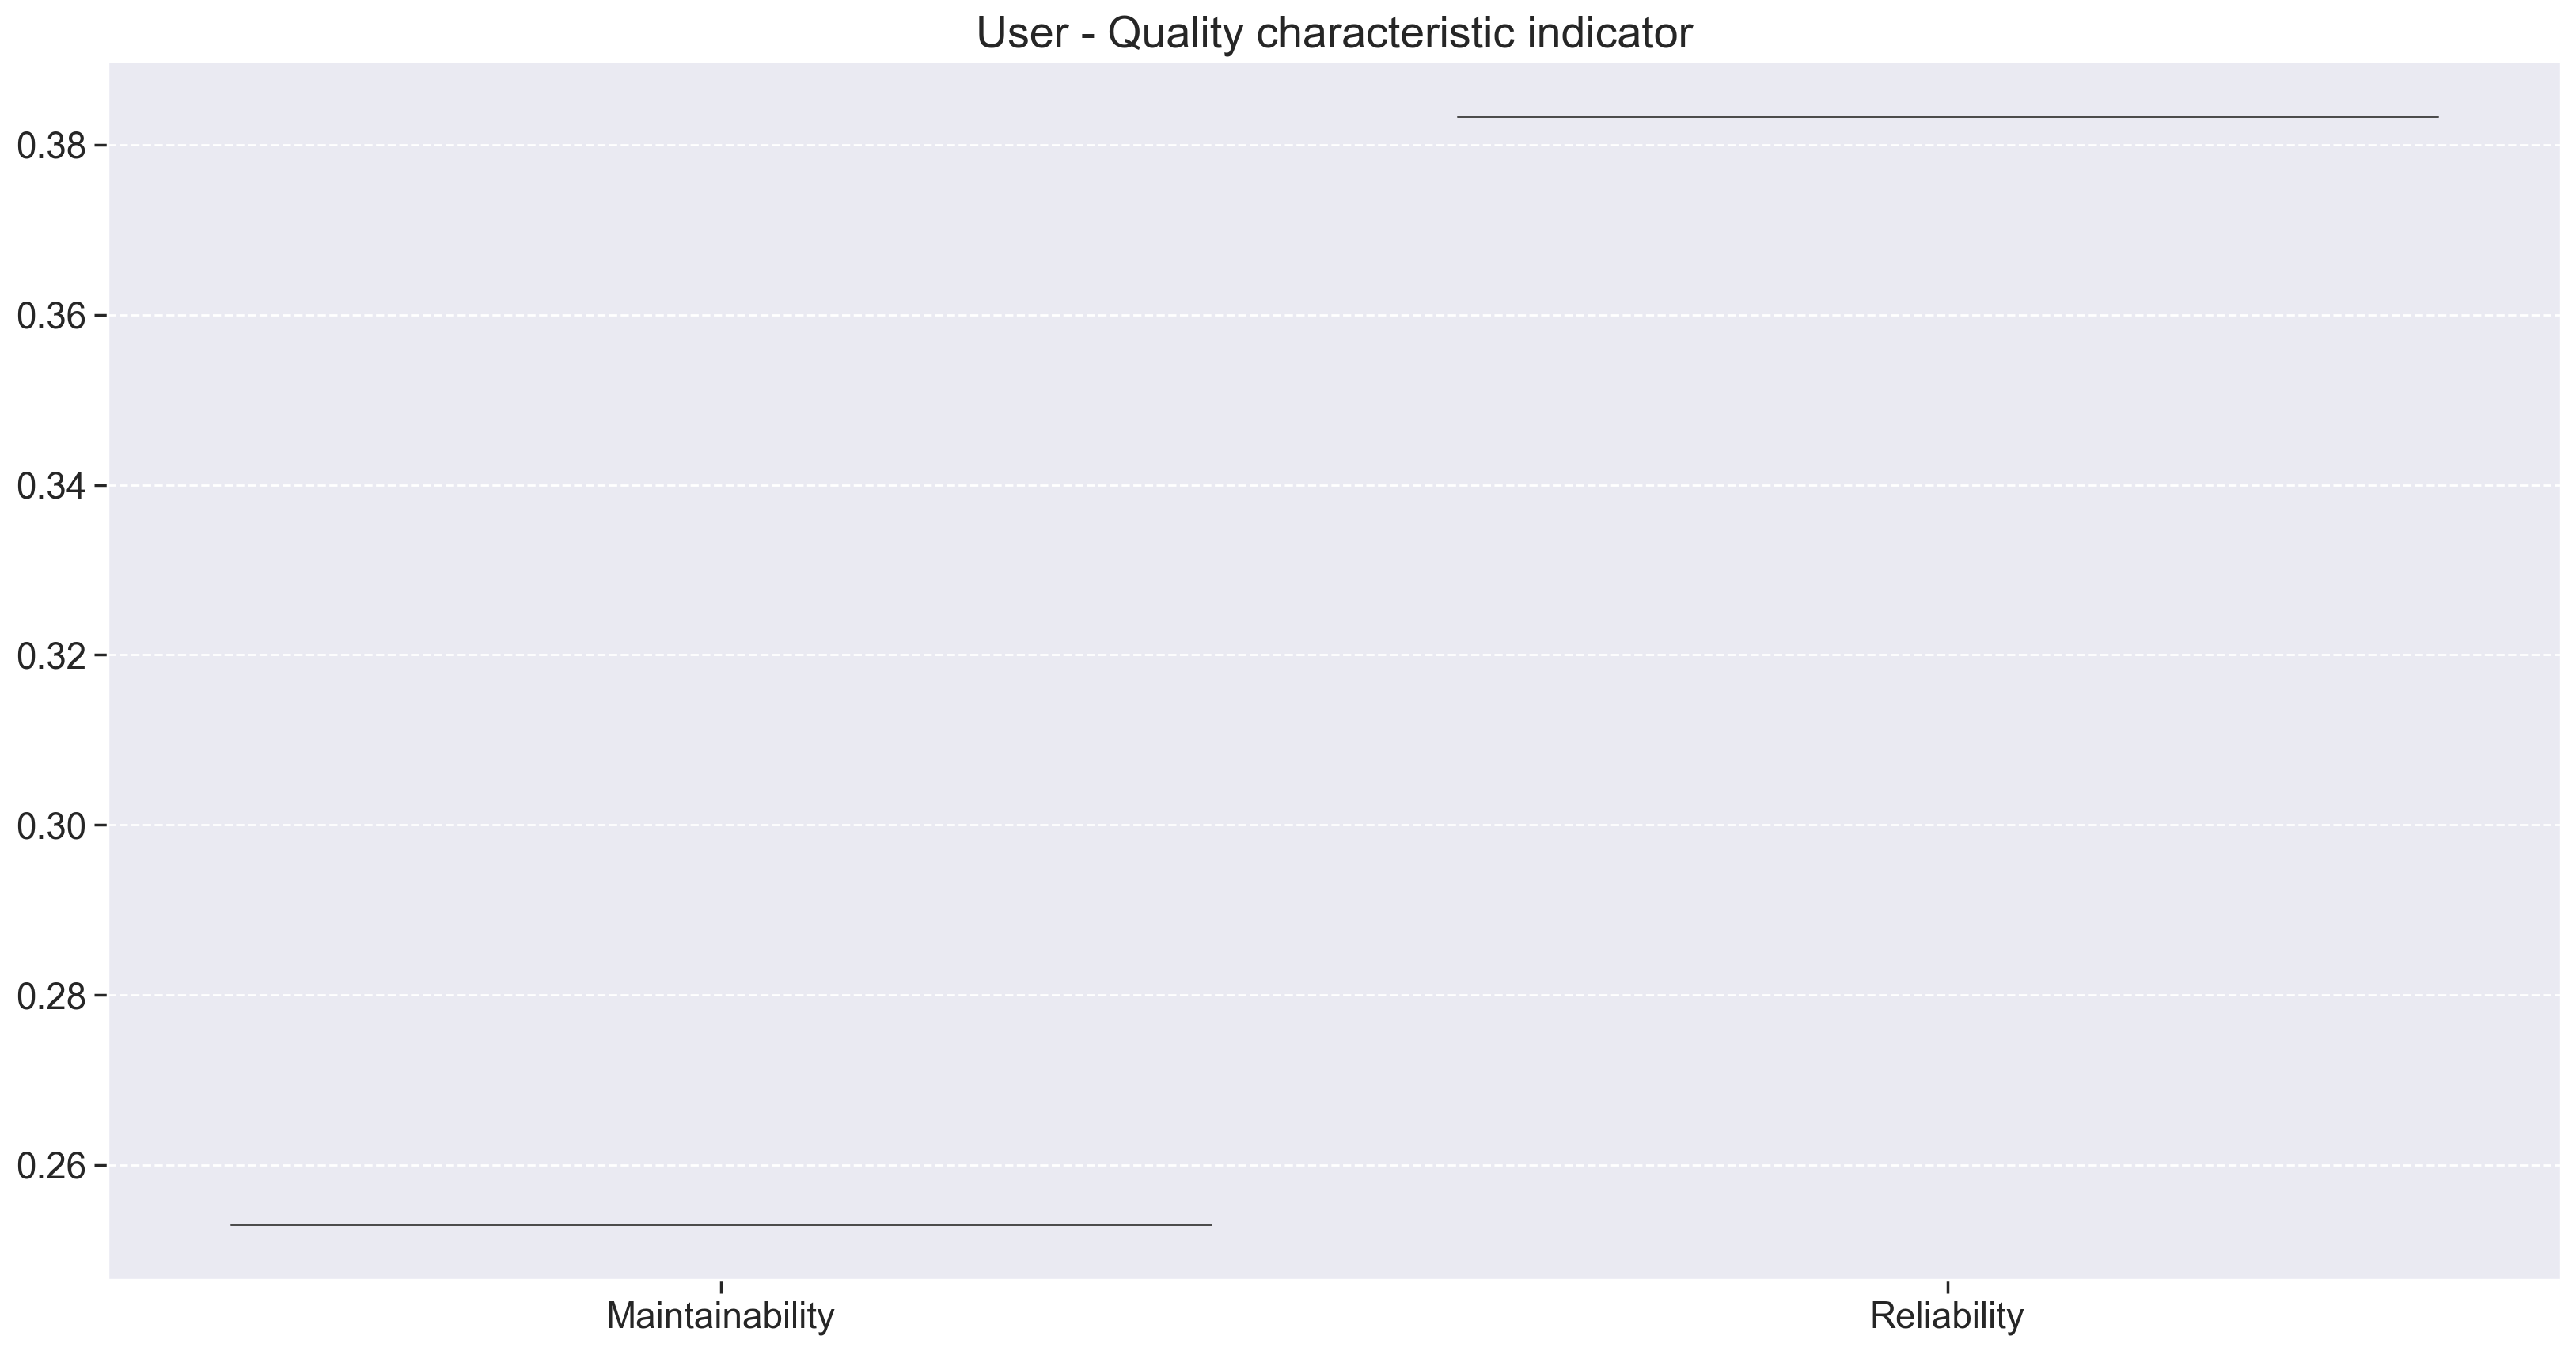

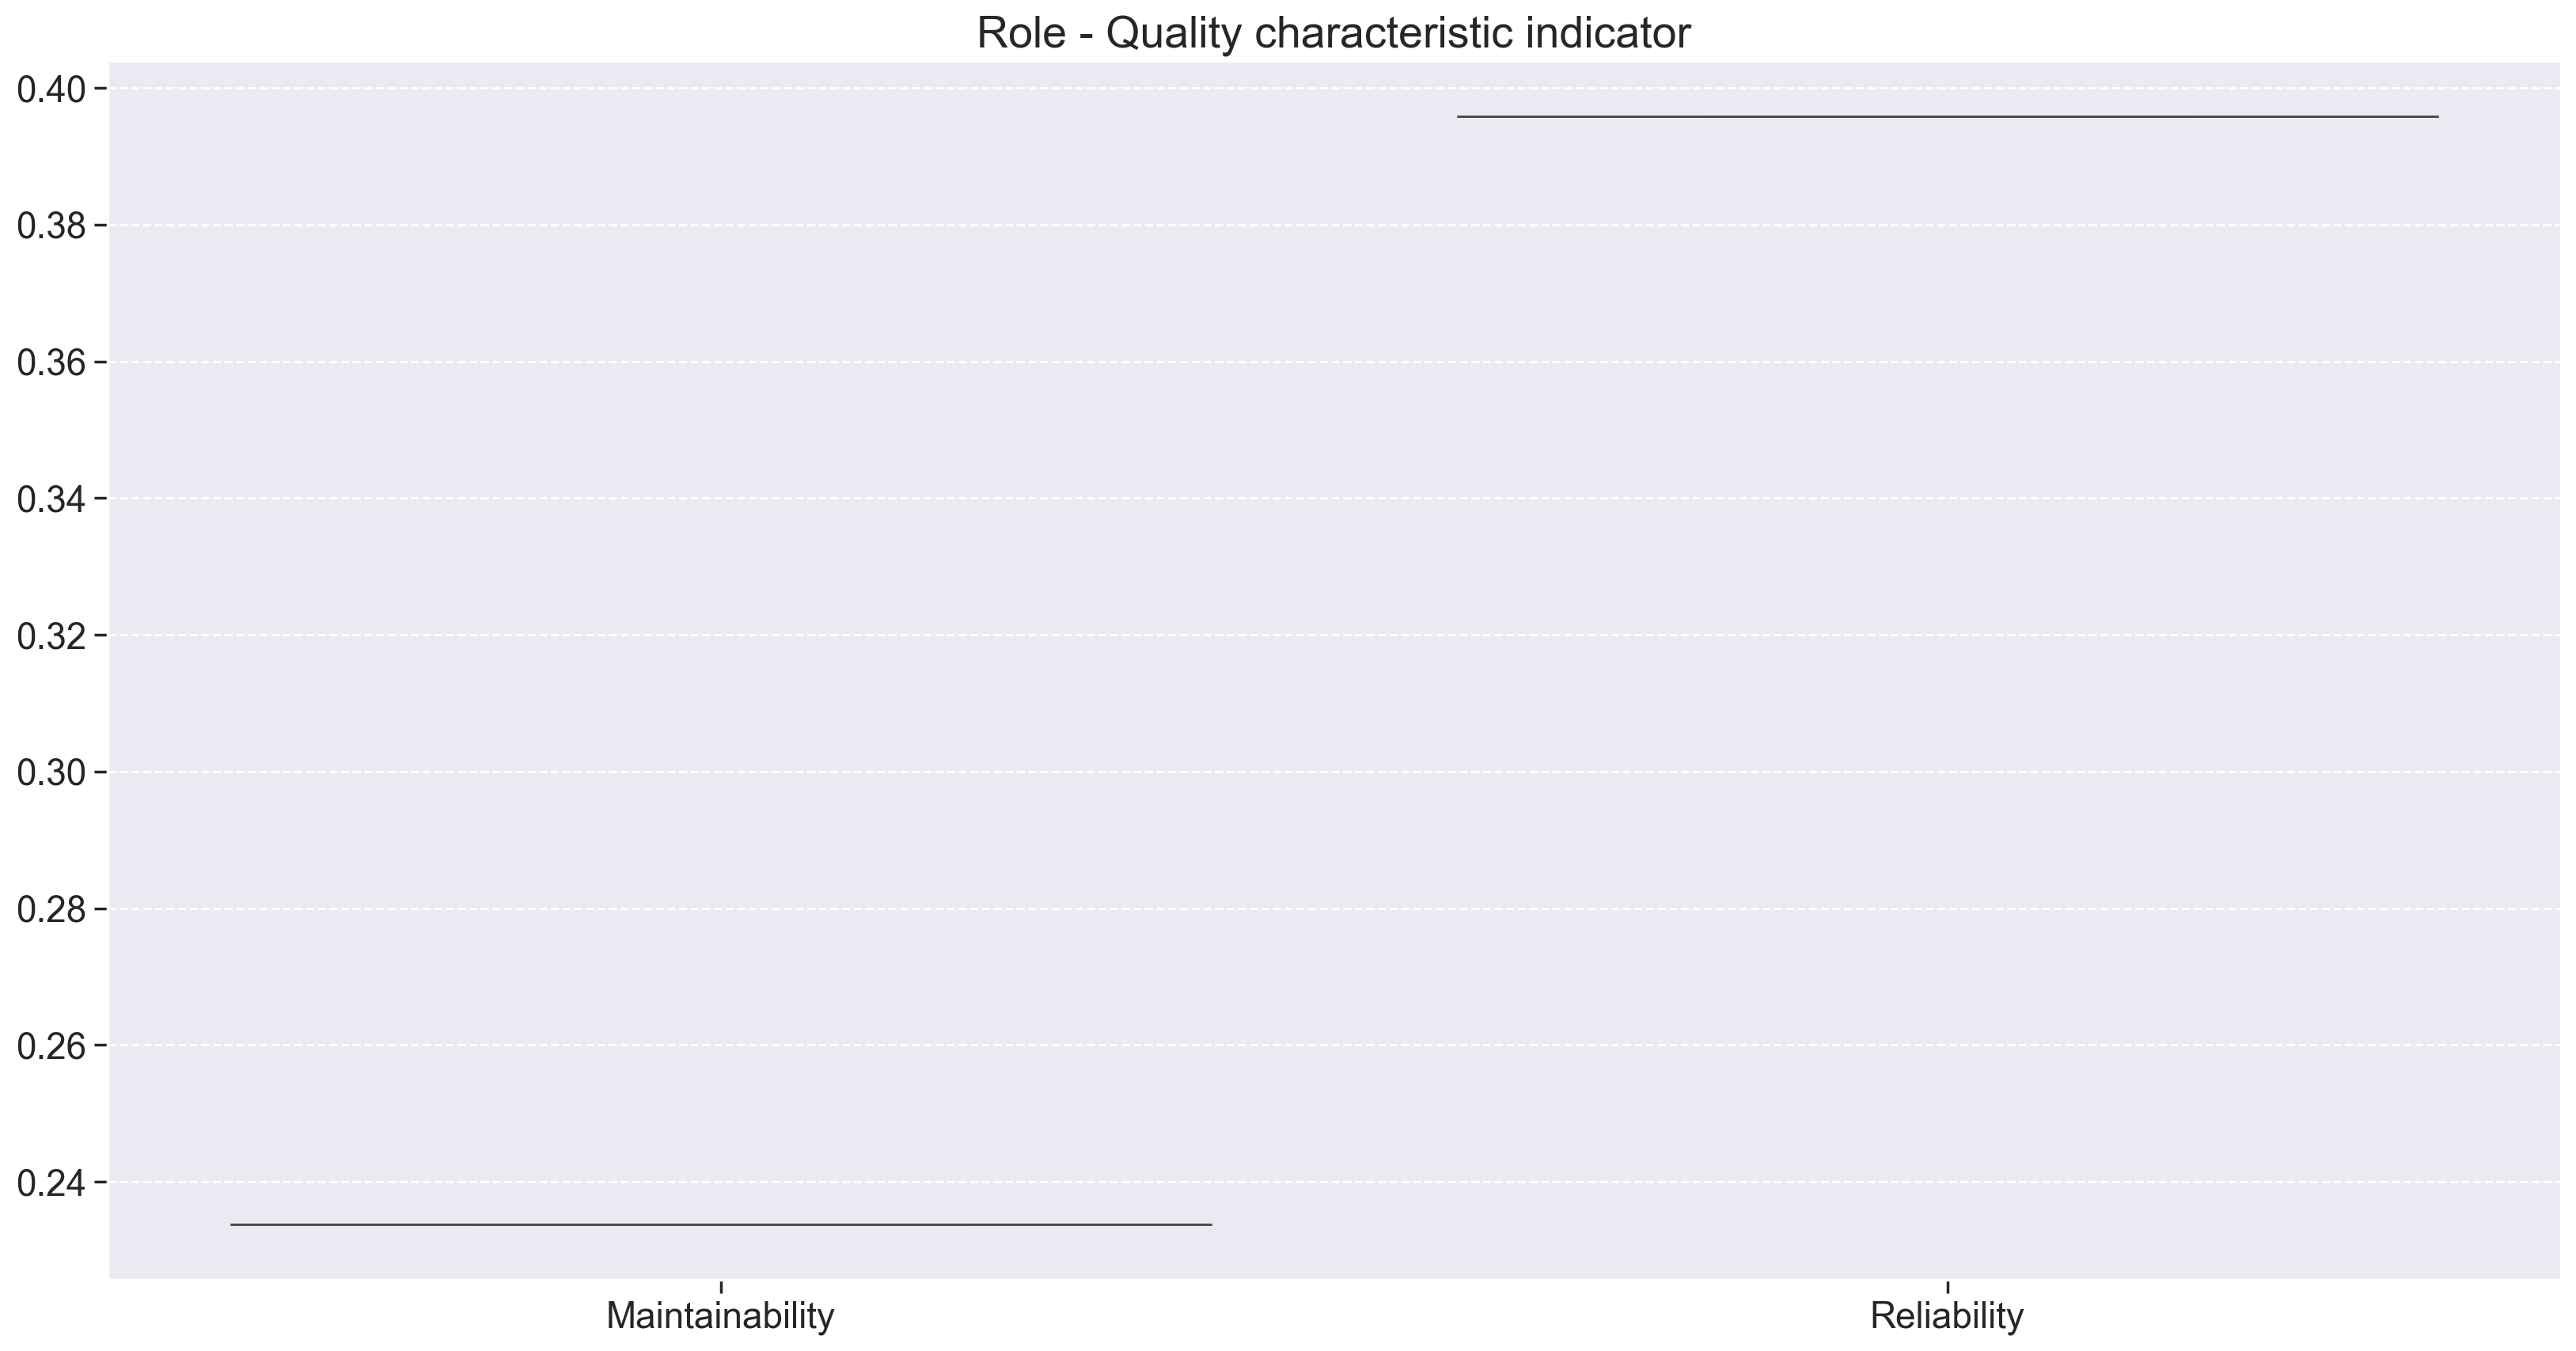

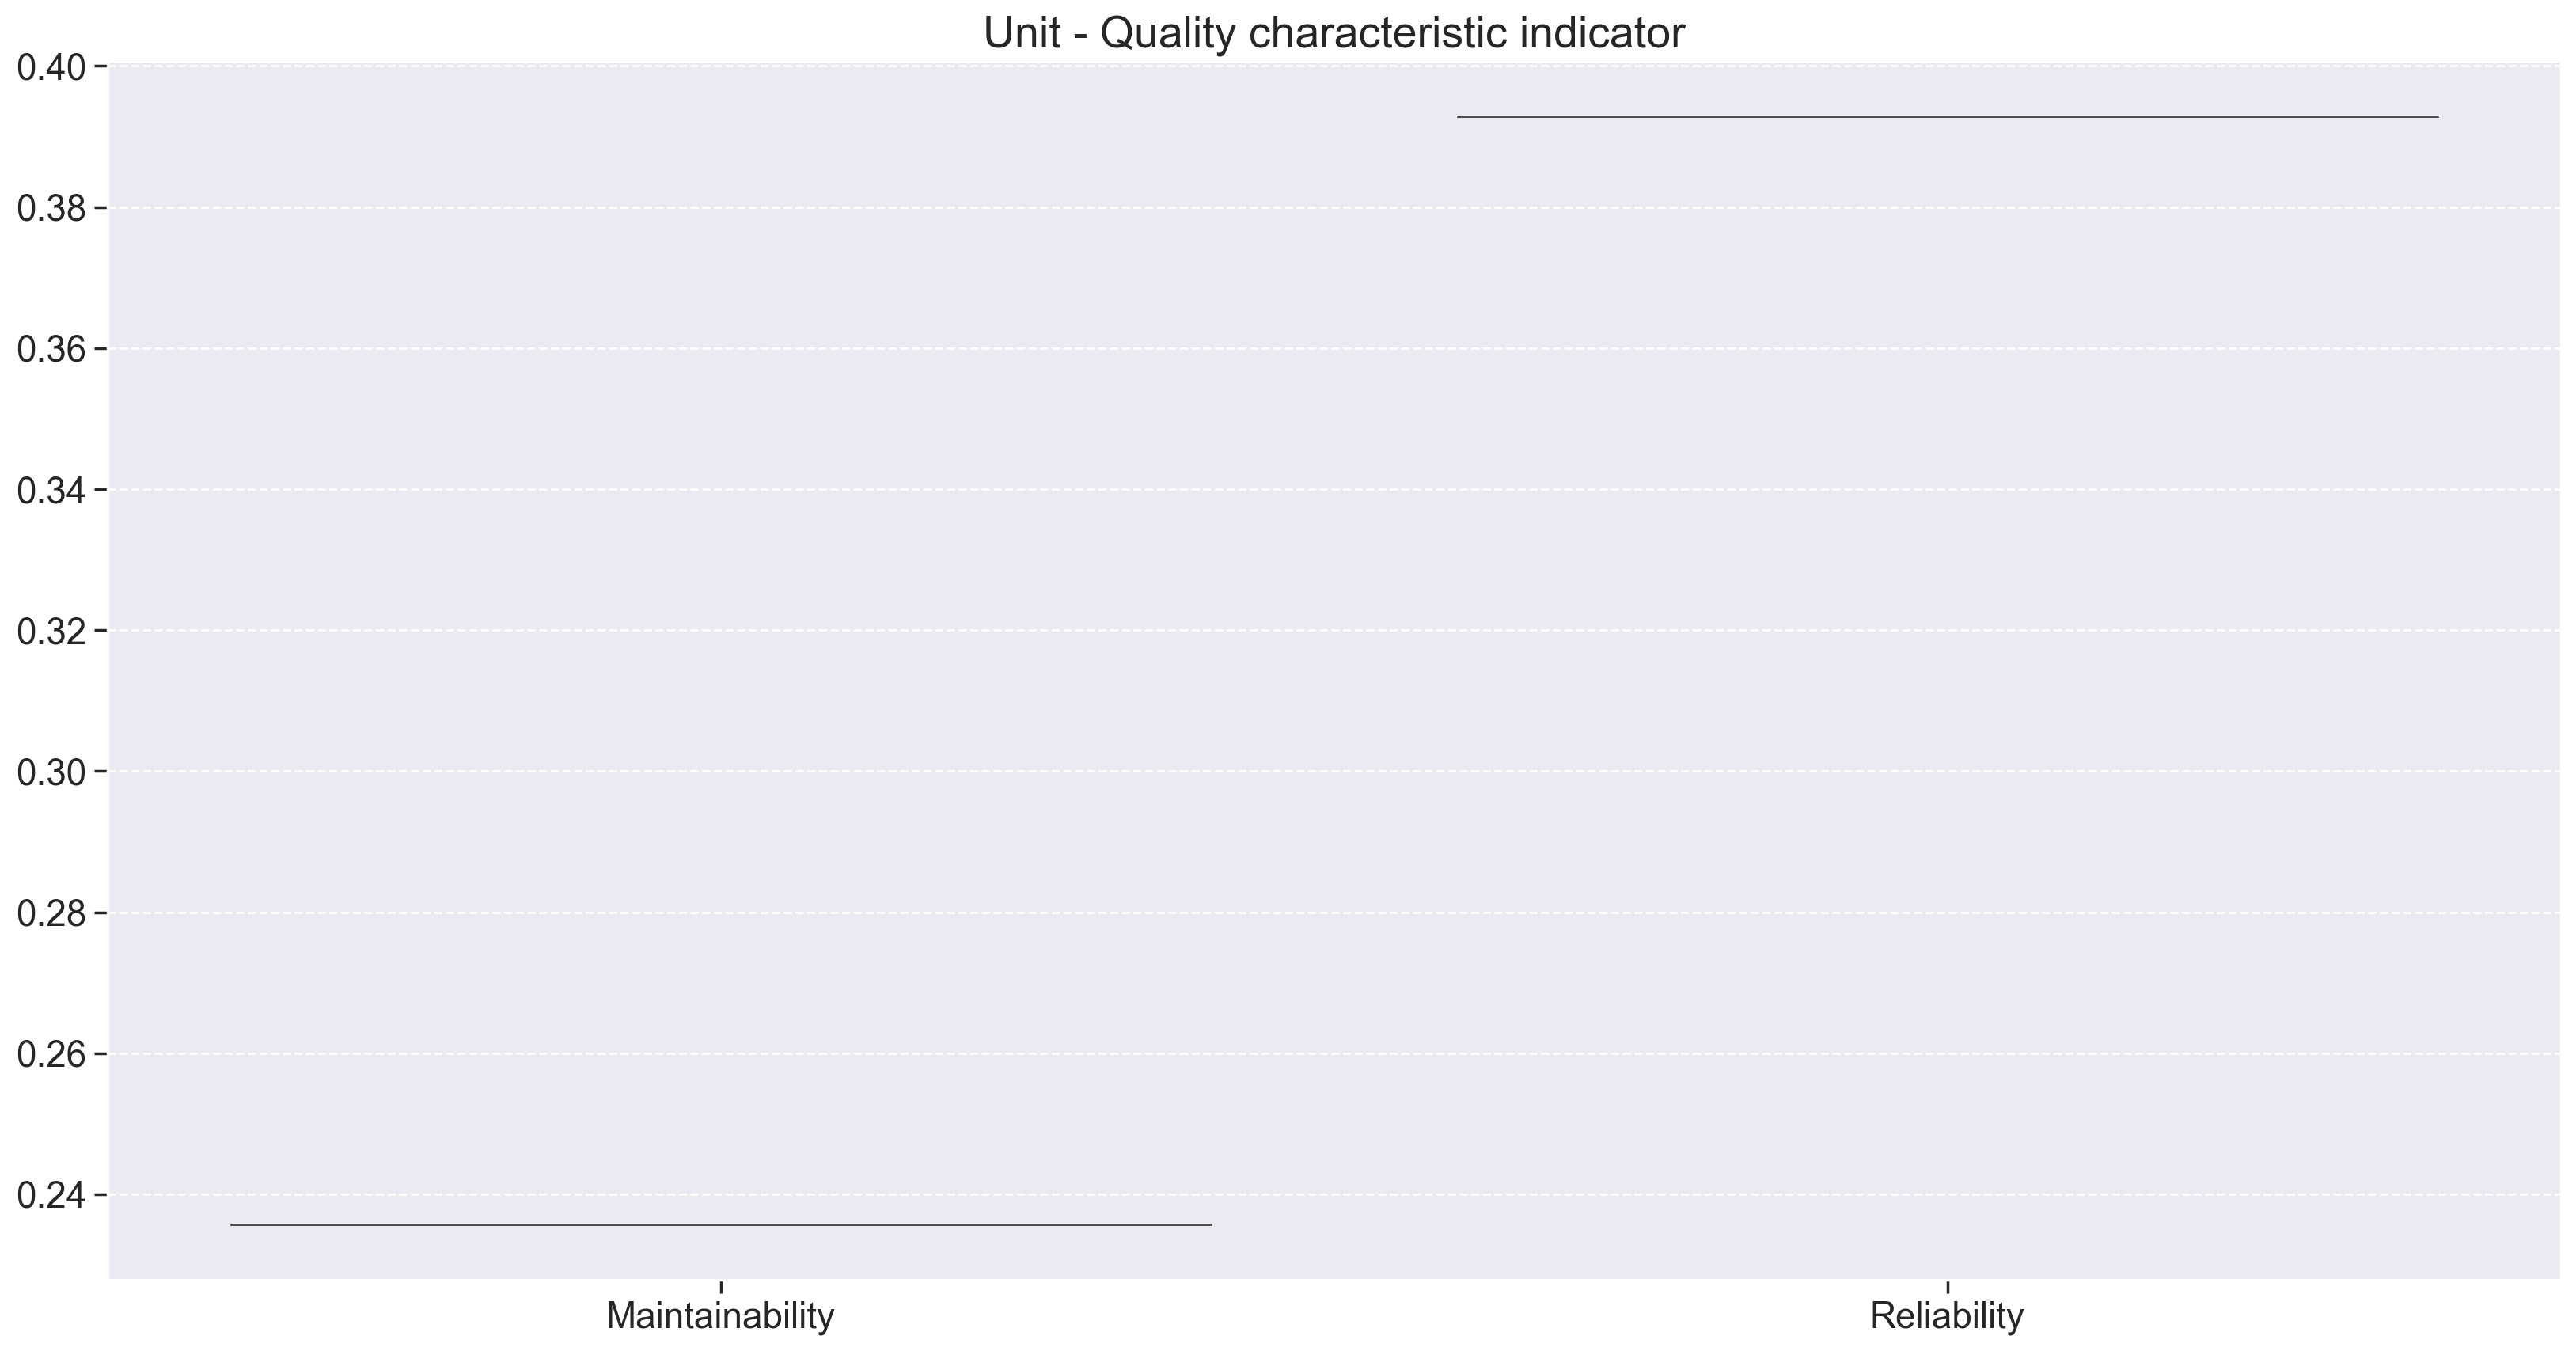

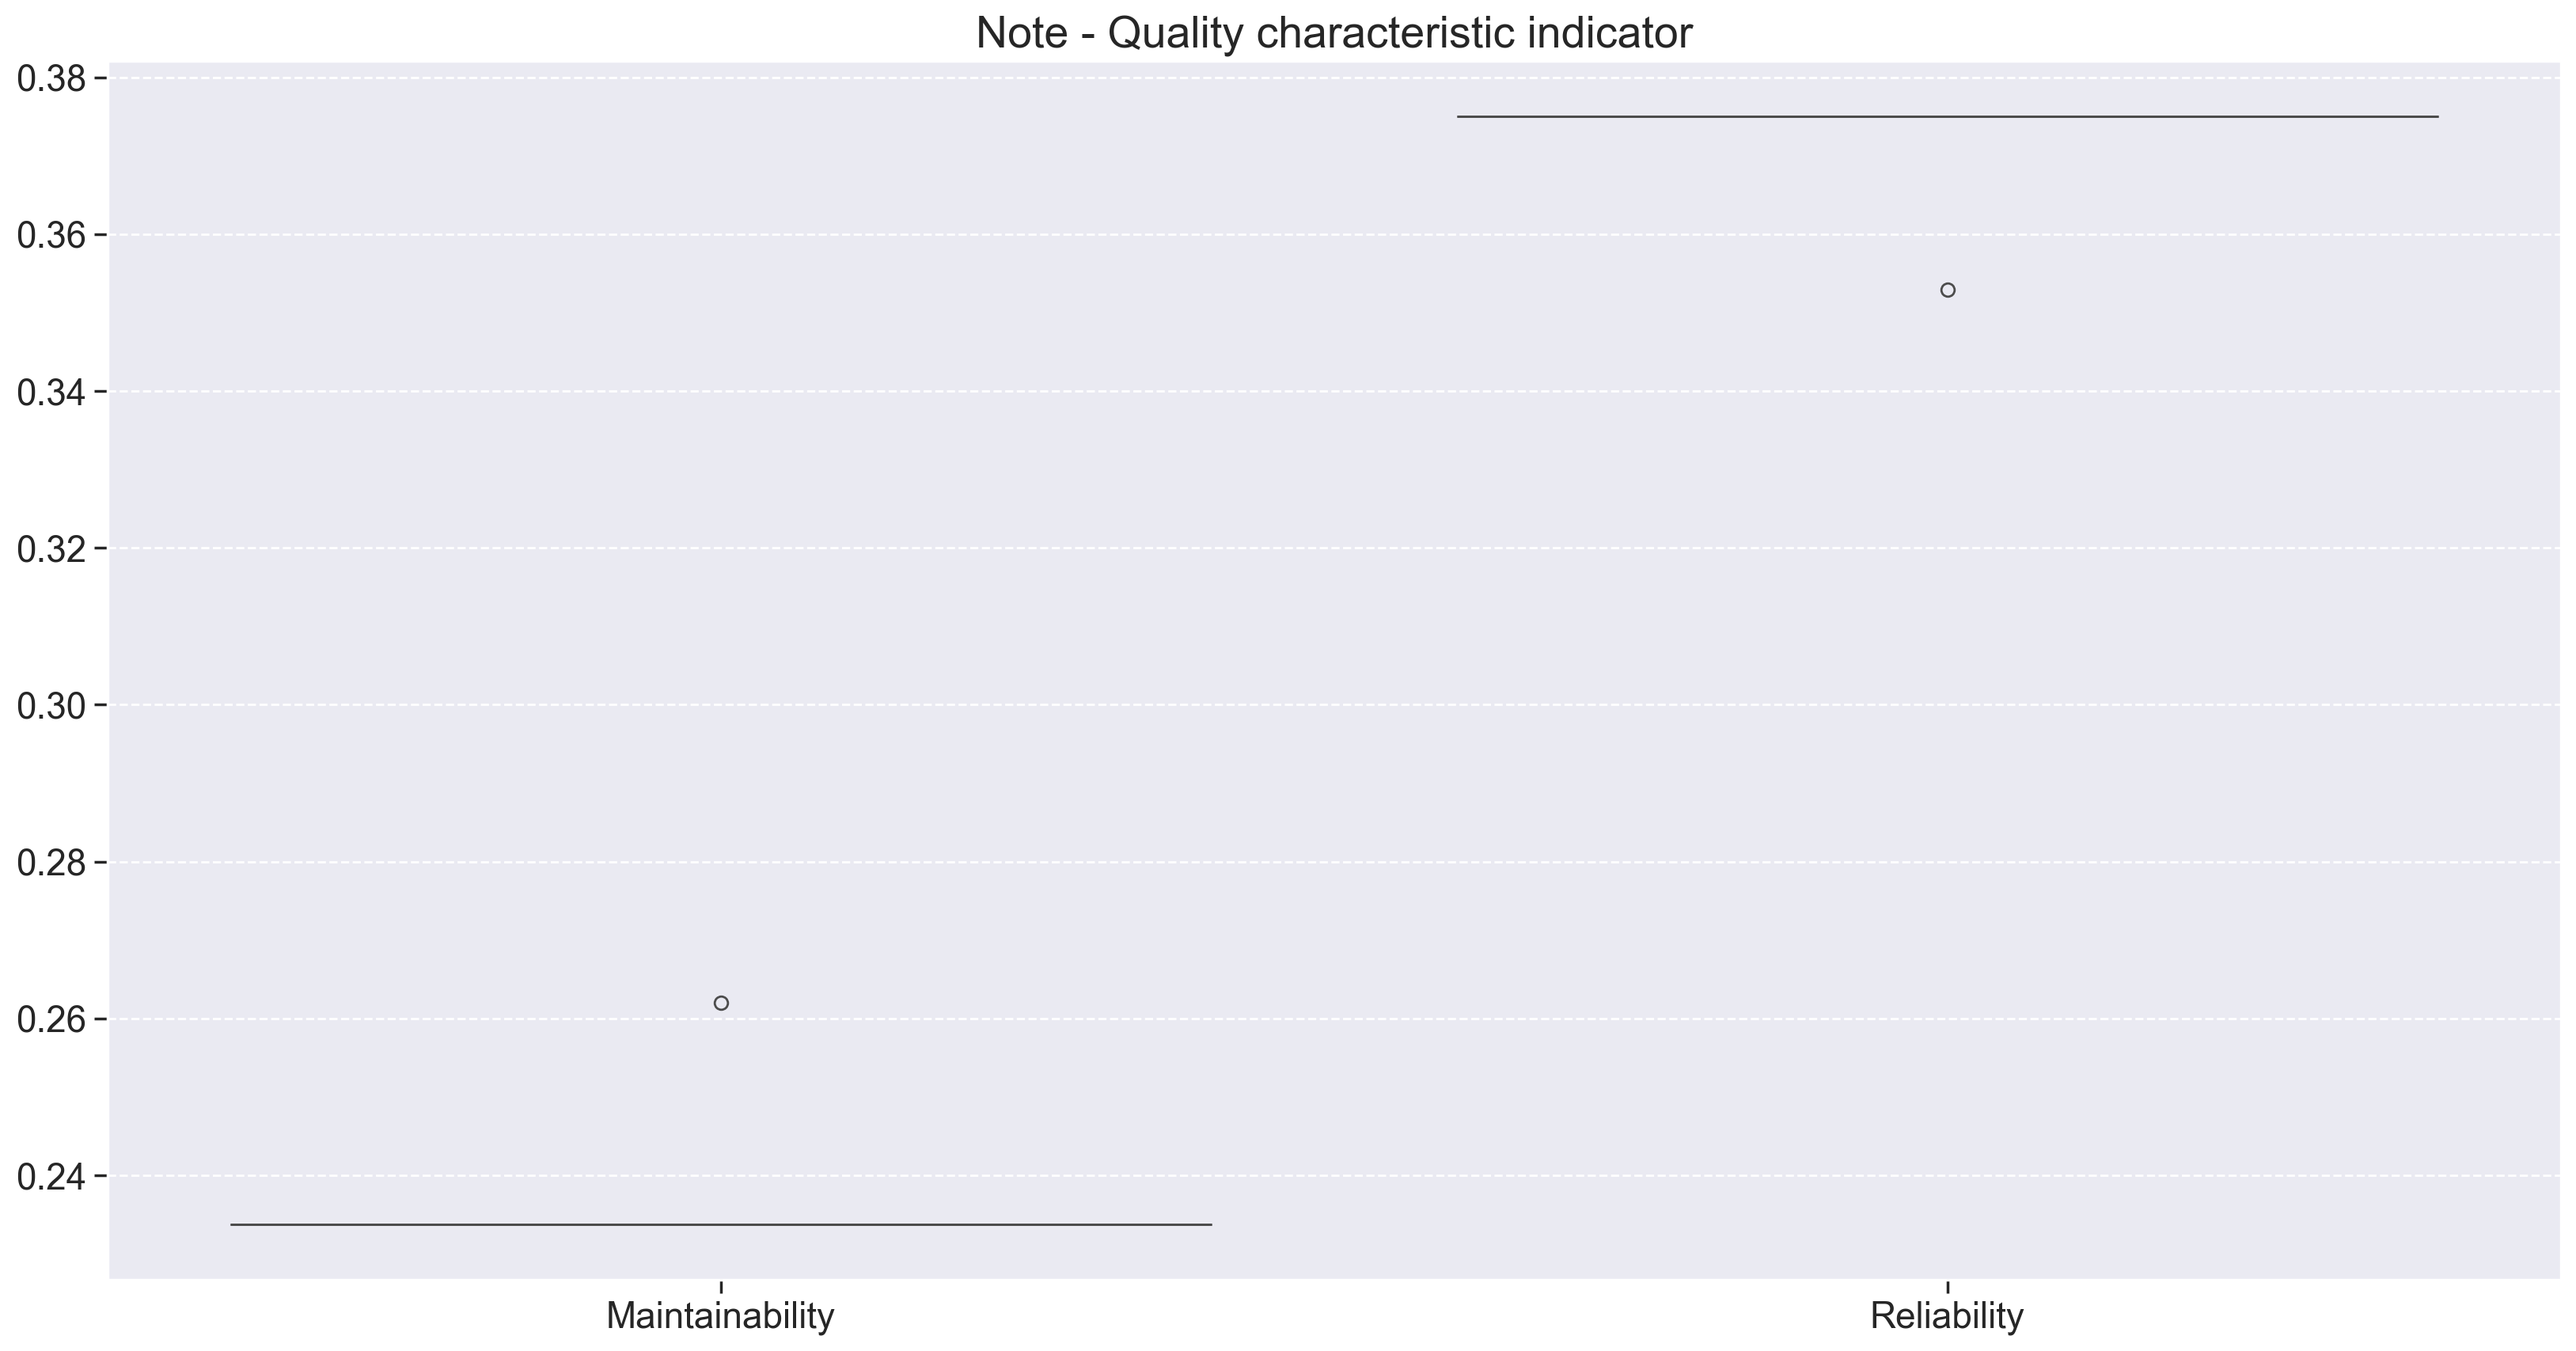

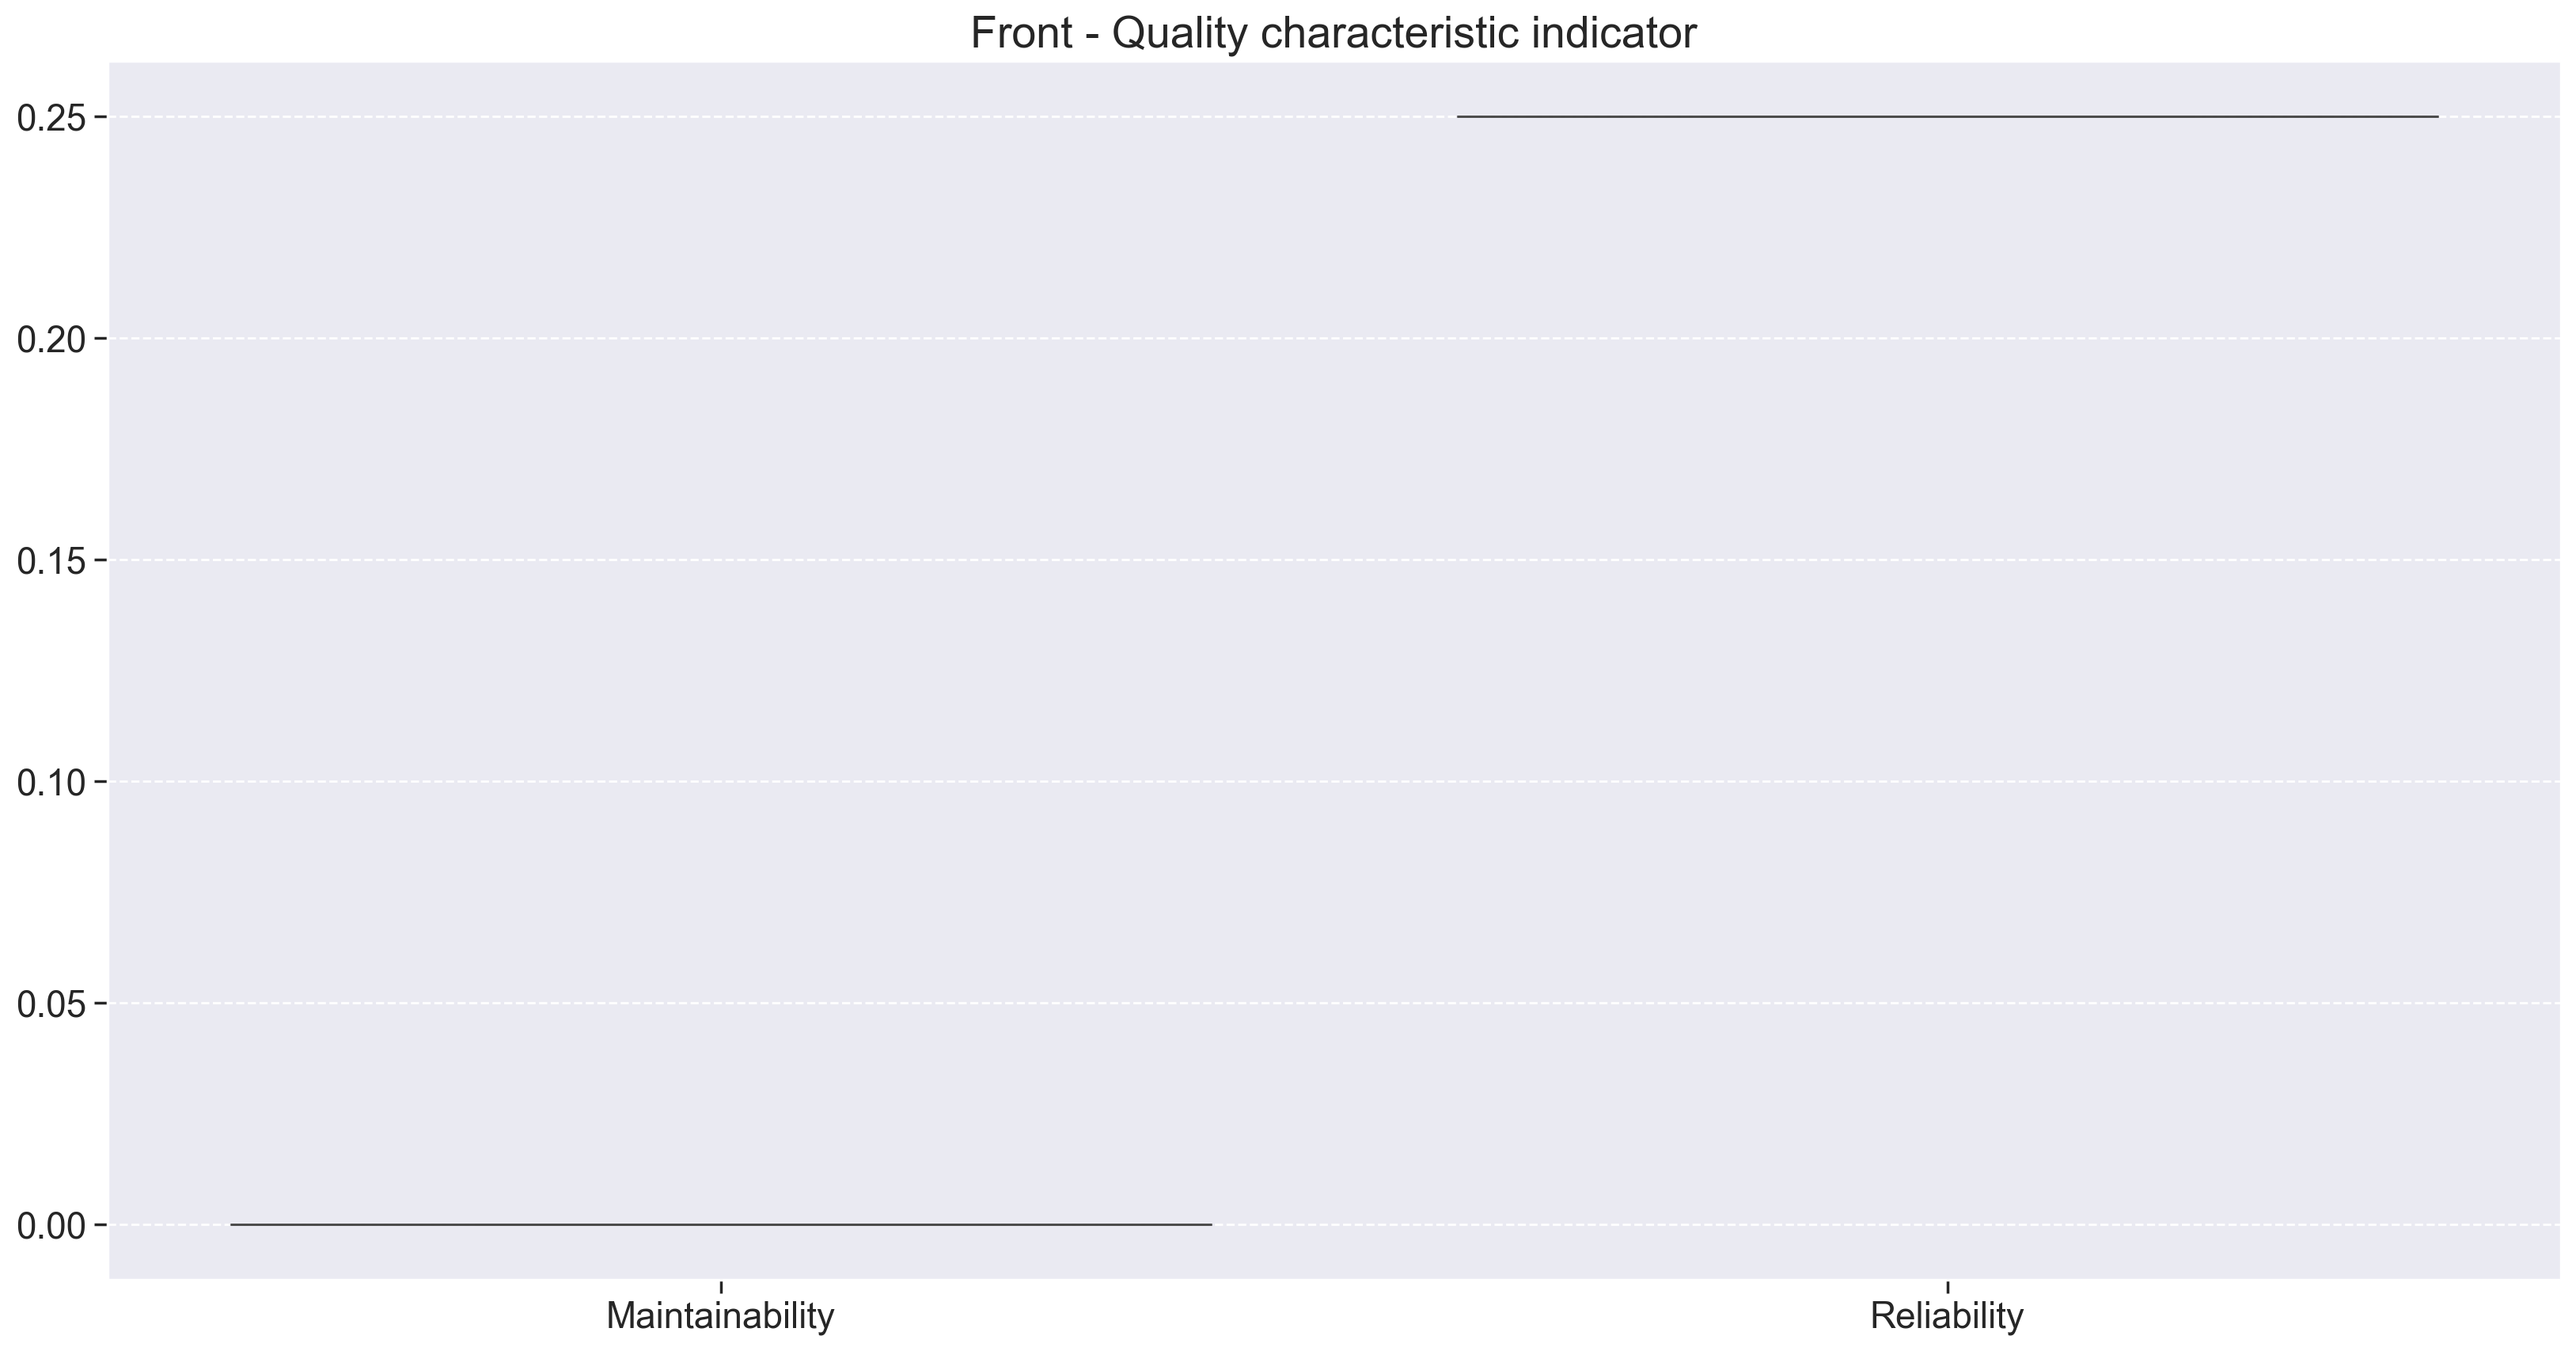

In [31]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

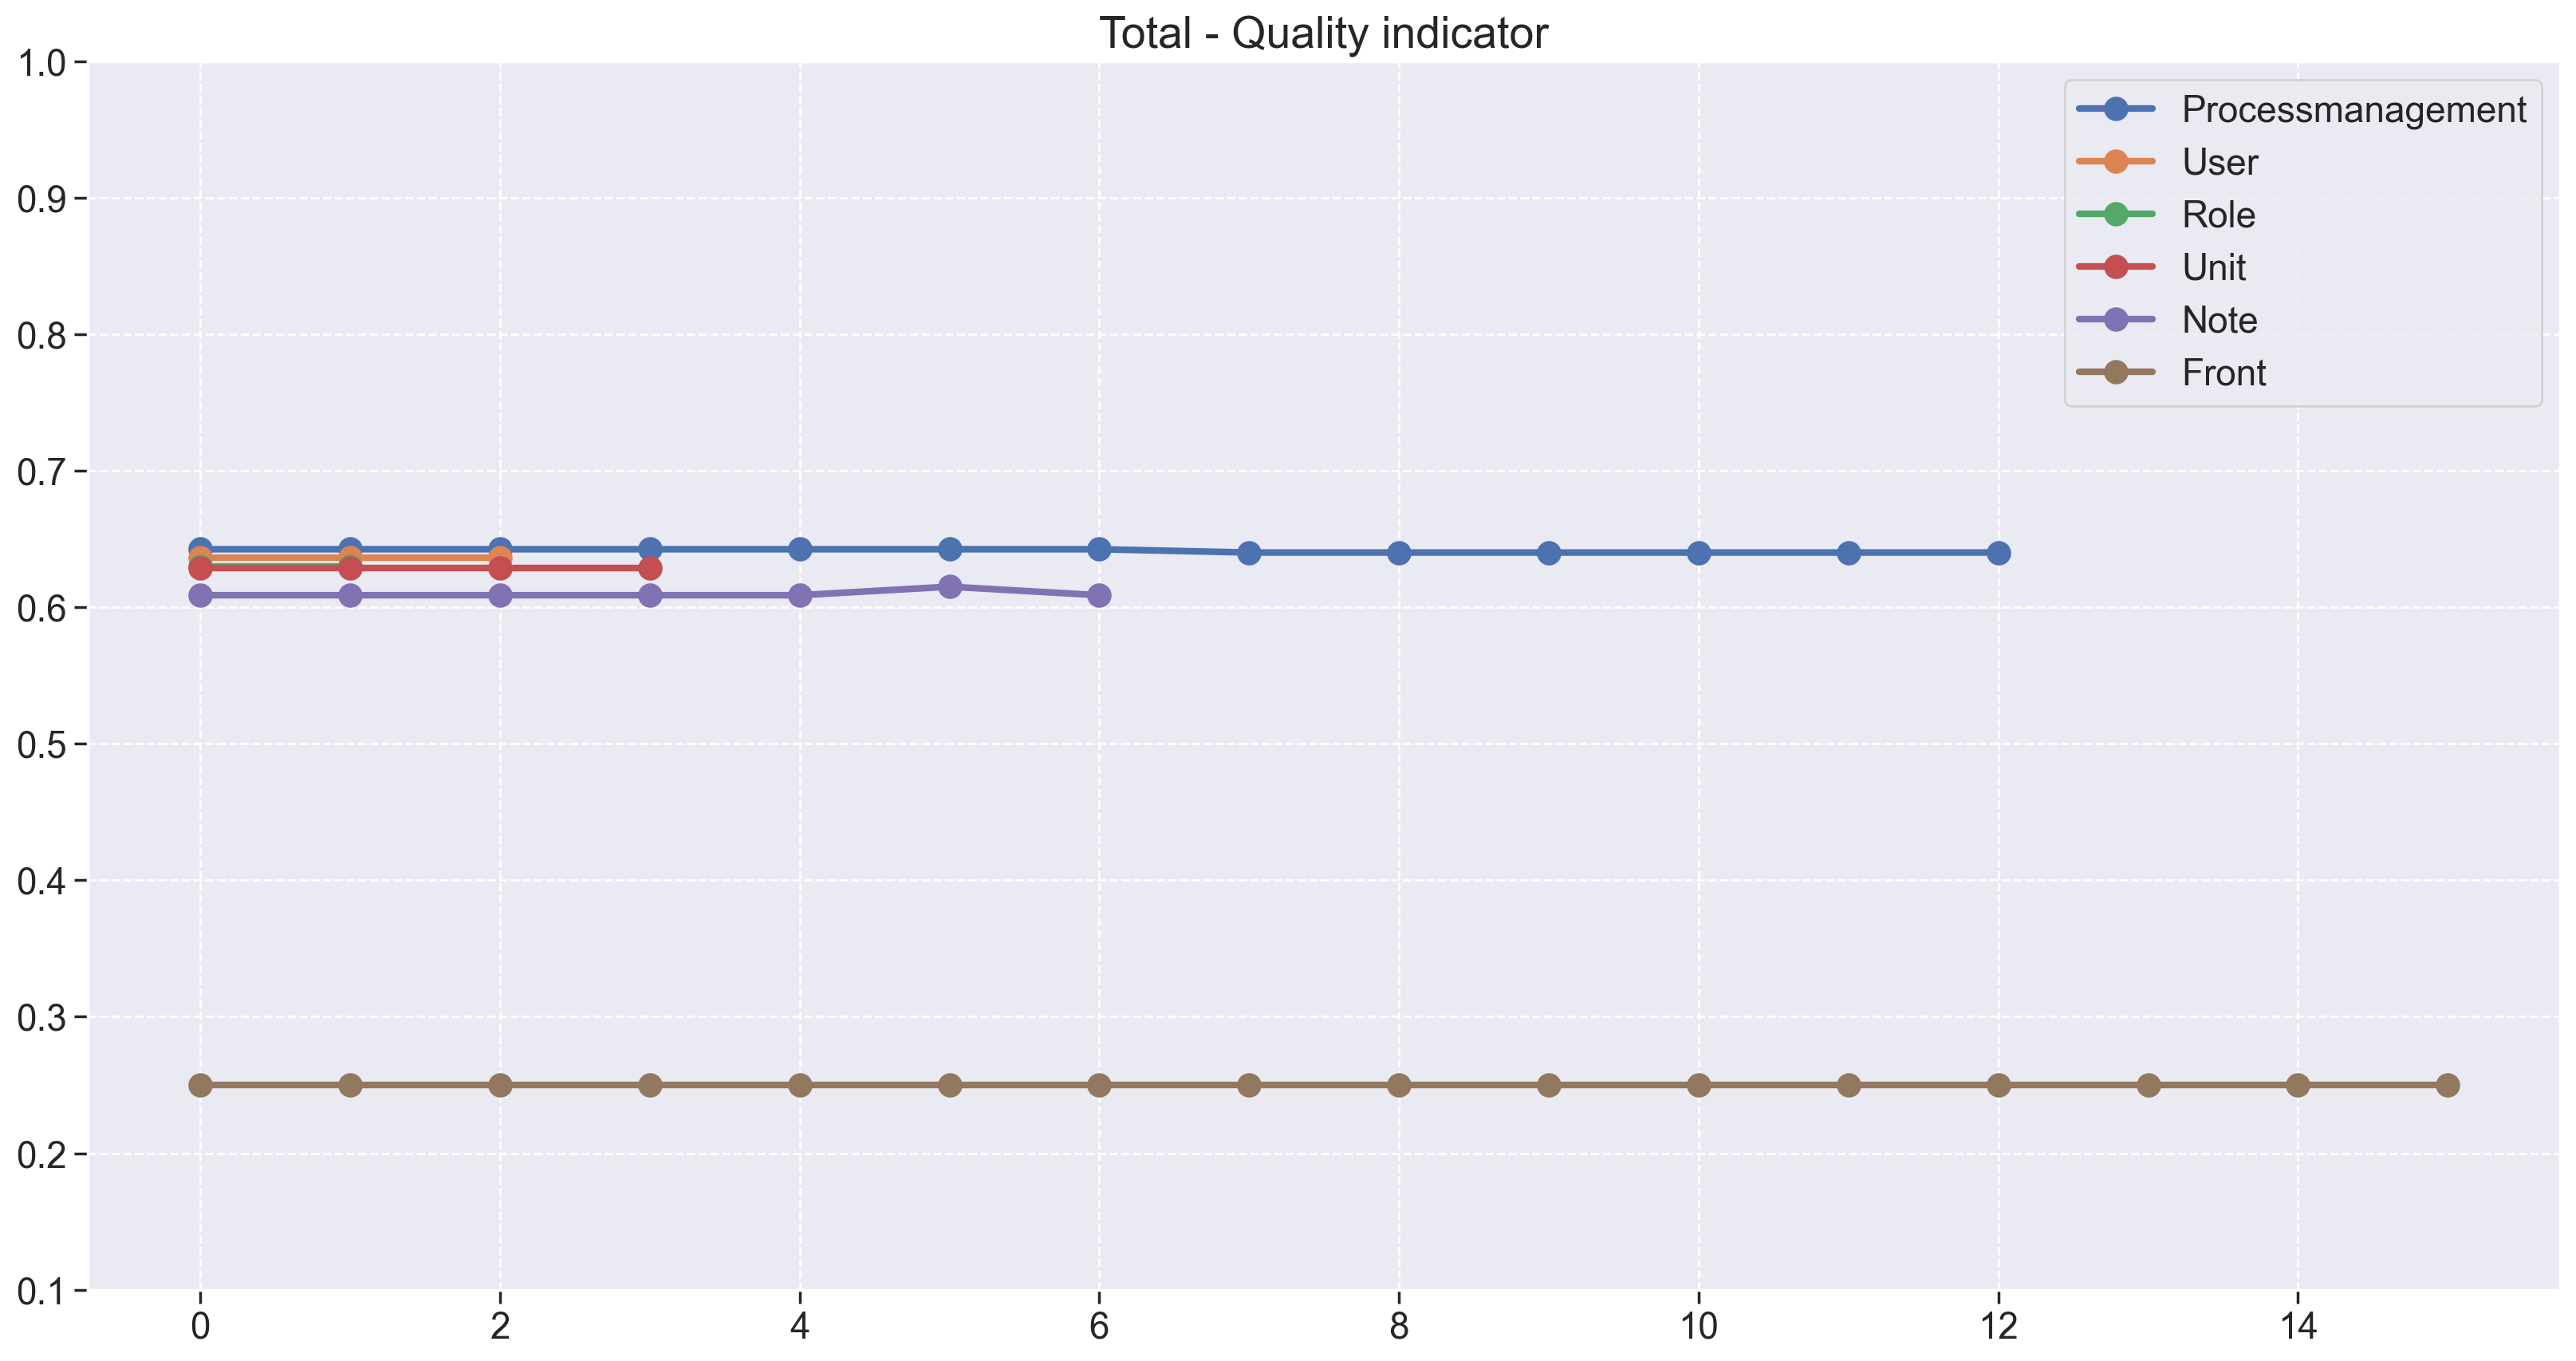

In [32]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [33]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2023-2-CAPJU--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2023-2-CAPJU--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,10-19-2023-19-47-06,5386,0.566923,0.717949,0.283462,0.358974,0.642436
1,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,10-19-2023-19-50-18,5386,0.566923,0.717949,0.283462,0.358974,0.642436
2,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,10-27-2023-21-28-59,5386,0.566923,0.717949,0.283462,0.358974,0.642436
3,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,10-27-2023-21-36-06,5386,0.566923,0.717949,0.283462,0.358974,0.642436
4,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,10-27-2023-21-45-34,5386,0.566923,0.717949,0.283462,0.358974,0.642436
5,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,11-13-2023-18-26-42,5386,0.566923,0.717949,0.283462,0.358974,0.642436
6,0.692308,0.025641,1.0,1.0,1.0,0.435897,fga-eps-mds-2023-2-Capju-Processmanagement,11-16-2023-21-27-55,5386,0.566923,0.717949,0.283462,0.358974,0.642436
7,0.690476,0.023810,1.0,1.0,1.0,0.428571,fga-eps-mds-2023-2-Capju-Processmanagement,11-19-2023-22-28-41,5968,0.565714,0.714286,0.282857,0.357143,0.640000
8,0.690476,0.023810,1.0,1.0,1.0,0.428571,fga-eps-mds-2023-2-Capju-Processmanagement,11-20-2023-19-08-41,5968,0.565714,0.714286,0.282857,0.357143,0.640000
9,0.690476,0.023810,1.0,1.0,1.0,0.428571,fga-eps-mds-2023-2-Capju-Processmanagement,11-20-2023-21-43-44,5968,0.565714,0.714286,0.282857,0.357143,0.640000


**1) No microsserviço de backend que apresentar o pior indicador de manutenibilidade indique qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.** <br/>
R: No serviço de role os módulos mais críticos são a controller e a services em que uma refatoração nos código estabelecidos e algumas tratativas conseguiriam melhorar a manutaneabilidade e aproveitamento de funções. Contudo, não foi montado nenhum plano de ação ainda para resolver esse problema. 

**2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.** <br/>
R: No projeto foi levantado uma história para descrever um requisito não funcional ("Melhorar feedback de erro") que apesar de ser voltado ao aspecto para conseguir melhorar as mensagens de erro para o usuário ele trata exatamente do serviço de process management em que para isso melhoria a confiabilidade de código no aspecto de tratativas de erro do serviço e com mensagens mais intuitivas.

**3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.** <br/>
R: Pelo aspecto de métricas internas com relação ao código a qualidade do time em cima dos projetos se mostrou estagnada. Pelo demonstrado nos gráficos a qualidade de muitos repositórios se mantiveram no mesmo aspecto sem melhora, alguns devido a baixo indíce de subida, nessa etapa de evolução do projeto o principal serviço mexido foi o de process management e ele assim como os demais tiveram seu gráfico de qualidade estagnado. Com as entregas sendo feitas o time começou a correr atrás dos testes e da refatoração de algumas funções, principalmente do front-end, de forma a elevar o grau de qualidade do projeto, principalmente do front-end. Contudo teve um crescimento perceptível no início do projeto no serviço de roles que isso foi devido a elevação da cobertura de testes para 100% no início do projeto. 